In [1]:
import torch
import pandas as pd
import numpy as np
import anndata
from scipy.spatial import distance
import scanpy as sc
from collections import OrderedDict
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import functools
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm.notebook import tqdm
import scanpy as sc
from collections import Counter
import matplotlib.cm as cm
from anndata import AnnData
import itertools as it
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.sparse import vstack
import time
import torch.nn as nn
import numpy as np
import torch
#from sklearn.cluster import k_means_
from sklearn.cluster import KMeans
import torch
from torch.nn import functional as F



In [2]:
import argparse
import torch.utils.data as data
import numpy as np
import torch

def get_parser():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-pretrain_batch', '--pretrain_batch',
                        type=int,
                        help='Batch size for pretraining. Default: no batch',
                        default=None)
    
    parser.add_argument('-pretrain','--pretrain',
                        type = bool,
                        default = True,
                        help='Pretrain model with autoencoder; otherwise load existing')
    
    parser.add_argument('-nepoch', '--epochs',
                        type=int,
                        help='number of epochs to train for',
                        default=30)

    parser.add_argument('-nepoch_pretrain', '--epochs_pretrain',
                        type=int,
                        help='number of epochs to pretrain for',
                        default=25)

    parser.add_argument('-source_file','--model_file',
                        type = str,
                        default = 'trained_models/source.pt',
                        help='location for storing source model and data')

    parser.add_argument('-lr', '--learning_rate',
                        type=float,
                        help='learning rate for the model, default=0.001',
                        default=0.001)

    parser.add_argument('-lrS', '--lr_scheduler_step',
                        type=int,
                        help='StepLR learning rate scheduler step, default=20',
                        default=20) 

    parser.add_argument('-lrG', '--lr_scheduler_gamma',
                        type=float,
                        help='StepLR learning rate scheduler gamma, default=0.5',
                        default=0.5)
  
    parser.add_argument('-seed', '--manual_seed',
                        type=int,
                        help='input for the manual seeds initializations',
                        default=3)
    
    parser.add_argument('--cuda',
                        action='store_true',
                        help='enables cuda')
    
    return parser


'''
Class representing dataset for an single-cell experiment.
'''

IMG_CACHE = {}


class ExperimentDataset(data.Dataset):
    
    
    def __init__(self, x, cells, genes, metadata, y=[]):
        '''
        x: numpy array of gene expressions of cells (rows are cells)
        cells: cell IDs in the order of appearance
        genes: gene IDs in the order of appearance
        metadata: experiment identifier
        y: numeric labels of cells (empty list if unknown)
        '''
        super(ExperimentDataset, self).__init__()
        
        self.nitems = x.shape[0]
        if len(y)>0:
            print("== Dataset: Found %d items " % x.shape[0])
            print("== Dataset: Found %d classes" % len(np.unique(y)))
                
        if type(x)==torch.Tensor:
            self.x = x
        else:
            shape = x.shape[1]
            self.x = [torch.from_numpy(inst).view(shape).float() for inst in x]
        if len(y)==0:
            y = np.zeros(len(self.x), dtype=np.int64)
        
        self.y = tuple(y.tolist())
        self.xIDs = cells
        self.yIDs = genes
        self.metadata = metadata
            
    def __getitem__(self, idx):
        return self.x[idx].squeeze(), self.y[idx], self.xIDs[idx]
    #, self.yIDs[idx]

    def __len__(self):
        return self.nitems
    
    def get_dim(self):
        return self.x[0].shape[0]

class EpochSampler(object):
    '''
    EpochSampler: yield permuted indexes at each epoch.
   
    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, indices):
        '''
        Initialize the EpochSampler object
        Args:
        - labels: an iterable containing all the labels for the current dataset
        samples indexes will be infered from this iterable.
        - iterations: number of epochs
        '''
        super(EpochSampler, self).__init__()
        
        self.indices = indices
        

    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        
    
        while(True):
            shuffled_idx = self.indices[torch.randperm(len(self.indices))]
            
            yield shuffled_idx
            

    def __len__(self):
        '''
        returns the number of iterations (episodes) per epoch
        '''
        return self.iterations
    
import torch
from torch.utils.data import DataLoader ##prefetch by batch
#from model.epoch_sampler import EpochSampler


def init_labeled_loader(data, val_split = 0.8):
    """Initialize loaders for train and validation sets. 
    Class labels are used only
    for stratified sampling between train and validation set.
    
    Validation_split = % keeps in training set 
    
    """
    
    target = torch.tensor(list(data.y))
    uniq = torch.unique(target, sorted=True)
    
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    class_idxs = [idx[torch.randperm(len(idx))] for idx in class_idxs]
    
    train_idx = torch.cat([idx[:int(val_split*len(idx))] for idx in class_idxs])
    val_idx = torch.cat([idx[int(val_split*len(idx)):] for idx in class_idxs])
    
    train_loader = DataLoader(data, 
                              batch_sampler=EpochSampler(train_idx),
                              pin_memory=True)
    
    val_loader = DataLoader(data, 
                            batch_sampler=EpochSampler(val_idx),
                            pin_memory=True)
    
    return train_loader, val_loader


def init_loader(datasets, val_split = 0.8):
    
    train_loader_all = []
    val_loader_all = []
    
    for data in datasets:
        
        curr_load_tr, curr_load_val = init_labeled_loader(data, val_split)
        train_loader_all.append(curr_load_tr)
        val_loader_all.append(curr_load_val)
    
    if val_split==1:
        val_loader_all = None
        
    return train_loader_all, val_loader_all


def init_data_loaders(labeled_data, unlabeled_data, 
                      pretrain_data, pretrain_batch, val_split):
    
    """Initialize loaders for pretraing, 
    training (labeled and unlabeled datasets) and validation. """
    
    train_loader, val_loader = init_loader(labeled_data, val_split)
    
    if not pretrain_data:
        pretrain_data = unlabeled_data
    
    pretrain_loader = torch.utils.data.DataLoader(dataset=pretrain_data,
                                                  shuffle=True,
                                                  batch_size=pretrain_batch if pretrain_batch!=None else len(unlabeled_data.x))        
    test_loader = DataLoader(unlabeled_data, 
                            batch_sampler=EpochSampler(torch.randperm(len(unlabeled_data.x))),
                            pin_memory=True) 
    
    #test_loader,_ = init_loader([unlabeled_data], 1.0) # to reproduce results in the paper
    #test_loader = test_loader[0]
    return train_loader, test_loader, pretrain_loader, val_loader
           
           
def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

import numpy as np
import sklearn.metrics as metrics
from scipy.optimize import linear_sum_assignment 

def compute_scores(y_true, y_pred, scoring={'accuracy','precision','recall','nmi',
                                                'adj_rand','f1_score','adj_mi'}):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    
    scores = {}
    y_true, y_pred = hungarian_match(y_true, y_pred)
    set_scores(scores, y_true, y_pred, scoring)
        
    return scores


def set_scores(scores, y_true, y_pred, scoring):
    labels=list(set(y_true))
    
    for metric in scoring:
        if metric=='accuracy':
            scores[metric] = metrics.accuracy_score(y_true, y_pred)
        elif metric=='precision':
            scores[metric] = metrics.precision_score(y_true, y_pred, labels, average='macro')
        elif metric=='recall':
            scores[metric] = metrics.recall_score(y_true, y_pred, labels, average='macro')
        elif metric=='f1_score':
            scores[metric] = metrics.f1_score(y_true, y_pred, labels, average='macro')
        elif metric=='nmi':
            scores[metric] = metrics.normalized_mutual_info_score(y_true, y_pred)
        elif metric=='adj_mi':
            scores[metric] = metrics.adjusted_mutual_info_score(y_true, y_pred)
        elif metric=='adj_rand':
            scores[metric] = metrics.adjusted_rand_score(y_true, y_pred)
                
                
def hungarian_match(y_true, y_pred):
    """Matches predicted labels to original using hungarian algorithm."""
    
    y_true = adjust_range(y_true)
    y_pred = adjust_range(y_pred)
    
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    # Confusion matrix.
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(-w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    d = {i:j for i, j in ind}
    y_pred = np.array([d[v] for v in y_pred])
    
    return y_true, y_pred


def adjust_range(y):
    """Assures that the range of indices if from 0 to n-1."""
    y = np.array(y, dtype=np.int64)
    val_set = set(y)
    mapping = {val:i for  i,val in enumerate(val_set)}
    y = np.array([mapping[val] for val in y], dtype=np.int64)
    return y

In [3]:
def MARS_loss_tracker (training_history, save):
    
    loss = pd.DataFrame.from_dict(training_history['Loss_tracker'])
    epochs = loss.shape[0]
    
    fig, ax = plt.subplots(1,2, figsize=(11, 6.5)) 
    
    ax[0].plot(np.arange(epochs), loss['Test_anno'].values, label = "Unannotated landmark loss")
    ax[0].plot(np.arange(epochs), loss['Train_latent_loss'].values, label = "Train latent loss")
    ax[0].plot(np.arange(epochs), loss['Test_latent_loss'].values, label = "Test latent loss")
    ax[0].set_title("MARS original loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    

    ax[1].plot(np.arange(epochs), loss['Train_reconstr_loss'].values, label = "Train reconstruction loss")
    ax[1].plot(np.arange(epochs), loss['Test_reconstr_loss'].values, label = "Test reconstruction loss")
    ax[1].set_title("Reconstruction loss")
    ax[1].set_xlabel("Epochs")
    ax[1].legend()
    
    
    fig.suptitle("MARS loss across epochs",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()
    
    if save == True:
        fig.savefig("MARS_loss_tracker.png")


def MARS_history(history_train, save):
    
    ###Loss function trajectory
    loss = []
    for l in history_train['Loss']:
        loss.append(l.detach().numpy())
    
    accuracy = history_train['Accuracy']
    
    ##Line plot visuzlie loss per epoch 
    fig, ax = plt.subplots(1,2, figsize=(11, 6.5)) 
    ax[0].scatter(np.arange(len(loss)),loss)
    ax[0].plot(np.arange(len(loss)),loss)
    ax[0].set_xlabel("Epochs", fontsize=12)
    ax[0].set_ylabel("Training loss", fontsize=12)
    ax[0].set_title("Training loss", fontsize=14)
    
    ax[1].scatter(np.arange(len(accuracy)),accuracy)
    ax[1].plot(np.arange(len(accuracy)),accuracy)
    ax[1].set_xlabel("Epochs", fontsize=12)
    ax[1].set_ylabel("Training accuracy", fontsize=12)
    ax[1].set_title("Training accuracy", fontsize=14)
    
    fig.suptitle("Visualization of MARS metrics across epochs",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()    
    
    if save == True:
        fig.savefig("MARS_history.png")

    
def MARS_latent_pca(latent_tracker , epoch_num):
    ###Latent space 
    
    train_latent = latent_tracker[epoch_num]['Train_latent'][0].detach().numpy()
    train_label = latent_tracker[epoch_num]['Train_label'][0].detach().numpy()
    
    test_latent = latent_tracker[epoch_num]['Test_latent'][0].detach().numpy()
    test_label = latent_tracker[epoch_num]['Test_label'][0].detach().numpy()
    
    ###Validation PCA visualization 
    
    pca = PCA(n_components=2)
    pca.fit(train_latent)
    pca_df=pd.DataFrame(pca.transform(train_latent))
    pca_df.columns=['PC1','PC2']
    pca_df=pca_df.copy()
    pca_df['dbscan']=train_label
    
    plt.subplots(1, figsize=(10,8))
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="dbscan", palette="deep")
    plt.title("Training latent space")
    plt.show()  
    
    ###Validation PCA visualization 
    pca = PCA(n_components=2)
    pca.fit(test_latent)
    pca_df=pd.DataFrame(pca.transform(test_latent))
    pca_df.columns=['PC1','PC2']
    pca_df=pca_df.copy()
    pca_df['dbscan']=test_label
    
    plt.subplots(1, figsize=(10,8))
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="dbscan", palette="deep")
    plt.title("Testing latent space")
    plt.show()

    
def MARS_latent_umap(adata,save, plot_gene_list = ['MARS_labels','experiment',
                                              'CST3','CCL5','FCGR3A','NKG7','MS4A1','CD79A','CD8A']  ):
    
    sc.pp.neighbors(adata, n_neighbors=30, use_rep='MARS_embedding')
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=plot_gene_list, ncols=2 )

    sub_data = adata[adata.obs['experiment']=='Unannotated',]
    if save == True:
        sc.pl.umap(sub_data, color=plot_gene_list, ncols=2, save = '.png' )
    else: 
        sc.pl.umap(sub_data, color=plot_gene_list, ncols=2 )
        
        
def cell_type_assign(adata, save):

    num2name={1:'Malignant',2:'Endothelial',3:'T cell', 4:'Macrophage',
              5:'B cell',6:'CAF',7:'Dendritic',8:'Plasma B', 9:'NK'}

    adata.obs['label_name']=adata.obs['truth_labels'].map(num2name)  
    untable = adata.obs.loc[adata.obs['experiment']=='Unannotated',:]
    
    groundtruth_sum = pd.crosstab(untable['truth_labels'], untable['MARS_labels']).sum(axis=1)
    plot = pd.crosstab(untable['truth_labels'], untable['MARS_labels']).div(groundtruth_sum/100, axis=0).plot.bar(figsize=(17,5), width=1)
    plot.set_xticklabels(['Malignant','Endothelial', 'T cell', 'Macrophage', 'B cell',  'CAF', 'Dendritic', 'Plasma B', 'NK' ],
                         rotation = 45)
    plot.legend(title="MARS labels")
    plot.set_xlabel("Ground truth labels", fontsize=18)
    plot.set_title("Distribution of MARS labels and Ground Truths", fontsize=24)
    plot.set_ylabel("% Truth labels in MARS labels", fontsize=18)
    plt.show()
    
    
    if save==True:
        plot.get_figure().savefig("cell_type_groundtruth.png")
    
    groundtruth_sum = pd.crosstab(untable['MARS_labels'], untable['label_name']).sum(axis=1)
    plot = pd.crosstab(untable['MARS_labels'], untable['label_name']).div(groundtruth_sum/100, axis=0).plot.bar(figsize=(17,5), width=1)
    plot.legend(title="Ground truth")
    plot.set_xlabel("MARS labels", fontsize=18)
    plot.set_ylabel("% MARS labels in Truth labels", fontsize=18)
    plt.show()
    
    if save==True:
        plot.get_figure().savefig("cell_type_MARS.png")

        
def MARS_silhouette(adata, save):
    
    
    anno_data = adata[adata.obs['experiment'] == "Annotated", :]
    unanno_data = adata[adata.obs['experiment'] == "Unannotated", :]
    
    anno_obs = anno_data.obs
    unanno_obs = unanno_data.obs
    
    ###Silhouette
    train_latent = anno_data.obsm['MARS_embedding']
    train_sil=silhouette_samples(train_latent, anno_obs['truth_labels'].values)
    
    val_latent = unanno_data.obsm['MARS_embedding']
    val_sil=silhouette_samples(val_latent, unanno_obs['truth_labels'].values)
    
    n_clusters=len(Counter(adata.obs['truth_labels'].values).keys())
    
    ###Plot silhouette score for train and test 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 10)
        
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(train_latent) + (n_clusters + 1) * 10])
    
    ax2.set_xlim([-0.1, 1])
    ax2.set_ylim([0, len(val_latent) + (n_clusters + 1) * 10])
         
    y_lower = 10
    val_y_lower = 10
    
    
    name2num={'Malignant':1, 'Endothelial':2, 'T cell':3, 
          'Macrophage':4, 'B cell':5,'CAF':6, 
          'Dendritic':7 ,'Plasma B':8, 'NK':9}

    cluster_list = list(name2num.keys())
    
    for i in range(n_clusters):
        
        
        #cluster_label = list(Counter(adata.obs['truth_labels']).keys())[i]
        cluster_label = cluster_list[i]
        
        #############################################################
        ###############Training 
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        train_ith_cluster_silhouette_values = train_sil[anno_obs['label_name'] == cluster_label]
        train_ith_cluster_silhouette_values.sort()
        
        size_cluster_i = train_ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, train_ith_cluster_silhouette_values) 
        #edgecolor=color, facecolor=color

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(0.8, y_lower + 0.5 * size_cluster_i, str(cluster_label))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
        #############################################################
        ###############Validation 
        val_ith_cluster_silhouette_values = val_sil[unanno_obs['label_name'] == cluster_label]
        val_ith_cluster_silhouette_values.sort()
        
        val_size_cluster_i = val_ith_cluster_silhouette_values.shape[0]
        val_y_upper = val_y_lower + val_size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(np.arange(val_y_lower, val_y_upper),
                          0, val_ith_cluster_silhouette_values)
        # edgecolor=color, facecolor=color

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(0.8, val_y_lower + 0.5 * val_size_cluster_i, str(cluster_label))

        # Compute the new y_lower for next plot
        val_y_lower = val_y_upper + 10  # 10 for the 0 samples
     
    ax1.set_title("Training silhouette plot for known labels")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    ax2.set_title("Validation silhouette plot for known labels")
    ax2.set_xlabel("Silhouette coefficient values")
    ax2.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    train_avg=silhouette_score(train_latent, anno_obs['truth_labels'].values)
    val_avg=silhouette_score(val_latent, unanno_obs['truth_labels'].values)
    
    ax1.axvline(x=train_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    ax2.axvline(x=val_avg, color="red", linestyle="--")
    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle("Silhouette scores for MARS latent space", fontsize=14, fontweight='bold')
    plt.show()  
    
    if save ==True:
        fig.savefig("MARS_silhouette.png")
        
    return train_sil, val_sil, train_avg, val_avg

In [4]:
class VAE(nn.Module):
    '''
    '''
    def __init__(self, latent_dim , n_feature , network_architecture , 
                 lambda_reconstruct, lambda_kl ,
                 p_drop=0.2):
        
        super(VAE, self).__init__()
        
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
        self.hidden_encode1=network_architecture['n_hidden_recog_1']
        self.hidden_encode2=network_architecture['n_hidden_recog_2']
        self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
        self.hidden_decode1=network_architecture['n_hidden_gener_1']
        self.hidden_decode2=network_architecture['n_hidden_gener_2']
        self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        self.encoder = nn.Sequential(
            
            nn.Linear(self.n_feature, self.hidden_encode1, bias=True),
            nn.ELU(alpha=0.2),
            nn.Dropout(p=p_drop),
            nn.Linear(self.hidden_encode1, self.hidden_encode2, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_encode2, self.hidden_encode3, bias=True),
            nn.ELU(alpha=0.2)
        )
        
        self.mu = nn.Linear(self.hidden_encode3, self.latent_dim, bias=True)
        self.logvar = nn.Linear(self.hidden_encode3, self.latent_dim, bias=True)
        
        self.decoder = nn.Sequential(
            
            nn.Linear(self.latent_dim, self.hidden_decode1, bias=True),
            nn.ELU(alpha=0.2),
            nn.Dropout(p=p_drop),
            nn.Linear(self.hidden_decode1, self.hidden_decode2, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_decode2, self.hidden_decode3, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_decode3, self.n_feature, bias=True)
        )
    
    
    def encode(self, x):
        '''
        Return latent parameters
        '''
        encoded = self.encoder(x)
        
        mu = self.mu(encoded)
        logvar = self.logvar(encoded)
        
        return [mu, logvar]
        
    
    def decode(self, z):
        '''
        Reconstruct
        '''
        decoded = self.decoder(z)
        return decoded
    
    
    def reparameterize(self, mu , logvar):
        ''' 
        Reparametraization sample N(mu, var) from N(0,1) noise
        '''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) #std represents the size of the tensor
        
        return eps*std + mu                
      
    def forward(self, x):
        
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        
        decoded = self.decode(z)
        
        return decoded, mu, logvar
    
import torch
from torch.nn import functional as F

#from model.utils import euclidean_dist

##training set encoded distance to landmarks 
def loss_task(encoded, prototypes, target, criterion='dist'):
    """Calculate loss.
    criterion: NNLoss - assign to closest prototype and calculate NNLoss
    dist - loss is distance to prototype that example needs to be assigned to
                and -distance to prototypes from other class
    """
    
    uniq = torch.unique(target, sorted=True)
    
    ###index of samples for each class of labels
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    # prepare targets so they start from 0,1
    for idx,v in enumerate(uniq):
        target[target==v]=idx
    
    dists = euclidean_dist(encoded, prototypes)
    
    if criterion=='NNLoss':
       
        loss = torch.nn.NLLLoss()
        log_p_y = F.log_softmax(-dists, dim=1)
        
        loss_val = loss(log_p_y, target)
        _, y_hat = log_p_y.max(1)
        
    
    elif criterion=='dist':
        
        loss_val = torch.stack([dists[idx_example, idx_proto].mean(0) for idx_proto,idx_example in enumerate(class_idxs)]).mean()
        #loss_val1 = loss_val1/len(embeddings) 
        y_hat = torch.max(-dists,1)[1]
        
    acc_val = y_hat.eq(target.squeeze()).float().mean()    
        
    return loss_val, acc_val

def loss_test_nn(encoded, prototypes):
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    print(args_count)
    
    loss = torch.nn.NLLLoss()
    log_p_y = F.log_softmax(-dists, dim=1)
    print(log_p_y.shape)
        
    loss_val = loss(log_p_y, y_hat)
    _, y_hat = log_p_y.max(1)
    
    return loss_val, args_count

###Intra cluster distance
def loss_test_basic(encoded, prototypes):
    
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    #print(args_count)
    
    min_dist = min_dist[0] # get_distances
    
    #thr = torch.stack([torch.sort(min_dist[y_hat==idx_class])[0][int(len(min_dist[y_hat==idx_class])*0.9)] for idx_class in args_uniq])
    #loss_val = torch.stack([min_dist[y_hat==idx_class][min_dist[y_hat==idx_class]>=thr[idx_class]].mean(0) for idx_class in args_uniq]).mean()
    
    loss_val = torch.stack([min_dist[y_hat==idx_class].mean(0) for idx_class in args_uniq]).mean()
    
    #loss_val,_ = loss_task(encoded, prototypes, y_hat, criterion='dist') # same
    
    return loss_val, args_count

##For unannotated set 
def loss_test(encoded, prototypes, tau):
    
    #prototypes = torch.stack(prototypes).squeeze() 
    loss_val_test, args_count = loss_test_basic(encoded, prototypes)
    
    ###inter cluster distance 
    if tau>0:
        dists = euclidean_dist(prototypes, prototypes)
        nproto = prototypes.shape[0]
        loss_val2 = - torch.sum(dists)/(nproto*nproto-nproto)
        loss_val_test += tau*loss_val2
        
    return loss_val_test, args_count

def reconstruction_loss(decoded, x):
    
    loss_func = torch.nn.MSELoss()
    loss_rcn = loss_func(decoded, x)
    #print('Reconstruction {}'.format(loss_rcn))
    
    return loss_rcn


def vae_loss(model, decoded, x, mu, logvar):
    
#     loss_func = torch.nn.MSELoss()
#     loss_rcn = loss_func(decoded, x)
    #KL =  torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
    
    loss_rcn = torch.mean(torch.sum((x - decoded).pow(2),1))
    
    KL_loss = (-0.5)*(1 + logvar - mu.pow(2) - logvar.exp())
    KL = torch.mean(torch.sum(KL_loss, axis=1))
    
    #print(model.lambda_reconstruct, model.lambda_kl)
    total_loss = model.lambda_reconstruct*loss_rcn + model.lambda_kl * KL 
    
    
    #print(f"Reconstruction Loss: {loss_rcn} KL Loss: {KL}")
    
    return total_loss 


import numpy as np
import torch
#from sklearn.cluster import k_means_
from sklearn.cluster import KMeans

## Training set (annotated landmarks)
def compute_landmarks_tr(embeddings, target, prev_landmarks=None, tau=0.2):
    
    """Computing landmarks of each class in the labeled meta-dataset. 
    
    Landmark is a closed form solution of 
    minimizing distance to the mean and maximizing distance to other landmarks. 
    
    If tau=0, landmarks are just mean of data points.
    
    embeddings: embeddings of the labeled dataset
    target: labels in the labeled dataset
    prev_landmarks: landmarks from previous iteration
    tau: regularizer for inter- and intra-cluster distance
    """
    
    uniq = torch.unique(target, sorted=True)
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    landmarks_mean = torch.stack([embeddings[idx_class].mean(0) for idx_class in class_idxs]).squeeze()
    
    if prev_landmarks is None or tau==0:
        return landmarks_mean
    
    suma = prev_landmarks.sum(0)
    nlndmk = prev_landmarks.shape[0]
    lndmk_dist_part = (tau/(nlndmk-1))*torch.stack([suma-p for p in prev_landmarks])
    landmarks = 1/(1-tau)*(landmarks_mean-lndmk_dist_part)
    
    return landmarks



def init_landmarks(n_clusters, tr_load, test_load, model, device, mode='kmeans', pretrain=True):
    """Initialization of landmarks of the labeled and unlabeled meta-dataset.
    nclusters: number of expected clusters in the unlabeled meta-dataset
    tr_load: data loader for labeled meta-dataset
    test_load: data loader for unlabeled meta-dataset
    """
    lndmk_tr = [torch.zeros(size=(len(np.unique(dl.dataset.y)), 
                                  model.latent_dim), 
                            requires_grad=True, device=device) for dl in tr_load]
    
    lndmk_test = [torch.zeros(size=(1, model.latent_dim), 
                              requires_grad=True, device=device) 
                       for _ in range(n_clusters)]
    
    kmeans_init_tr = [init_step(dl.dataset, model, device, pretrained=pretrain, mode=mode) 
                      for dl in tr_load]
    
    kmeans_init_test = init_step(test_load.dataset, model, device, 
                                 pretrained=pretrain, mode=mode, 
                                 n_clusters=n_clusters)
    
    ##No gradient calculation
    with torch.no_grad():
        [lndmk.copy_(kmeans_init_tr[idx])  for idx,lndmk in enumerate(lndmk_tr)]
        [lndmk_test[i].copy_(kmeans_init_test[i,:]) for i in range(kmeans_init_test.shape[0])]
        
    return lndmk_tr, lndmk_test


def init_step(dataset, model, device, pretrained, mode='kmeans',n_clusters=None):
    """Initialization of landmarks with k-means or k-means++ given dataset."""
    
    if n_clusters==None:
        n_clusters = len(np.unique(dataset.y))
    
    nexamples = len(dataset.x)
        
    X =  torch.stack([dataset.x[i] for i in range(nexamples)])
    
    if mode=='kmeans++':
        if not pretrained: # find centroids in original space
            landmarks = k_means_._init_centroids(X.cpu().numpy(), n_clusters, 'k-means++')
            landmarks = torch.tensor(landmarks, device=device)
            landmarks = landmarks.to(device)
            lndmk_encoded,_ = model(landmarks)
            
        else:
            X = X.to(device)
            encoded,_ = model(X)
            landmarks = k_means_._init_centroids(encoded.data.cpu().numpy(), n_clusters, 'k-means++')
            lndmk_encoded = torch.tensor(landmarks, device=device)
    
    elif mode=='kmeans': # run kmeans clustering
        if not pretrained: 
            kmeans = KMeans(n_clusters, random_state=0).fit(X.cpu().numpy())
            landmarks = torch.tensor(kmeans.cluster_centers_, device=device)
            landmarks = landmarks.to(device)
            ##Feed forward net on landmarks  (k means cluster)
            ##landmarks are k means cluster centers = coordinates of cluster center
            #lndmk_encoded,_ = model(landmarks)
            _ , lndmk_encoded, _ = model(landmarks)
        
        ##cluster on lower embedding space
        else:
            X = X.to(device)
            #encoded,_ = model(X)
            decode , encoded, logvar = model(X)
            kmeans = KMeans(n_clusters, random_state=0).fit(encoded.data.cpu().numpy())
            lndmk_encoded = torch.tensor(kmeans.cluster_centers_, device=device)
    
    return lndmk_encoded


class VAE_MARS:
    def __init__(self, n_clusters, params, 
                 labeled_data, unlabeled_data, 
                 pretrain_data=None, 
                 
                 val_split=1.0, hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=0.2,
                 
                 latent_dim = 50, 
                 n_feature = 10, 
                 
                 network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                 
                 lambda_reconstruct = 1e-4, lambda_kl = 1e-3
                ):
        
        """Initialization of MARS.
        n_clusters: number of clusters in the unlabeled meta-dataset
        params: parameters of the MARS model
        labeled_data: list of labeled datasets. Each dataset needs to be instance of CellDataset.
        unlabeled_data: unlabeled dataset. Instance of CellDataset.
        pretrain_data: dataset for pretraining MARS. Instance of CellDataset. If not specified, unlabeled_data
                        will be used.
        val_split: percentage of data to use for train/val split (default: 1, meaning no validation set)
        hid_dim_1: dimension in the first layer of the network (default: 1000)
        hid_dim_2: dimension in the second layer of the network (default: 100)
        p_drop: dropout probability (default: 0)
        tau: regularizer for inter-cluster distance
        """
        train_load, test_load, pretrain_load, val_load = init_data_loaders(labeled_data, unlabeled_data, 
                                                                           pretrain_data, params.pretrain_batch, 
                                                                           val_split)
        self.train_loader = train_load
        self.test_loader = test_load
        self.pretrain_loader = pretrain_load
        self.val_loader = val_load
        
        ##data file type (string name)
        self.labeled_metadata = [data.metadata for data in labeled_data]
        self.unlabeled_metadata = unlabeled_data.metadata
        
        self.genes = unlabeled_data.yIDs
        
        ##number of genes 
        x_dim = self.test_loader.dataset.get_dim()
        
        ##KNN clusters
        self.n_clusters = n_clusters
        
        ##General Parameters
        self.device = params.device
        self.epochs = params.epochs
        self.epochs_pretrain = params.epochs_pretrain
        self.pretrain_flag = params.pretrain
        self.model_file = params.model_file
        self.lr = params.learning_rate
        self.lr_gamma = params.lr_scheduler_gamma
        self.step_size = params.lr_scheduler_step
        
        self.tau = tau
        
        ##VAE parameter
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
#         self.hidden_encode1=network_architecture['n_hidden_recog_1']
#         self.hidden_encode2=network_architecture['n_hidden_recog_2']
#         self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
#         self.hidden_decode1=network_architecture['n_hidden_gener_1']
#         self.hidden_decode2=network_architecture['n_hidden_gener_2']
#         self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        self.init_model(self.latent_dim, self.n_feature, network_architecture, 
                        self.lambda_reconstruct, self.lambda_kl, params.device)
        
        
    ###################################################################
    ###################################################################    
    ###### With the fine tuned hyper parameter     
    ###### Change the implementation of AE to VAE     
    def init_model(self, 
                   latent_dim , 
                   n_feature, 
                   network_architecture, 
                   lambda_reconstruct, lambda_kl,
                   device
                  ):
        """
        Initialize the model.
        """
        #self.model = FullNet(x_dim, hid_dim, z_dim, p_drop).to(device)
        self.model = VAE(latent_dim = latent_dim, 
                         n_feature = n_feature, 
                         network_architecture= network_architecture,
                         lambda_reconstruct = lambda_reconstruct, 
                         lambda_kl = lambda_kl).to(device)
        
    ###################################################################
    ###################################################################
    
    def init_optim(self, param1, param2, learning_rate):
        """Initializing optimizers."""
        
        optim = torch.optim.Adam(params=param1, lr=learning_rate)
        optim_landmk_test = torch.optim.Adam(params=param2, lr=learning_rate)
        
        return optim, optim_landmk_test
    
    ###################################################################
    ###################################################################
    ########VAE (KL + reconstruction loss + regularized)
    def pretrain(self, optim):
        """
        Pretraining model with variational autoencoder.
        only on unannotated dataset 
        optim: optimizer
        """
        print('Pretraining..')
        
        pretrain_loss =[]
        
        for e in range(self.epochs_pretrain):
            
            start = time.time()
            
            
            for _, batch in enumerate(self.pretrain_loader):
                
                x,_,_ = batch
                x = x.to(self.device)
                
                #_, decoded = self.model(x)
                decoded, mu, logvar = self.model(x)
                
                #loss = reconstruction_loss(decoded, x) 
                loss = vae_loss(self.model, decoded, x, mu, logvar)
                
                optim.zero_grad()              
                loss.backward()                    
                optim.step() 
                
                
            pretrain_loss.append(loss) 
            
            print(f"Pretraining Epoch {e}, Loss: {loss}")
            print("Time: ", time.time()-start)
        
        print("Pretraining done")
        return mu, pretrain_loss
    ###################################################################
    ###################################################################
    
    
    def train(self, evaluation_mode=True, save_all_embeddings=True):
        """Train model.
        evaluation_mode: if True, validates model on the unlabeled dataset. 
        In the evaluation mode, ground truth labels of the unlabeled dataset must be 
        provided to validate model
        
        save_all_embeddings: if True, MARS embeddings for annotated and unannotated 
        experiments will be saved in an anndata object,
        otherwise only unnanotated will be saved. 
        If naming is called after, all embeddings need to be saved
        
        return: adata: anndata object containing labeled and unlabeled meta-dataset 
        with MARS embeddings and estimated labels on the unlabeled dataset
                landmk_all: landmarks of the labeled and unlabeled meta-dataset in the 
                order given for training. Landmarks on the unlabeled
                            dataset are provided last
                metrics: clustering metrics if evaluation_mode is True
                
        """
        tr_iter = [iter(dl) for dl in self.train_loader]
        
        if self.val_loader is not None:
            val_iter = [iter(dl) for dl in self.val_loader]
        
        ##############################
        ####Pre train step 
        ##############################
        optim_pretrain = torch.optim.Adam(params=list(self.model.parameters()), lr=self.lr)
        
        if self.pretrain_flag:
            pretrain_latent , pretrain_loss = self.pretrain(optim_pretrain)
        else:
            self.model.load_state_dict(torch.load(self.MODEL_FILE))    
        ##############################
        
        
        test_iter = iter(self.test_loader)
        
        
        ##initialize training (annotated landmark) and testing (unannotated landmark)
        landmk_tr, landmk_test = init_landmarks(self.n_clusters, 
                                                self.train_loader, 
                                                self.test_loader, 
                                                self.model, self.device)
        
        optim, optim_landmk_test = self.init_optim(list(self.model.encoder.parameters()), 
                                                   landmk_test, self.lr)
        
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                                       gamma=self.lr_gamma,
                                                       step_size=self.step_size)
        
        latent_tracker = []
        training_history = {'Loss':[],'Accuracy':[],'Loss_tracker':[]}
        best_acc = 0
        
        for epoch in range(1, self.epochs+1):
            
            start = time.time()
            
            #########################
            #####   Model training 
            #########################
            self.model.train()
            
            ##Do_epoch train over each minibatch return
            ##training loss, accuracy, updated landmarks (annoated and unannotated)
            ##latent_history returns latents space for 1) training 2) testing 3) training landmark 4) testing landmark
            loss_tr, acc_tr, landmk_tr, landmk_test, latent_history, loss_tracker = self.do_epoch(tr_iter, test_iter,
                                                                                    optim, 
                                                                                    optim_landmk_test,
                                                                                    landmk_tr, 
                                                                                    landmk_test)
            
            ##Loss training includes 1 - VAE loss 2- embedding and landmark distance 
            print(f'Epoch {epoch} Loss training: {loss_tr}, Accuracy training: {acc_tr}')
            
            print("Time: ", time.time()-start)
        
            ###Track model training 
            training_history['Loss'].append(loss_tr)
            training_history['Accuracy'].append(acc_tr)
            training_history['Loss_tracker'].append(loss_tracker)
            latent_tracker.append(latent_history)
            
            ##only print out the last epoch result indicating end of training
            if epoch==self.epochs: 
                print('\n=== Epoch: {} ==='.format(epoch))
                print('Train acc: {}'.format(acc_tr))
            
            if self.val_loader is None:
                continue
            
            #########################
            #####   Model evaluation 
            #########################
            self.model.eval()
            
            with torch.no_grad():
                
                loss_val, acc_val = self.do_val_epoch(val_iter, landmk_tr)
                
                if acc_val > best_acc:
                    print('Saving model...')
                    best_acc = acc_val
                    best_state = self.model.state_dict()
                    #torch.save(model.state_dict(), self.model_file)
                postfix = ' (Best)' if acc_val >= best_acc else ' (Best: {})'.format(best_acc)
                print('Val loss: {}, acc: {}{}'.format(loss_val, acc_val, postfix))
            lr_scheduler.step()
            
           
            
            
        if self.val_loader is None:
            best_state = self.model.state_dict() # best is last
        
        landmk_all = landmk_tr + [torch.stack(landmk_test).squeeze()]
        
        ##Test time (assign labels to unlabaled data)
        adata_test, eval_results = self.assign_labels(landmk_all[-1], evaluation_mode)
        
        adata = self.save_result(tr_iter, adata_test, save_all_embeddings)
        
        if evaluation_mode:
            return adata, landmk_all, eval_results, training_history, latent_tracker, pretrain_latent , pretrain_loss
        
        return adata, landmk_all, training_history, latent_tracker, pretrain_latent , pretrain_loss
    
    def save_result(self, tr_iter, adata_test, save_all_embeddings):
        """Saving embeddings from labeled and unlabeled dataset, ground truth labels and 
        predictions to joint anndata object."""
        
        adata_all = []

        if save_all_embeddings:
            for task in range(len(tr_iter)): # saving embeddings from labeled dataset
                
                task = int(task)
                x, y, cells = next(tr_iter[task])
                x, y = x.to(self.device), y.to(self.device)
                
                #encoded,_ = self.model(x)
                decoded, mu, logvar = self.model(x)
                #adata_all.append(self.pack_anndata(x, cells, encoded, gtruth=y))
                adata_all.append(self.pack_anndata(x, cells, mu, gtruth=y))
            
        adata_all.append(adata_test)    
        
        if save_all_embeddings:
            adata = adata_all[0].concatenate(adata_all[1:], 
                                             batch_key='experiment',
                                             batch_categories=self.labeled_metadata+[self.unlabeled_metadata])
        else:
            adata = adata_all[0]

        adata.obsm['MARS_embedding'] = np.concatenate([a.uns['MARS_embedding'] for a in adata_all])
        #adata.write('result_adata.h5ad')
        
        return adata
    
    def assign_labels(self, landmk_test, evaluation_mode):
        """Assigning cluster labels to the unlabeled meta-dataset.
        test_iter: iterator over unlabeled dataset
        landmk_test: landmarks in the unlabeled dataset
        evaluation mode: computes clustering metrics if True
        """
          
        torch.no_grad()
        self.model.eval() # eval mode
        
        test_iter = iter(self.test_loader)
        
        x_test, y_true, cells = next(test_iter) # cells are needed because dataset is in random order
        x_test = x_test.to(self.device)
        
        #encoded_test,_ = self.model(x_test)
        decoded, encoded_test, logvar = self.model(x_test)
        
        ###Embedding space eucledian distance 
        dists = euclidean_dist(encoded_test, landmk_test)
        
        ###Prediction based on the minimal distance to learned landmark
        y_pred = torch.min(dists, 1)[1]
        
        adata = self.pack_anndata(x_test, cells, encoded_test, y_true, y_pred)
        
        eval_results = None
        if evaluation_mode:
            eval_results = compute_scores(y_true, y_pred)
            
        return adata, eval_results
    
    
    def pack_anndata(self, x_input, cells, embedding, gtruth=[], estimated=[]):
        """Pack results in anndata object.
        x_input: gene expressions in the input space
        cells: cell identifiers
        embedding: resulting embedding of x_test using MARS
        landmk: MARS estimated landmarks
        gtruth: ground truth labels if available (default: empty list)
        estimated: MARS estimated clusters if available (default: empty list)
        """
        adata = anndata.AnnData(x_input.data.cpu().numpy())
        adata.obs_names = cells
        adata.var_names = self.genes
        if len(estimated)!=0:
            adata.obs['MARS_labels'] = pd.Categorical(values=estimated.cpu().numpy())
        if len(gtruth)!=0:
            adata.obs['truth_labels'] = pd.Categorical(values=gtruth.cpu().numpy())
        adata.uns['MARS_embedding'] = embedding.data.cpu().numpy()
        
        return adata
    
    
    ####Originally, MARS does not care about reconstruction loss, it only minimizes embedding to landmark distances
    ####We can alter this by adding reconstruction and KL term to the total loss being regularized 
    
    def do_epoch(self, tr_iter, test_iter, optim, optim_landmk_test, landmk_tr, landmk_test):
        """
        One training epoch.
        tr_iter: iterator over labeled meta-data
        test_iter: iterator over unlabeled meta-data
        
        optim: optimizer for embedding
        optim_landmk_test: optimizer for test landmarks
        
        landmk_tr: landmarks of labeled meta-data from previous epoch
        landmk_test: landmarks of unlabeled meta-data from previous epoch
        """
        
        latent_history = {'Train_latent':[], 'Train_label':[],
                          'Test_latent':[], 'Test_label':[], 
                          'Train_landmark':[], 'Test_landmark':[]
                         }
        loss_tracker = {'Test_anno':0,
                        'Train_latent_loss':0, 'Train_reconstr_loss': 0, 
                        'Test_latent_loss':0, 'Test_reconstr_loss': 0}
        
        self.set_requires_grad(False)
        
        ##Partially freeze landmark_test
        for landmk in landmk_test:
            landmk.requires_grad=False
            
        ##Initialize gradient of landmakr_test
        optim_landmk_test.zero_grad()
        
        ##########################################################################
        ##########################################################################
        # Update centroids    
        ##########################################################################
        ##########################################################################
        
        task_idx = torch.randperm(len(tr_iter)) ##shuffle per epoch
        ###Annotated landmark (No gradient descent needed)
        for task in task_idx:
            
            ##Training set through the VAE to generate latent space
            task = int(task)
            x, y, _ = next(tr_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            #encoded,_ = self.model(x)
            decoded, encoded, logvar = self.model(x)
            
            curr_landmk_tr = compute_landmarks_tr(encoded, y, landmk_tr[task], tau=self.tau)
            landmk_tr[task] = curr_landmk_tr.data # save landmarks
            
            latent_history['Train_landmark'].append(encoded)
            latent_history['Train_label'].append(y)
        
        ###Unannotated landmark (Use gradient descent to minimize)
        
        ##Unfreeze landmark_test --> autograd update centroids
        for landmk in landmk_test:
            landmk.requires_grad=True
            
        x, y_test,_ = next(test_iter)
        x = x.to(self.device)
        #encoded,_ = self.model(x)
        decoded, encoded, logvar = self.model(x)
        
        ###minimize intra cluster difference and maximize inter cluster difference 
        loss, args_count = loss_test(encoded, 
                                     torch.stack(landmk_test).squeeze(), 
                                     self.tau)
        loss.backward()
        optim_landmk_test.step()
        
        latent_history['Test_landmark'].append(encoded)
        latent_history['Test_label'].append(y_test)
        loss_tracker['Test_anno']=loss
        
        ##########################################################################
        ##########################################################################
        # Update embedding
        ##########################################################################
        ##########################################################################
        
        self.set_requires_grad(True)
        for landmk in landmk_test:
            landmk.requires_grad=False
            
        optim.zero_grad()
        total_accuracy = 0
        total_loss = 0
        ntasks = 0
        mean_accuracy = 0
        
        ###Annotated set
        task_idx = torch.randperm(len(tr_iter))
        
        for task in task_idx:
            task = int(task)
            x, y, _ = next(tr_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            #encoded,_ = self.model(x)
            decoded, encoded, logvar = self.model(x)
            
            ###Eucledian distance between embedding and landmark
            loss, acc = loss_task(encoded, landmk_tr[task], y, criterion='dist')
            
            ##Add VAE reconstruction loss to the model 
            annotated_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
            
            ##Record latent space
            latent_history['Train_latent'].append(encoded)
            
            loss_tracker['Train_latent_loss']=loss
            loss_tracker['Train_reconstr_loss']=annotated_vae_loss
            
            total_loss += loss
            #total_loss += annotated_vae_loss
            
            total_accuracy += acc.item()
            
            ntasks += 1
        
        if ntasks>0:
            mean_accuracy = total_accuracy / ntasks
        
        ##Un-Annotated
        # test part
        x,y,_ = next(test_iter)
        x = x.to(self.device)
        #encoded,_ = self.model(x)
        decoded, encoded, logvar = self.model(x)
        
        loss,_ = loss_test(encoded, torch.stack(landmk_test).squeeze(), self.tau)
        
        ##Add VAE reconstruction loss to the model 
        unannotated_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
        latent_history['Test_latent'].append(encoded)
        
        loss_tracker['Test_latent_loss']=(loss)
        loss_tracker['Test_reconstr_loss']=(unannotated_vae_loss)
            
        total_loss += loss
        #total_loss += unannotated_vae_loss
        ntasks += 1
    
        mean_loss = total_loss / ntasks
        
        mean_loss.backward()
        optim.step()
        
        return mean_loss, mean_accuracy, landmk_tr, landmk_test, latent_history, loss_tracker
    
    def do_val_epoch(self, val_iter, prev_landmk):
        """One epoch of validation.
        val_iter: iterator over validation set
        prev_landmk: landmarks from previous epoch
        """
        ntasks = len(val_iter)
        task_idx = torch.randperm(ntasks)
        
        total_loss = 0
        total_accuracy = 0
        
        for task in task_idx:
            x, y, _ = next(val_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            #encoded = self.model(x)
            decoded, encoded, logvar = self.model(x)
            
            ###Eucledian distance between embedding and landmark
            loss, acc = loss_task(encoded, prev_landmk[task], y, criterion='dist')
            val_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
            
            #total_loss += val_vae_loss
            total_loss += loss
            total_accuracy += acc.item()
        
        mean_accuracy = total_accuracy / ntasks
        mean_loss = total_loss / ntasks
        
        return mean_loss, mean_accuracy
    
    
    def set_requires_grad(self, requires_grad):
        for param in self.model.parameters():
            param.requires_grad = requires_grad
    
    def name_cell_types(self, adata, landmk_all, cell_name_mappings, 
                        top_match=5, umap_reduce_dim=True, ndim=10):
        """For each test cluster, estimate sigma and mean. 
        Fit Gaussian distribution with that mean and sigma
        and calculate the probability of each of the train landmarks 
        to be the neighbor to the mean data point.
        Normalization is performed with regards to all other landmarks in train."""
        
        experiments = list(OrderedDict.fromkeys(list(adata.obs['experiment'])))
        
        ###only get labels from labeled data
        encoded_tr = []
        landmk_tr = []
        landmk_tr_labels = []
        for idx, exp in enumerate(experiments[:-1]):
            tiss = adata[adata.obs['experiment'] == exp,:]
            
            if exp==self.unlabeled_metadata: 
                raise ValueError("Error: Unlabeled dataset needs to be last one in the input anndata object.")
                
            encoded_tr.append(tiss.obsm['MARS_embedding'])
            landmk_tr.append(landmk_all[idx])
            landmk_tr_labels.append(np.unique(tiss.obs['truth_labels']))
            
        tiss = adata[adata.obs['experiment'] == self.unlabeled_metadata,:]
        ypred_test = tiss.obs['MARS_labels']
        uniq_ytest = np.unique(ypred_test)
        encoded_test = tiss.obsm['MARS_embedding']
        
        landmk_tr_labels = np.concatenate(landmk_tr_labels)
        encoded_tr = np.concatenate(encoded_tr)
        landmk_tr = np.concatenate([p.cpu() for p in landmk_tr])
        
        if  umap_reduce_dim:
            encoded_extend = np.concatenate((encoded_tr, encoded_test, landmk_tr))
            adata = anndata.AnnData(encoded_extend)
            sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
            sc.tl.umap(adata, n_components=ndim)
            encoded_extend = adata.obsm['X_umap']
            n1 = len(encoded_tr)
            n2 = n1 + len(encoded_test)
            
            ##UMAP embedding space
            encoded_tr = encoded_extend[:n1,:]
            encoded_test = encoded_extend[n1:n2,:]
            landmk_tr = encoded_extend[n2:,:]
        
        interp_names = defaultdict(list)
        for ytest in uniq_ytest:
            print('\nCluster label: {}'.format(str(ytest)))
            idx = np.where(ypred_test==ytest)
            subset_encoded = encoded_test[idx[0],:]
            
            mean = np.expand_dims(np.mean(subset_encoded, axis=0),0)
            
            sigma  = self.estimate_sigma(subset_encoded)
            
            prob = np.exp(-np.power(distance.cdist(mean, landmk_tr, metric='euclidean'),2)/(2*sigma*sigma))
            prob = np.squeeze(prob, 0)
            normalizat = np.sum(prob)
            
            if normalizat==0:
                print('Unassigned')
                interp_names[ytest].append("unassigned")
                continue
            
            prob = np.divide(prob, normalizat)
            
            uniq_tr = np.unique(landmk_tr_labels)
            prob_unique = []
            
            for cell_type in uniq_tr: # sum probabilities of same landmarks
                prob_unique.append(np.sum(prob[np.where(landmk_tr_labels==cell_type)]))
            
            sorted = np.argsort(prob_unique, axis=0)
            best = uniq_tr[sorted[-top_match:]]
            sortedv = np.sort(prob_unique, axis=0)
            sortedv = sortedv[-top_match:]
            for idx, b in enumerate(best):
                interp_names[ytest].append((cell_name_mappings[b], sortedv[idx]))
                print('{}: {}'.format(cell_name_mappings[b], sortedv[idx]))
                
        return interp_names
    
    
    def estimate_sigma(self, dataset):
        nex = dataset.shape[0]
        dst = []
        for i in range(nex):
            for j in range(i+1, nex):
                dst.append(distance.euclidean(dataset[i,:],dataset[j,:]))
        return np.std(dst)

In [5]:
scatac=sc.read_h5ad("scAtac_labeled.h5ad")

sample2response={'620':'PD', 
                 '776':'PD',
                 '856_A':'PD',
                 '856_B':'PD',
                 '1224_post_Ft':'PD', 
                 '1224_post_Cln':'PD',
                 '509_2':'R',
                 '509_post':'R',
                 '1227':'R',
                 '1009':'R',
                 '1130':'R'}

scatac.obs['response']=scatac.obs['orig.ident'].map(sample2response)

In [73]:
scatac.obs['dbscan']=np.zeros(scatac.X.shape[0])

for ind, name in enumerate(Counter(scatac.obs['predicted.id'])):
    if name == "malignant":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=1
    if name == "Endothelial":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=2
    if name == "T":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=3
    if name == "Macrophage":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=4
    if name == "B":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=5
    if name == "CAF":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=6
    if name == "Dendritic":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=7
    if name == "Plasma B":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=8
    if name == "NK":
        scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=9

scatac.obs['dbscan'] = scatac.obs['dbscan'].astype('int32')

num2name={1:'Malignant',2:'Endothelial',3:'T cell', 4:'Macrophage',
          5:'B cell',6:'CAF',7:'Dendritic',8:'Plasma B', 9:'NK'}

scatac.obs['annotated_celltype']=scatac.obs['dbscan'].map(num2name)

... storing 'orig.ident' as categorical
... storing 'response' as categorical


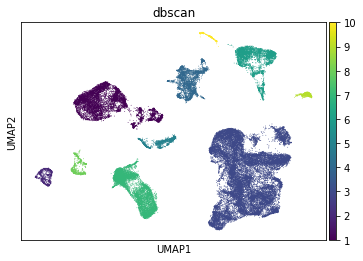

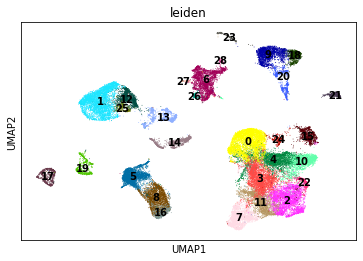

In [74]:
mit_data = sc.read_h5ad("scRNA_mit.h5ad")

sample2response={'620':'PD', '776_on':'PD','856_A':'PD','856_B':'PD',
                 '1224_post-FT':'PD', '1224_post-Cln':'PD',
                 '509_2':'R',
                 '509_post':'R',
                 '1227_pre':'R',
                 '1009_on':'R',
                 '1130':'R'}

mit_data.obs['response']=mit_data.obs['orig.ident'].map(sample2response)

##Missing NK cells
sc.pl.umap(mit_data, color=['dbscan'], legend_loc="on data")

sc.pp.neighbors(mit_data, n_neighbors=20, n_pcs=40)
sc.tl.leiden(mit_data,resolution=1)
sc.pl.umap(mit_data, color=['leiden'], legend_loc="on data")

mit_data.obs.loc[mit_data.obs['leiden'] == '7' , 'dbscan'] = 11

num2name={1:'Malignant',2:'Endothelial',3:'T cell', 4:'Macrophage',5:'Malignant',
          6:'B cell', 7: 'Malignant', 8:'CAF',9:'Dendritic',10:'Plasma B', 11:'NK'}

mit_data.obs['annotated_celltype']=mit_data.obs['dbscan'].map(num2name)

name2num={'Malignant':1, 'Endothelial':2, 'T cell':3, 
          'Macrophage':4, 'B cell':5,'CAF':6, 
          'Dendritic':7 ,'Plasma B':8, 'NK':9}

mit_data.obs['new_dbscan']=mit_data.obs['annotated_celltype'].map(name2num)

In [8]:
multi_data = sc.read_h5ad("maarten.h5ad")

In [9]:
multi_data_granular = sc.read_h5ad("maarten.granular.h5ad")

In [10]:
multi_data_granular

AnnData object with n_obs × n_vars = 65751 × 17881
    obs: 'nGene', 'nUMI', 'Subject', 'Location', 'Sample', 'Cluster', 'Health', 'cell_type'
    var: 'features'

In [11]:
multi_data

AnnData object with n_obs × n_vars = 65540 × 17881
    obs: 'nGene', 'nUMI', 'Subject', 'Location', 'Sample', 'Cluster', 'Health', 'cell_type', 'nCount_RNA', 'nFeature_RNA'
    var: 'features'

In [12]:
multi_data

AnnData object with n_obs × n_vars = 65540 × 17881
    obs: 'nGene', 'nUMI', 'Subject', 'Location', 'Sample', 'Cluster', 'Health', 'cell_type', 'nCount_RNA', 'nFeature_RNA'
    var: 'features'

In [13]:
sc.pp.normalize_total(multi_data, target_sum=1e4)
sc.pp.log1p(multi_data)

In [14]:
multi_data.obs

nGene    nUMI Subject Location    Sample  \
N10.EpiA.AAACGCACACAGCT    474  1144.0     N10      Epi  N10.EpiA   
N10.EpiA.AAACGCTGGTTCGA    697  1615.0     N10      Epi  N10.EpiA   
N10.EpiA.AAAGTTTGCCTAAG    652  1488.0     N10      Epi  N10.EpiA   
N10.EpiA.AAATCTGAGGTCTA    408   781.0     N10      Epi  N10.EpiA   
N10.EpiA.AACCTACTAGTTCG    568  1208.0     N10      Epi  N10.EpiA   
...                        ...     ...     ...      ...       ...   
N9.LPB.TGCTTAACGTTCGA     2495  8440.0      N9       LP    N9.LPB   
N9.LPB.TGGACTGACCTGAA     1319  3413.0      N9       LP    N9.LPB   
N9.LPB.TGGGTATGTCCTTA     1520  3975.0      N9       LP    N9.LPB   
N9.LPB.TGTACTTGCCGAAT      754  1603.0      N9       LP    N9.LPB   
N9.LPB.TTGCATTGGTCACA      546  1212.0      N9       LP    N9.LPB   

                                        Cluster    Health          cell_type  \
N10.EpiA.AAACGCACACAGCT               CD8+ IELs   Healthy        CD8+ T cell   
N10.EpiA.AAACGCTGGTTCGA               CD8+ IELs   Healthy        CD8+ T cell   
N10.EpiA.AAAGTTTGCCTAAG               CD8+ IELs   Healthy        CD8+ T cell   
N10.EpiA.AAATCTGAGGTCTA                 CD8+ LP   Healthy        CD8+ T cell   
N10.EpiA.AACCTACTAGTTCG               CD8+ IELs   Healthy        CD8+ T cell   
...                                         ...       ...                ...   
N9.LPB.TGCTTAACGTTCGA    Post-capillary Venules  Inflamed  Endothelial cells   
N9.LPB.TGGACTGACCTGAA    Post-capillary Venules  Inflamed  Endothelial cells   
N9.LPB.TGGGTATGTCCTTA           WNT2B+ Fos-lo 1  Inflamed        Fibroblasts   
N9.LPB.TGTACTTGCCGAAT           WNT2B+ Fos-lo 2  Inflamed        Fibroblasts   
N9.LPB.TTGCATTGGTCACA    Post-capillary Venules  Inflamed  Endothelial cells   

                         nCount_RNA  nFeature_RNA  
N10.EpiA.AAACGCACACAGCT      1144.0           474  
N10.EpiA.AAACGCTGGTTCGA      1615.0           697  
N10.EpiA.AAAGTTTGCCTAAG      1488.0           652  
N10.EpiA.AAATCTGAGGTCTA       781.0           408  
N10.EpiA.AACCTACTAGTTCG      1208.0           568  
...                             ...           ...  
N9.LPB.TGCTTAACGTTCGA           NaN   -2147483648  
N9.LPB.TGGACTGACCTGAA           NaN   -2147483648  
N9.LPB.TGGGTATGTCCTTA           NaN   -2147483648  
N9.LPB.TGTACTTGCCGAAT           NaN   -2147483648  
N9.LPB.TTGCATTGGTCACA           NaN   -2147483648  

[65540 rows x 10 columns]

In [15]:
sc.pp.highly_variable_genes(multi_data, n_top_genes = 10000)

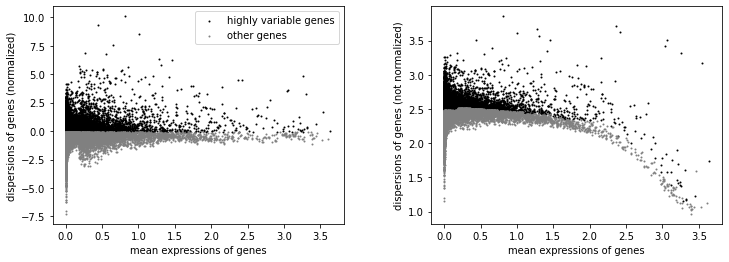

In [16]:
sc.pl.highly_variable_genes(multi_data)

In [17]:
multi_data.raw = multi_data  

In [18]:
multi_data = multi_data[:,multi_data.var.highly_variable]

In [19]:
sc.pp.scale(multi_data)

/Users/maartendevries/opt/anaconda3/envs/mars/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
len(Counter(multi_data.obs['cell_type']).keys())

9

### To avoid duplicate cell type labels, I make sure these labels have higher numbers (+100)

In [21]:
multi_numtoname = {i+100:name for i, name in enumerate( list(Counter(multi_data.obs['cell_type']).keys() ) ) }
multi_nametonum = {name:i+100 for i, name in enumerate( list(Counter(multi_data.obs['cell_type']).keys() ) ) }

In [22]:
multi_nametonum

{'CD8+ T cell': 100,
 'CD4+ T cell': 101,
 'NKs': 102,
 'B cell': 103,
 'Mast': 104,
 'Monocyte': 105,
 'Fibroblasts': 106,
 'Endothelial cells': 107,
 'Glia': 108}

In [23]:
multi_data.obs['numeric_cell_type'] = multi_data.obs['cell_type'].map(multi_nametonum)

In [24]:
multi_data.obs

nGene    nUMI Subject Location    Sample  \
N10.EpiA.AAACGCACACAGCT    474  1144.0     N10      Epi  N10.EpiA   
N10.EpiA.AAACGCTGGTTCGA    697  1615.0     N10      Epi  N10.EpiA   
N10.EpiA.AAAGTTTGCCTAAG    652  1488.0     N10      Epi  N10.EpiA   
N10.EpiA.AAATCTGAGGTCTA    408   781.0     N10      Epi  N10.EpiA   
N10.EpiA.AACCTACTAGTTCG    568  1208.0     N10      Epi  N10.EpiA   
...                        ...     ...     ...      ...       ...   
N9.LPB.TGCTTAACGTTCGA     2495  8440.0      N9       LP    N9.LPB   
N9.LPB.TGGACTGACCTGAA     1319  3413.0      N9       LP    N9.LPB   
N9.LPB.TGGGTATGTCCTTA     1520  3975.0      N9       LP    N9.LPB   
N9.LPB.TGTACTTGCCGAAT      754  1603.0      N9       LP    N9.LPB   
N9.LPB.TTGCATTGGTCACA      546  1212.0      N9       LP    N9.LPB   

                                        Cluster    Health          cell_type  \
N10.EpiA.AAACGCACACAGCT               CD8+ IELs   Healthy        CD8+ T cell   
N10.EpiA.AAACGCTGGTTCGA               CD8+ IELs   Healthy        CD8+ T cell   
N10.EpiA.AAAGTTTGCCTAAG               CD8+ IELs   Healthy        CD8+ T cell   
N10.EpiA.AAATCTGAGGTCTA                 CD8+ LP   Healthy        CD8+ T cell   
N10.EpiA.AACCTACTAGTTCG               CD8+ IELs   Healthy        CD8+ T cell   
...                                         ...       ...                ...   
N9.LPB.TGCTTAACGTTCGA    Post-capillary Venules  Inflamed  Endothelial cells   
N9.LPB.TGGACTGACCTGAA    Post-capillary Venules  Inflamed  Endothelial cells   
N9.LPB.TGGGTATGTCCTTA           WNT2B+ Fos-lo 1  Inflamed        Fibroblasts   
N9.LPB.TGTACTTGCCGAAT           WNT2B+ Fos-lo 2  Inflamed        Fibroblasts   
N9.LPB.TTGCATTGGTCACA    Post-capillary Venules  Inflamed  Endothelial cells   

                         nCount_RNA  nFeature_RNA  numeric_cell_type  
N10.EpiA.AAACGCACACAGCT      1144.0           474                100  
N10.EpiA.AAACGCTGGTTCGA      1615.0           697                100  
N10.EpiA.AAAGTTTGCCTAAG      1488.0           652                100  
N10.EpiA.AAATCTGAGGTCTA       781.0           408                100  
N10.EpiA.AACCTACTAGTTCG      1208.0           568                100  
...                             ...           ...                ...  
N9.LPB.TGCTTAACGTTCGA           NaN   -2147483648                107  
N9.LPB.TGGACTGACCTGAA           NaN   -2147483648                107  
N9.LPB.TGGGTATGTCCTTA           NaN   -2147483648                106  
N9.LPB.TGTACTTGCCGAAT           NaN   -2147483648                106  
N9.LPB.TTGCATTGGTCACA           NaN   -2147483648                107  

[65540 rows x 11 columns]

### Co-embed

In [25]:
xy, x_ind, y_ind = np.intersect1d(scatac.var_names,  multi_data.var_names, return_indices=True)

In [26]:
gene_intersection = np.intersect1d(xy, mit_data.var_names)

In [44]:
# Get the indices for all three datasets
_, _, mit_ind = np.intersect1d(gene_intersection,  mit_data.var_names, return_indices=True)
_, _, atac_ind = np.intersect1d(gene_intersection,  scatac.var_names, return_indices=True)
_, _, multi_ind = np.intersect1d(gene_intersection,  multi_data.var_names, return_indices=True)

In [64]:
# Colon
rna_y = multi_data.obs[['numeric_cell_type','cell_type']]
rna_y.columns=['dbscan','annotated_celltype']
rna_y = rna_y.copy()
rna_y['omic'] = 'RNA'

# MIT
mit_y = mit_data.obs[['new_dbscan','response','annotated_celltype']]
mit_y.columns=['dbscan','response','annotated_celltype']
mit_y = mit_y.copy()
mit_y['omic'] = 'RNA'

# ATAC
atac_y = scatac.obs[['dbscan','annotated_celltype']]
atac_y = atac_y.copy()
atac_y['omic'] = 'ATAC'

common_y = rna_y.append(atac_y)
common_y = common_y.append(mit_y)
common_y = common_y.copy()
common_y['annotation'] = common_y['annotated_celltype']+"_"+common_y['omic']

In [65]:
atac_y['dbscan'].shape

(43956,)

In [66]:
raw_mit = mit_data.X[:,mit_ind]
raw_rna = multi_data.X[:,multi_ind]
raw_atac = scatac.X[:,atac_ind]

In [67]:
common_matrix = np.concatenate((raw_rna, raw_atac), axis=0)

In [68]:
common_matrix = np.concatenate((raw_mit, common_matrix), axis=0)

In [69]:
raw_rna.shape, raw_atac.shape, raw_mit.shape, common_matrix.shape

((65540, 108), (43956, 108), (46089, 108), (155585, 108))

In [70]:
# Our colon data 'multi_data' and MIT data are annotated
annotated = ExperimentDataset(raw_rna, 
                              multi_data.obs.index, 
                              gene_intersection, 
                              'Annotated', rna_y['dbscan'])

# MIT scRNA-seq data
annotated_scrna = ExperimentDataset(raw_mit, 
                              mit_data.obs.index, 
                              gene_intersection, 
                              'Annotated', mit_y['dbscan'])

# ATAC-seq data is unannotated
unannotated = ExperimentDataset(raw_atac, 
                                scatac.obs.index, 
                                gene_intersection, 
                                'Unannotated', atac_y['dbscan'])

n_clusters= 11

params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device
params.epochs_pretrain = 50
params.pretrain_batch = 128
params.epochs = 30

== Dataset: Found 65540 items 
== Dataset: Found 9 classes
== Dataset: Found 46089 items 
== Dataset: Found 9 classes
== Dataset: Found 43956 items 
== Dataset: Found 9 classes


In [71]:
copretrain = ExperimentDataset(common_matrix, 
                               mit_data.obs.index.append(multi_data.obs.index).append(scatac.obs.index), 
                               gene_intersection,
                               'Unannotated')

### Co-embed wihtout choosing variable genes , normalized, log transformed, scaled, pre train for 50 epochs, 

In [72]:
params.epochs_pretrain = 30
params.learning_rate = 1e-4
vae_merge_mars_copre = VAE_MARS(11, params, [annotated, annotated_scrna] , unannotated, copretrain, 
                
                ##These are roll over parametesr form original model 
                hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=1e-3,
                
                ##VAE MARS specific parameters
                latent_dim = 50 , n_feature = len(xy), 
                
                network_architecture={"n_hidden_recog_1": 250, 
                                      "n_hidden_recog_2": 100,
                                      "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                      "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                
                lambda_reconstruct = 1, lambda_kl = 1e-2)

vae_merge_adata_copre, vae_merge_landmarks_copre, vae_merge_scores_copre , vae_merge_training_history_copre, vae_merge_latent_tracker_copre, pretrainlatent, pretrainloss = vae_merge_mars_copre.train(evaluation_mode=True,
                                                                                                                               save_all_embeddings=True)

Pretraining..


RuntimeError: size mismatch, m1: [128 x 108], m2: [488 x 250] at /tmp/pip-req-build-9oilk29k/aten/src/TH/generic/THTensorMath.cpp:197

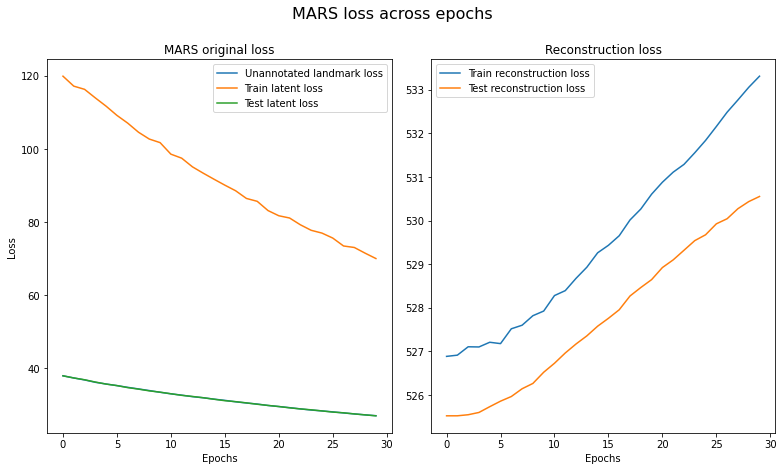

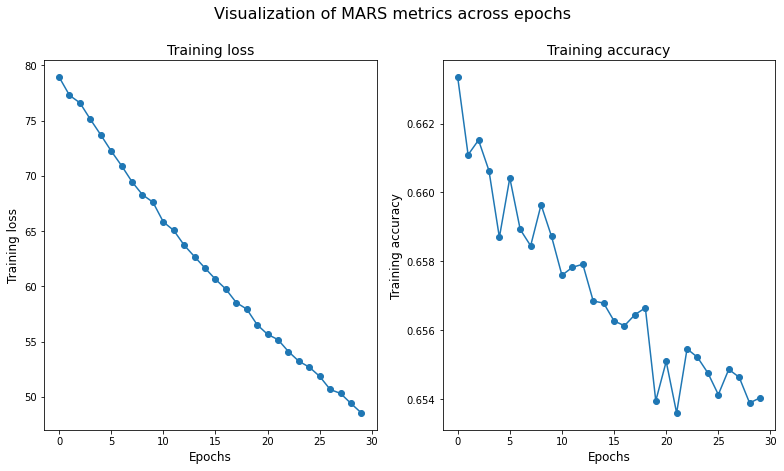

In [53]:
MARS_loss_tracker (vae_merge_training_history_copre, save = True)
MARS_history (vae_merge_training_history_copre, save = True)

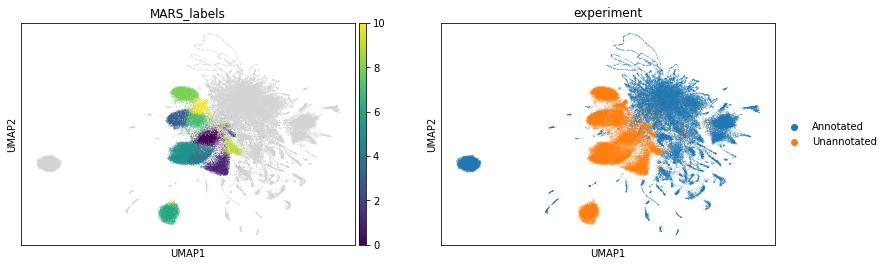

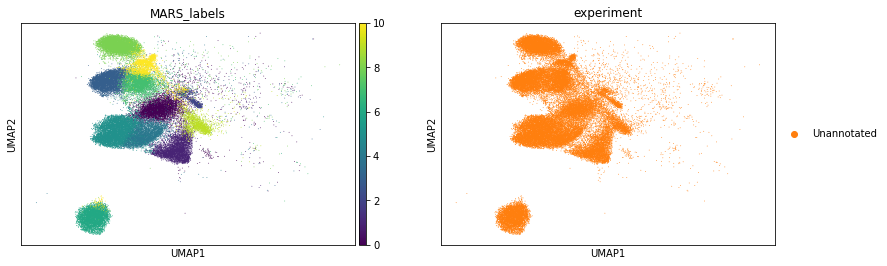

In [54]:
MARS_latent_umap(vae_merge_adata_copre, plot_gene_list = ['MARS_labels','experiment'], save = False)

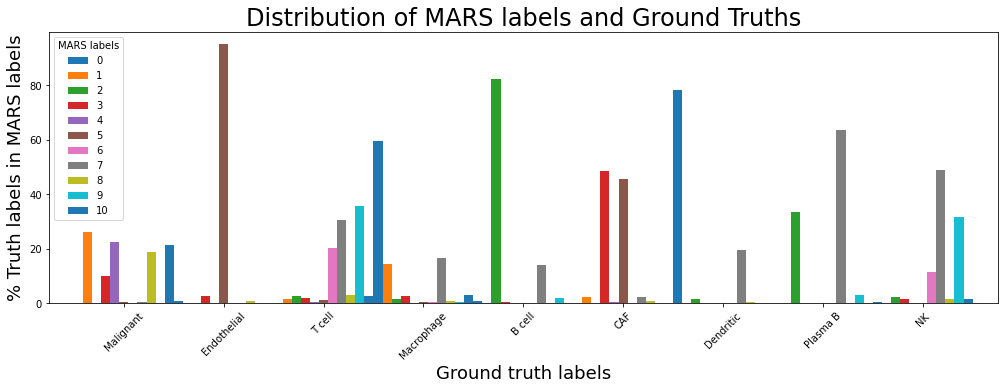

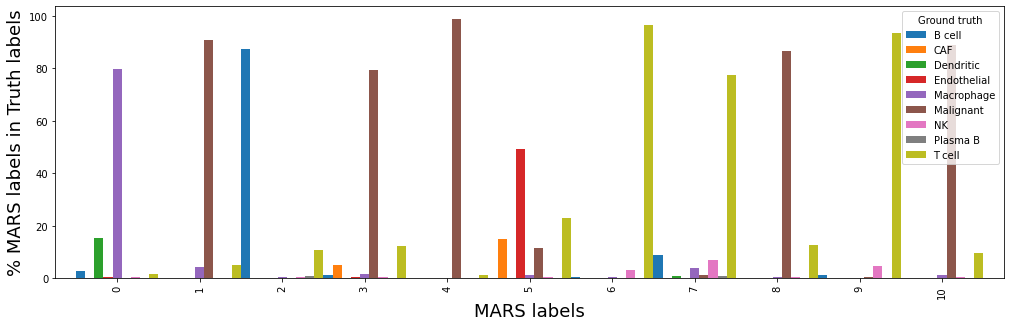

In [21]:
cell_type_assign(vae_merge_adata_copre, save = True)

In [22]:
vae_merge_scores_copre

{'nmi': 0.4578997284822993,
 'f1_score': 0.36733750417067645,
 'adj_mi': 0.4576178446667358,
 'precision': 0.4581100193506432,
 'accuracy': 0.37316862316862315,
 'recall': 0.4401355235562956,
 'adj_rand': 0.25030890735029454}

Trying to set attribute `.obs` of view, copying.
... storing 'label_name' as categorical


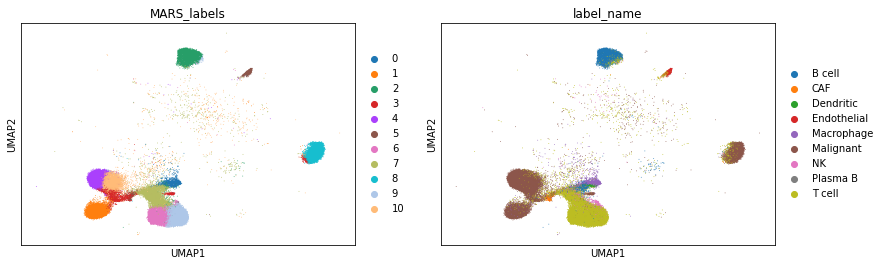

In [24]:
sc.pl.umap(vae_merge_adata_copre[vae_merge_adata_copre.obs['experiment']=="Unannotated"], 
           color=["MARS_labels",'label_name'],save=".pdf")

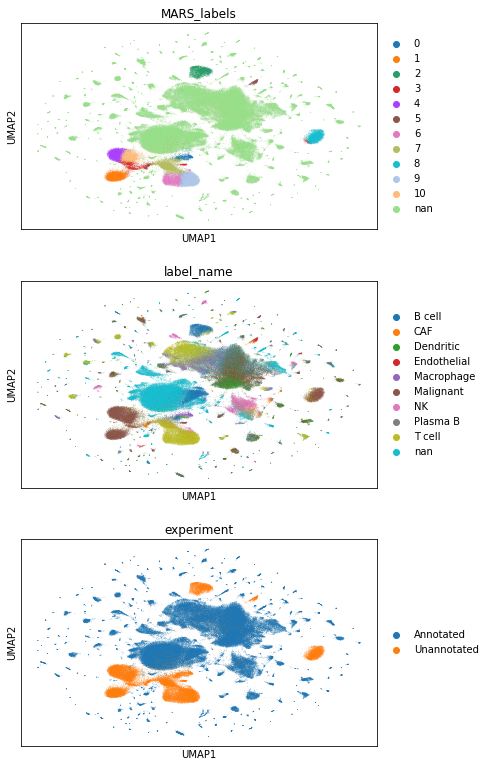

In [26]:
sc.pl.umap(vae_merge_adata_copre, 
           color=["MARS_labels",'label_name','experiment'],ncols=1,save=".pdf")

### tried three types of cell type annotations:
1. Sections by sections
2. All at once
3. One by one 

In [27]:
subset  = vae_merge_adata_copre[(vae_merge_adata_copre.obs['experiment']=='Annotated')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='2')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='6')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='7')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='9')]

In [28]:
mars_vae_celltype= vae_merge_mars_copre.name_cell_types(subset , 
                                                        vae_merge_landmarks_copre,
                                                        list(multi_nametonum.keys()),
                                                        umap_reduce_dim=True)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"



Cluster label: 2
ILC: 2.1108265505416418e-13
HSPC: 8.344909145669568e-13
B memory: 2.0091219373051896e-07
B intermediate: 0.0009604076129174911
B naive: 0.9990393914738392

Cluster label: 6
NK_CD56bright: 0.0034421618000254678
HSPC: 0.013734672611544499
ILC: 0.050091184043915854
MAIT: 0.09320134504661784
B naive: 0.833127923783191

Cluster label: 7
CD8 TEM: 0.07012081198702673
CD8 Proliferating: 0.08183758613959635
NK_CD56bright: 0.08440637947082169
B naive: 0.11679706215030314
ILC: 0.13415982817504923

Cluster label: 9
HSPC: 4.822239356632801e-19
B intermediate: 1.39527692756658e-15
ILC: 4.720088717354129e-15
MAIT: 4.972900422453727e-12
B naive: 0.9999999999950211


In [29]:
subset  = vae_merge_adata_copre[(vae_merge_adata_copre.obs['experiment']=='Annotated')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='1')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='3')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='4')|(vae_merge_adata_copre.obs['MARS_labels']=='8')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='10')
                               ]

In [30]:
mars_vae_celltype= vae_merge_mars_copre.name_cell_types(subset , 
                                                        vae_merge_landmarks_copre,
                                                        list(multi_nametonum.keys()),
                                                        umap_reduce_dim=True)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"



Cluster label: 1
Eryth: 8.317567985420361e-06
B memory: 1.876505320889134e-05
B naive: 1.893288046609104e-05
ILC: 0.0052369858052246495
HSPC: 0.9946849825119045

Cluster label: 10
Treg: 0.0574277197186939
dnT: 0.06966554779430104
HSPC: 0.0812131952333454
Eryth: 0.13342900498026652
ILC: 0.18811601274665787

Cluster label: 3
CD4 TCM: 0.0020911303391663865
Platelet: 0.004719278429452853
Eryth: 0.05416527166357076
ILC: 0.09922024850800164
HSPC: 0.8261830095110047

Cluster label: 4
Treg: 0.000602021898970758
Platelet: 0.0007003155733774863
dnT: 0.0018255224535891218
ILC: 0.07256784469064255
Eryth: 0.923576821863976

Cluster label: 8
Platelet: 2.5677074277853392e-23
ILC: 5.234980199157674e-18
cDC1: 7.701249241327688e-18
Eryth: 2.15044100160423e-15
HSPC: 0.9999999999999979


In [31]:
subset  = vae_merge_adata_copre[(vae_merge_adata_copre.obs['experiment']=='Annotated')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='0')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='4')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='5')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='6')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='7')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='9')
                               ]
mars_vae_celltype= vae_merge_mars_copre.name_cell_types(subset , 
                                                        vae_merge_landmarks_copre,
                                                        list(multi_nametonum.keys()),
                                                        umap_reduce_dim=True)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"



Cluster label: 0
Platelet: 0.026695424086998248
Plasmablast: 0.10021643952572205
cDC1: 0.12169858929857469
cDC2: 0.16682336791890945
Eryth: 0.5745144209465133

Cluster label: 4
ILC: 0.0003606689079147697
cDC2: 0.005832875955015697
cDC1: 0.028713542773516586
MAIT: 0.20546538844182347
Plasmablast: 0.7588415078134448

Cluster label: 5
NK_CD56bright: 3.153207525655264e-05
ASDC: 3.7953291629571336e-05
cDC2: 0.00252386507886215
cDC1: 0.3685287076485077
Eryth: 0.6288774212776413

Cluster label: 6
HSPC: 0.005932171248326798
ILC: 0.0316353419583217
B naive: 0.12933905846365354
NK_CD56bright: 0.20155139156349475
MAIT: 0.6199604948028744

Cluster label: 7
CD8 TEM: 0.0879016656332193
CD8 Proliferating: 0.08894706043984886
gdT: 0.09761820383065861
ILC: 0.11736358378129826
NK_CD56bright: 0.15748669797336554

Cluster label: 9
B naive: 2.2930729749334578e-05
ILC: 8.976196554434399e-05
HSPC: 0.0001164818421717114
NK_CD56bright: 0.08138164861787374
MAIT: 0.9183575471221166


In [32]:
mars_vae_celltype= vae_merge_mars_copre.name_cell_types(vae_merge_adata_copre , 
                                                        vae_merge_landmarks_copre,
                                                        list(multi_nametonum.keys()),
                                                        umap_reduce_dim=True)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"



Cluster label: 0
CD14 Mono: 0.0036375606689048163
CD16 Mono: 0.004276737878007137
Doublet: 0.004826472875934596
cDC1: 0.0321133608012689
cDC2: 0.9536920525259731

Cluster label: 1
Platelet: 0.0016027995046890278
Eryth: 0.001648453450149473
ASDC: 0.004015663002634186
ILC: 0.08571998492060919
HSPC: 0.9061973495208573

Cluster label: 10
CD4 Proliferating: 0.047139494845012876
dnT: 0.048456874074561625
HSPC: 0.06874118550406676
Eryth: 0.09595127657442104
ILC: 0.35470436917005016

Cluster label: 2
ILC: 0.00011776372282644302
B naive: 0.009143650338558254
ASDC: 0.017356190706560935
cDC1: 0.0646045867225788
cDC2: 0.9087505461602531

Cluster label: 3
Eryth: 0.030211983928698043
NK_CD56bright: 0.04698897246129961
ASDC: 0.049388791857555986
HSPC: 0.3425575742300268
ILC: 0.4263580438574788

Cluster label: 4
Platelet: 9.568734733839331e-05
dnT: 0.00028486746713091615
HSPC: 0.006289336392776398
Eryth: 0.10951388560430401
ILC: 0.8836588234192162

Cluster label: 5
NK Proliferating: 5.570852407672522

In [ ]:
subset  = vae_merge_adata_copre[(vae_merge_adata_copre.obs['experiment']=='Annotated')|
                                (vae_merge_adata_copre.obs['MARS_labels']=='2')]
mars_vae_celltype= vae_merge_mars_copre.name_cell_types(subset , 
                                                        vae_merge_landmarks_copre,
                                                        list(multi_nametonum.keys()),
                                                        umap_reduce_dim=True)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


### Co-embed without filtering 

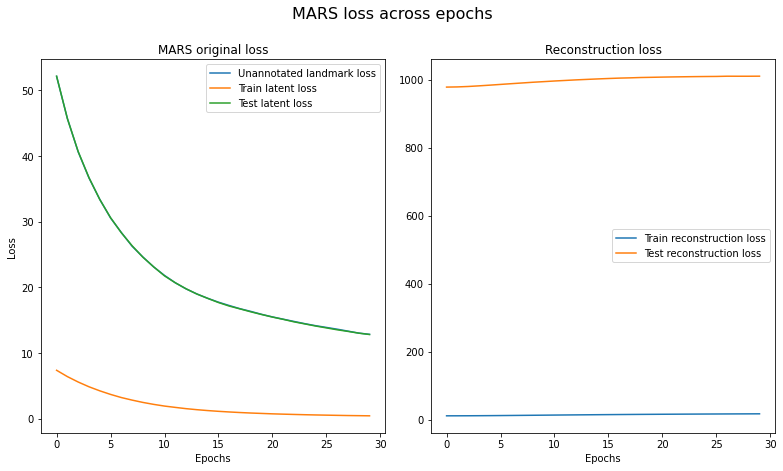

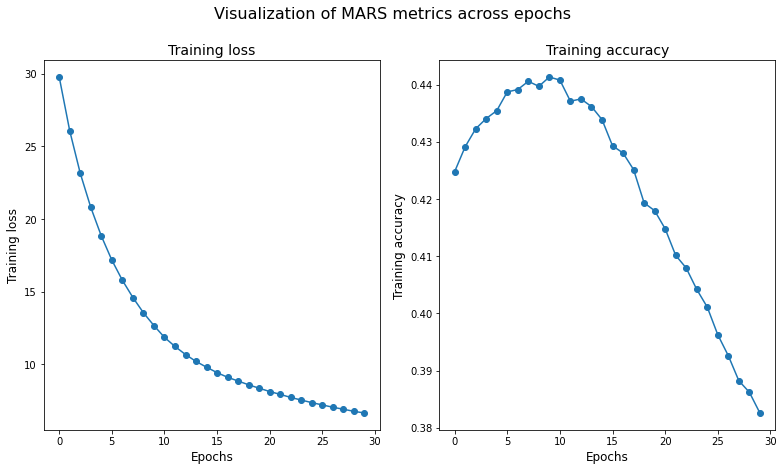

In [21]:
MARS_loss_tracker (vae_merge_training_history_copre, save = True)
MARS_history (vae_merge_training_history_copre, save = True)

... storing 'MARS_labels' as categorical


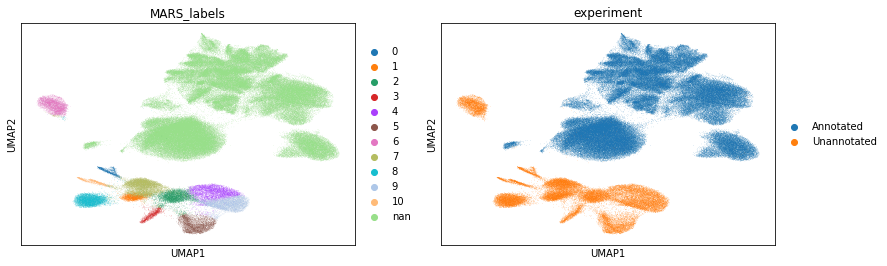

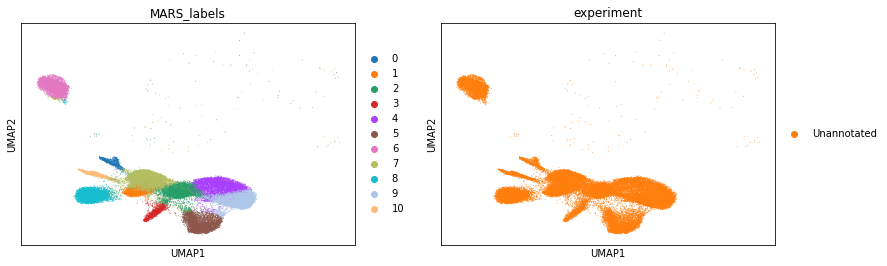

In [23]:
MARS_latent_umap(vae_merge_adata_copre, plot_gene_list = ['MARS_labels','experiment'], save = False)

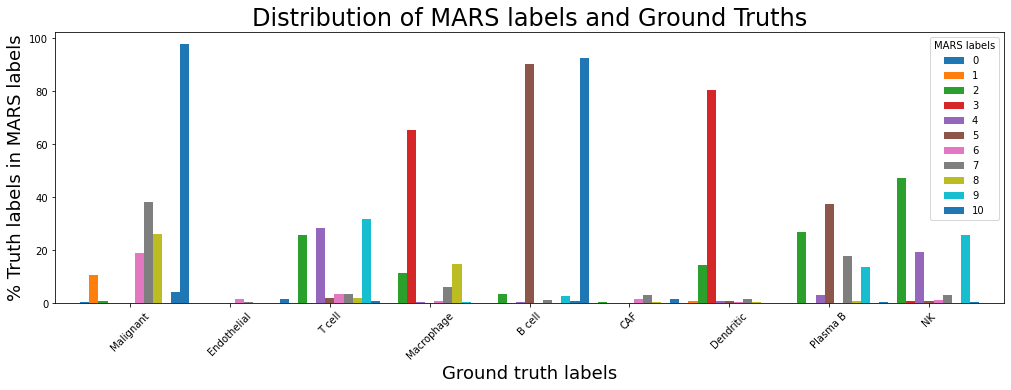

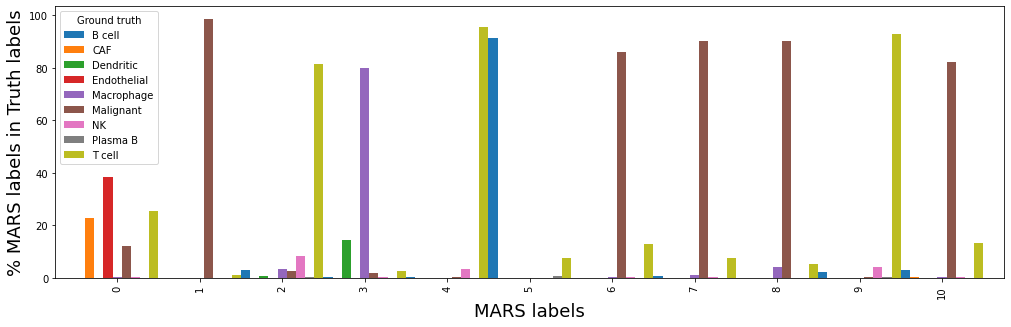

In [24]:
cell_type_assign(vae_merge_adata_copre, save = True)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'label_name' as categorical


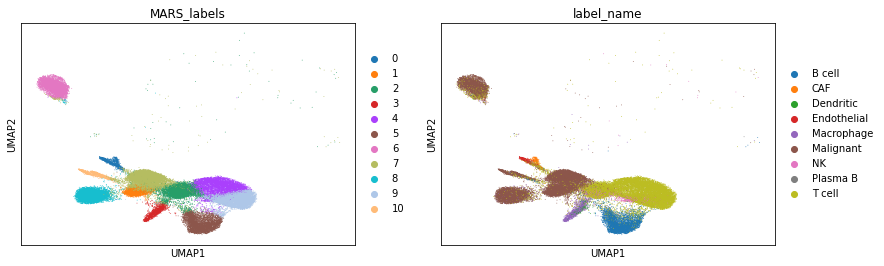

In [25]:
sc.pl.umap(vae_merge_adata_copre[vae_merge_adata_copre.obs.experiment=="Unannotated"], 
           color=['MARS_labels', 'label_name'], ncols=2, save=".pdf")

In [22]:
vae_merge_scores_copre

{'recall': 0.41856706374599173,
 'adj_rand': 0.28379670196321816,
 'accuracy': 0.4216716716716717,
 'f1_score': 0.3706767540752869,
 'precision': 0.4456627765410403,
 'nmi': 0.4765884205692177,
 'adj_mi': 0.476311864188214}

In [31]:
subset  = vae_merge_adata_copre[(vae_merge_adata_copre.obs['experiment']=='Annotated')|
                          (vae_merge_adata_copre.obs['MARS_labels']=='1')|(vae_merge_adata_copre.obs['MARS_labels']=='6')|
                          (vae_merge_adata_copre.obs['MARS_labels']=='7')|(vae_merge_adata_copre.obs['MARS_labels']=='8')|
                          (vae_merge_adata_copre.obs['MARS_labels']=='10')]

In [34]:
mars_vae_celltype= vae_merge_mars_copre.name_cell_types(subset , 
                                                        vae_merge_landmarks_copre,
                                                        list(multi_nametonum.keys()),
                                                        umap_reduce_dim=True)


Cluster label: 1
ASDC: 3.2629465306321583e-71
HSPC: 3.310463538032412e-70
cDC2: 1.6314221227516285e-46
Platelet: 8.657843806456948e-46
cDC1: 1.0

Cluster label: 10
HSPC: 8.271867488218612e-14
ASDC: 1.227449513048267e-12
cDC2: 2.8455533349093218e-08
Platelet: 2.8887089424873253e-08
cDC1: 0.9999999426559251

Cluster label: 6
ILC: 1.774320848640958e-09
CD8 Naive: 1.9219458363423033e-09
HSPC: 1.4703780520198791e-05
CD4 Proliferating: 0.4001577753109962
Platelet: 0.5998275126694906

Cluster label: 7
pDC: 0.0008238680552984677
ASDC: 0.0016728934582850622
Platelet: 0.0056423114417814635
cDC2: 0.016340579629639355
cDC1: 0.969997933922869

Cluster label: 8
Eryth: 3.1075160638376476e-08
HSPC: 7.559222436276683e-08
cDC2: 4.132946057440858e-05
Platelet: 5.80100502238579e-05
cDC1: 0.9999004793140132


In [35]:
subset  = vae_merge_adata_copre[(vae_merge_adata_copre.obs['experiment']=='Annotated')|
                          (vae_merge_adata_copre.obs['MARS_labels']=='0')|(vae_merge_adata_copre.obs['MARS_labels']=='2')|
                          (vae_merge_adata_copre.obs['MARS_labels']=='3')|(vae_merge_adata_copre.obs['MARS_labels']=='4')|
                          (vae_merge_adata_copre.obs['MARS_labels']=='5')|(vae_merge_adata_copre.obs['MARS_labels']=='9')]

In [36]:
mars_vae_celltype= vae_merge_mars_copre.name_cell_types(subset , 
                                                        vae_merge_landmarks_copre,
                                                        list(multi_nametonum.keys()),
                                                        umap_reduce_dim=True)


Cluster label: 0
NK Proliferating: 5.033907796350596e-37
gdT: 6.732063029503064e-36
Plasmablast: 2.769807069020753e-30
HSPC: 5.091897968219335e-24
Platelet: 1.0

Cluster label: 2
HSPC: 0.0027668130080012615
NK: 0.003829303109334106
CD8 TEM: 0.005800791575601024
gdT: 0.009046701884520286
Platelet: 0.9652495545917493

Cluster label: 3
HSPC: 2.7192533572502325e-14
cDC1: 4.2650335678661785e-14
ASDC: 5.113517790996515e-14
cDC2: 1.2385691376213946e-13
Platelet: 0.9999999999997283

Cluster label: 4
Eryth: 6.181431341018886e-05
HSPC: 7.872233121875436e-05
CD8 TEM: 0.0003787984535951857
gdT: 0.0009758558699044449
Platelet: 0.9984771927759732

Cluster label: 5
CD4 CTL: 5.3302365470724894e-11
Plasmablast: 1.1973979969994422e-10
Eryth: 1.4485431388306036e-09
HSPC: 2.7006750709027204e-08
Platelet: 0.999999971253831

Cluster label: 9
CD4 CTL: 2.03892911243342e-10
HSPC: 1.216151617568036e-08
CD8 TEM: 3.711613991044554e-08
gdT: 1.1004196696514641e-07
Platelet: 0.9999998400576671


... storing 'label_name' as categorical


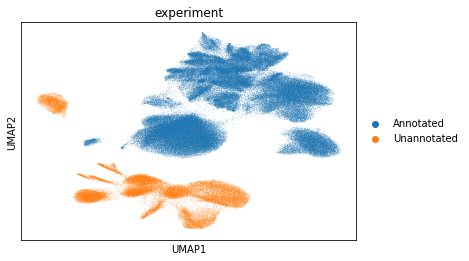

In [37]:
sc.pl.umap(vae_merge_adata_copre,
           color=['experiment'], ncols=2, save=".pdf")

### scRNA meta with fltered and sclaed data --> does not do well with scATAC

In [24]:
annotated = ExperimentDataset(raw_rna, 
                              multi_data.obs.index, 
                              xy, 
                              'Annotated', rna_y['dbscan'])

unannotated = ExperimentDataset(raw_atac, 
                                scatac.obs.index, 
                                xy, 
                                'Unannotated', atac_y['dbscan'])

pretrain = ExperimentDataset(raw_atac, 
                             scatac.obs.index, 
                             xy,
                             'Unannotated')

n_clusters= 11

params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device
params.epochs_pretrain = 30
params.pretrain_batch = 128
params.epochs = 30

== Dataset: Found 161764 items 
== Dataset: Found 31 classes
== Dataset: Found 43956 items 
== Dataset: Found 9 classes


In [26]:
vae_merge_mars = VAE_MARS(n_clusters, params, [annotated] , unannotated, pretrain, 
                
                ##These are roll over parametesr form original model 
                hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=1e-3,
                
                ##VAE MARS specific parameters
                latent_dim = 50 , n_feature = len(xy), 
                
                network_architecture={"n_hidden_recog_1": 250, 
                                      "n_hidden_recog_2": 100,
                                      "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                      "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                
                lambda_reconstruct = 1, lambda_kl = 4)

vae_merge_adata, vae_merge_landmarks, vae_merge_scores , vae_merge_training_history, vae_merge_latent_tracker, pretrainlatent, pretrainloss = vae_merge_mars.train(evaluation_mode=True,
                                                                                                                               save_all_embeddings=True)

Pretraining..
Pretraining Epoch 0, Loss: 557.2255859375
Time:  2.6214449405670166
Pretraining Epoch 1, Loss: 602.79150390625
Time:  2.581331253051758
Pretraining Epoch 2, Loss: 646.85107421875
Time:  2.6031742095947266
Pretraining Epoch 3, Loss: 551.4714965820312
Time:  2.7654192447662354
Pretraining Epoch 4, Loss: 563.95068359375
Time:  2.6419124603271484
Pretraining Epoch 5, Loss: 602.7904663085938
Time:  2.995549201965332
Pretraining Epoch 6, Loss: 547.3012084960938
Time:  3.5520567893981934
Pretraining Epoch 7, Loss: 618.1930541992188
Time:  3.6316866874694824
Pretraining Epoch 8, Loss: 536.3419189453125
Time:  3.1525931358337402
Pretraining Epoch 9, Loss: 565.10400390625
Time:  2.7258553504943848
Pretraining Epoch 10, Loss: 536.5846557617188
Time:  2.715733289718628
Pretraining Epoch 11, Loss: 538.14111328125
Time:  2.609510660171509
Pretraining Epoch 12, Loss: 581.8216552734375
Time:  2.6187639236450195
Pretraining Epoch 13, Loss: 586.91845703125
Time:  2.6363203525543213
Pretrai

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


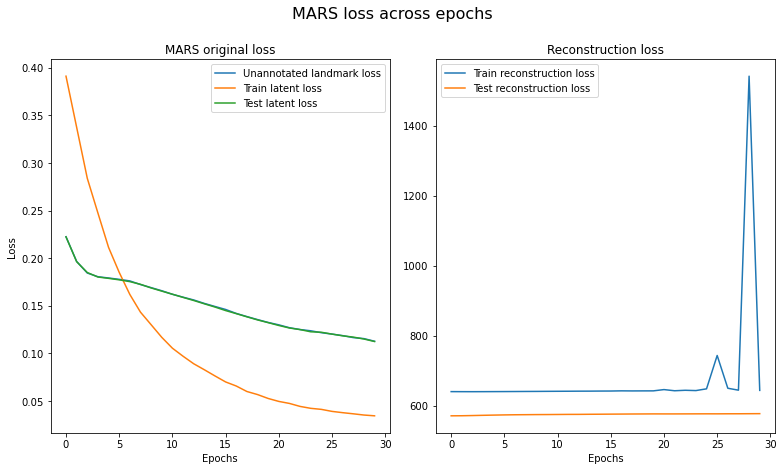

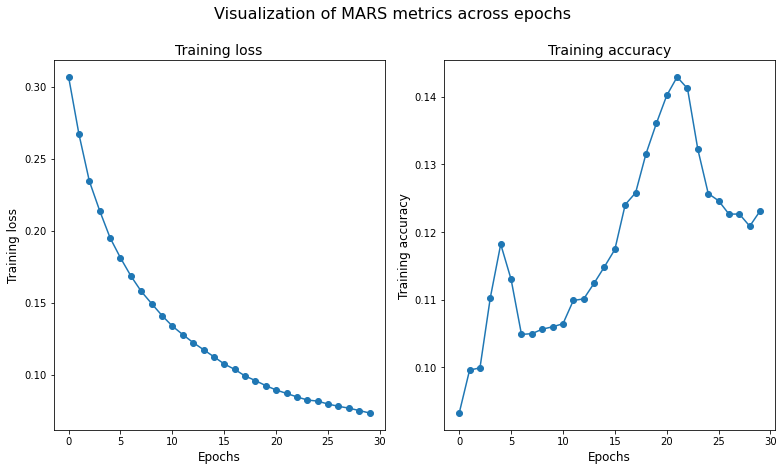

In [27]:
MARS_loss_tracker (vae_merge_training_history, save = True)
MARS_history (vae_merge_training_history, save = True)

... storing 'MARS_labels' as categorical


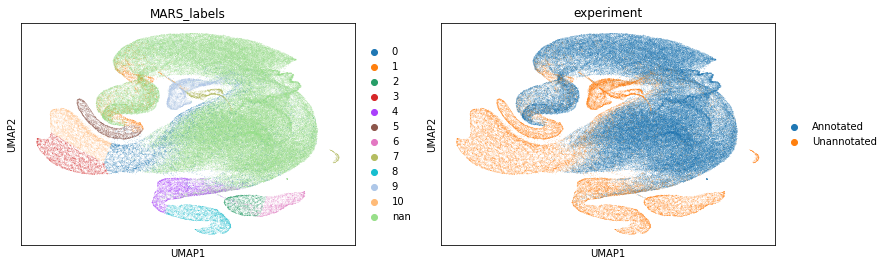

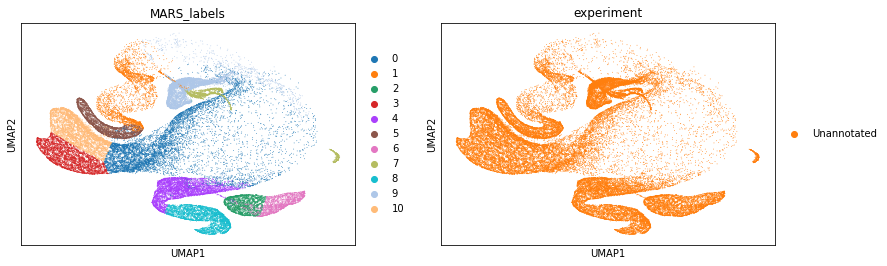

In [29]:
MARS_latent_umap(vae_merge_adata, plot_gene_list = ['MARS_labels','experiment'], save =False)

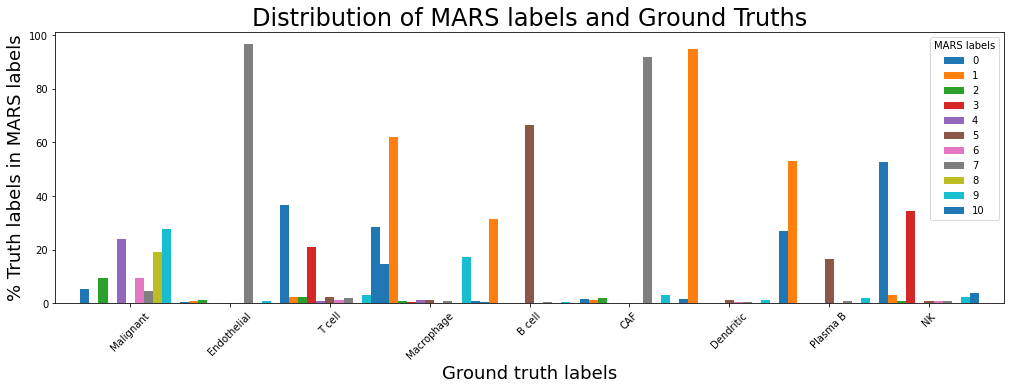

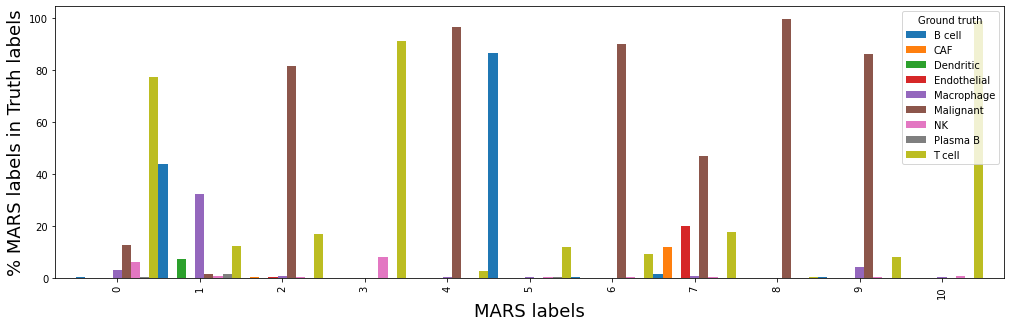

In [30]:
cell_type_assign(vae_merge_adata, save=True)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'label_name' as categorical


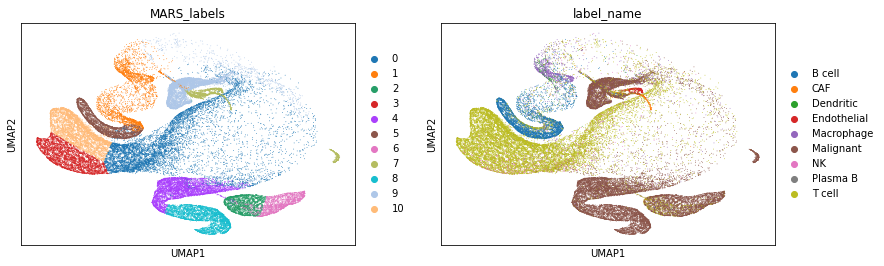

In [31]:
sc.pl.umap(vae_merge_adata[vae_merge_adata.obs.experiment=="Unannotated"], 
           color=['MARS_labels', 'label_name'], ncols=2, save=".pdf")

In [28]:
vae_merge_scores

{'f1_score': 0.28552784417489757,
 'accuracy': 0.3657748657748658,
 'adj_rand': 0.2275434260087375,
 'precision': 0.34637513048796525,
 'nmi': 0.4286497584730748,
 'recall': 0.36298128058369644,
 'adj_mi': 0.42835605123388365}

In [ ]:
subset  = vae_merge_adata[(vae_merge_adata.obs['experiment']=='Annotated')|
                          (vae_merge_adata.obs['MARS_labels']==1)|
                          (vae_merge_adata.obs['MARS_labels']==7)|
                          (vae_merge_adata.obs['MARS_labels']==9) ]

mars_vae_celltype= vae_merge_mars.name_cell_types(subset , 
                                                  vae_merge_landmarks, 
                                                  list(multi_nametonum.keys()),
                                                  umap_reduce_dim=False)

### scATAC with unnormalized and unfiltered gene list 

In [22]:
vae_merge_mars = VAE_MARS(n_clusters, params, [annotated] , unannotated, pretrain, 
                
                ##These are roll over parametesr form original model 
                hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=1e-3,
                
                ##VAE MARS specific parameters
                latent_dim = 50 , n_feature = len(xy), 
                
                network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                           "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                           "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                
                lambda_reconstruct = 1, lambda_kl = 4)

vae_merge_adata, vae_merge_landmarks, vae_merge_scores , vae_merge_training_history, vae_merge_latent_tracker, pretrainlatent, pretrainloss = vae_merge_mars.train(evaluation_mode=True,
                                                                                                                               save_all_embeddings=True)

Pretraining..
Pretraining Epoch 0, Loss: 1054.6746826171875
Time:  2.889103889465332
Pretraining Epoch 1, Loss: 1113.508544921875
Time:  2.902864694595337
Pretraining Epoch 2, Loss: 1041.6195068359375
Time:  3.0015015602111816
Pretraining Epoch 3, Loss: 975.0137939453125
Time:  2.96067214012146
Pretraining Epoch 4, Loss: 1064.2733154296875
Time:  2.902724266052246
Pretraining Epoch 5, Loss: 1008.3711547851562
Time:  2.800198793411255
Pretraining Epoch 6, Loss: 1051.560546875
Time:  2.801445960998535
Pretraining Epoch 7, Loss: 1002.0578002929688
Time:  2.9744760990142822
Pretraining Epoch 8, Loss: 1104.7939453125
Time:  3.0562617778778076
Pretraining Epoch 9, Loss: 1134.1024169921875
Time:  3.288109302520752
Pretraining Epoch 10, Loss: 968.0147094726562
Time:  3.0357565879821777
Pretraining Epoch 11, Loss: 919.2252807617188
Time:  2.9304451942443848
Pretraining Epoch 12, Loss: 1057.1866455078125
Time:  2.97397780418396
Pretraining Epoch 13, Loss: 1122.1715087890625
Time:  2.977333307266

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


... storing 'MARS_labels' as categorical


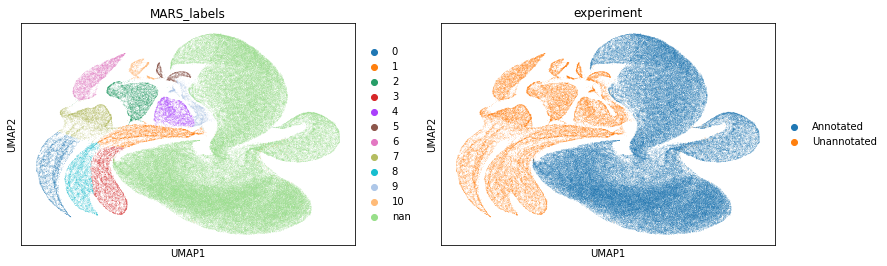

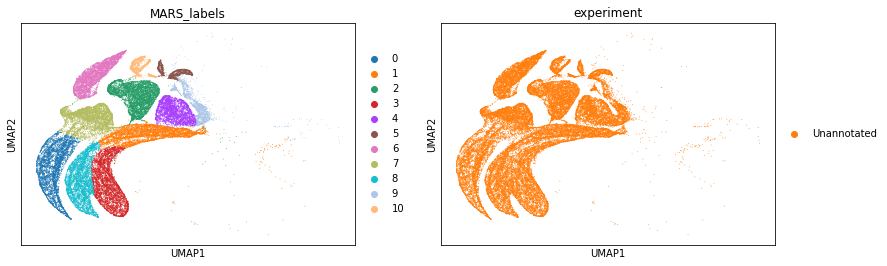

In [61]:
MARS_latent_umap(vae_merge_adata, plot_gene_list = ['MARS_labels','experiment'], save =False)

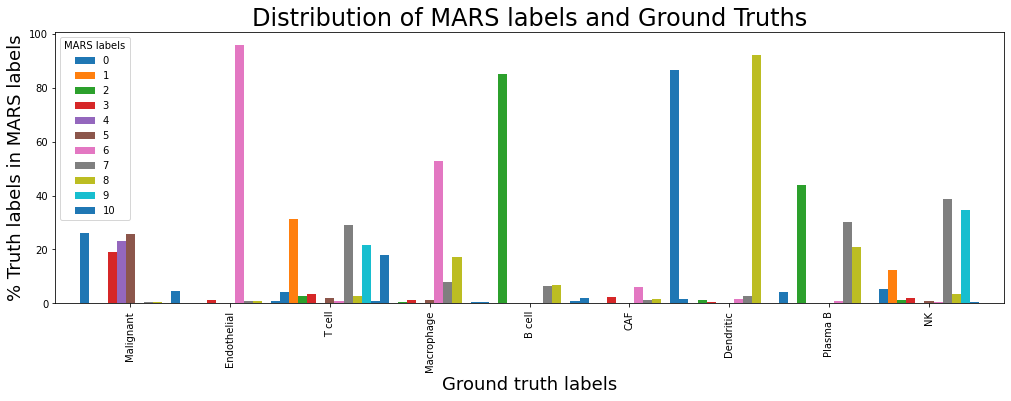

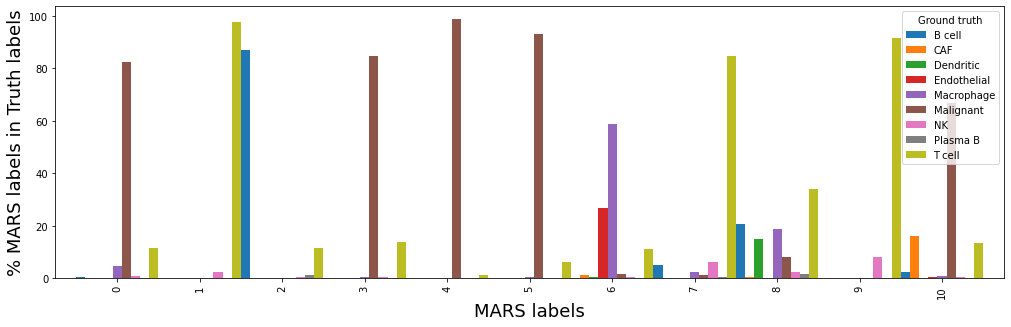

In [53]:
cell_type_assign(vae_merge_adata, save=True)

... storing 'MARS_labels' as categorical
... storing 'label_name' as categorical


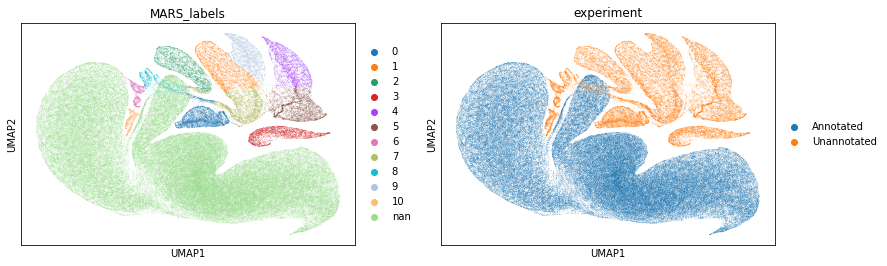

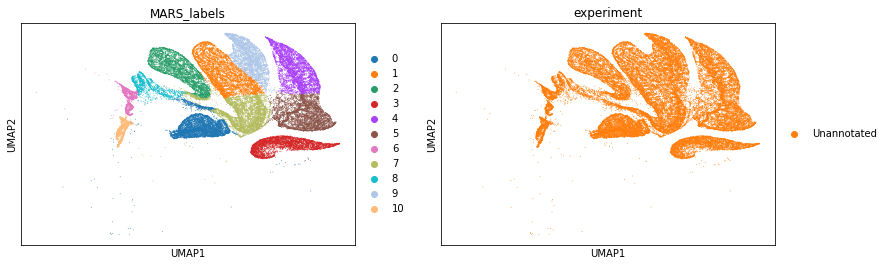

In [54]:
MARS_latent_umap(vae_merge_adata, plot_gene_list = ['MARS_labels','experiment'], save =True)

Trying to set attribute `.uns` of view, copying.


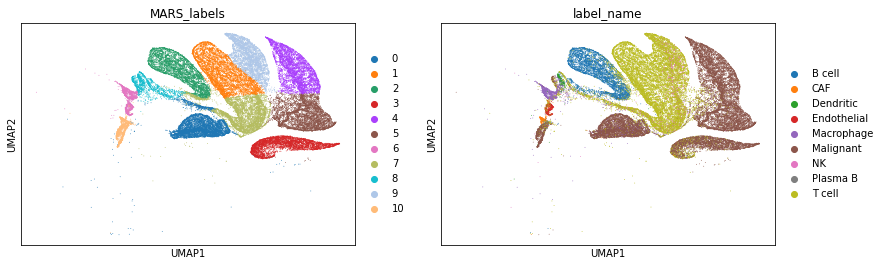

In [55]:
sc.pl.umap(vae_merge_adata[vae_merge_adata.obs.experiment=="Unannotated"], 
           color=['MARS_labels', 'label_name'], ncols=2, save=".png")

In [56]:
vae_merge_scores

{'recall': 0.46017661509303426,
 'adj_mi': 0.45099077769688223,
 'accuracy': 0.35446810446810445,
 'nmi': 0.45127444947252515,
 'f1_score': 0.3248890252361682,
 'adj_rand': 0.25084320065677346,
 'precision': 0.4036404894470712}

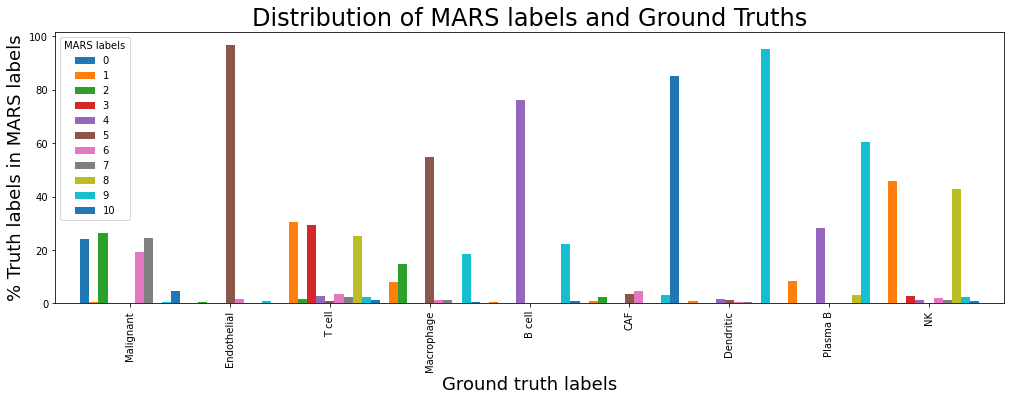

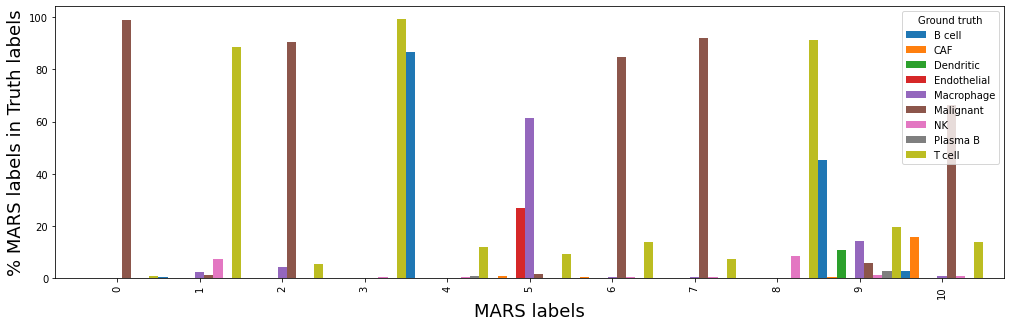

In [68]:
cell_type_assign(vae_merge_adata, save=True)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'label_name' as categorical


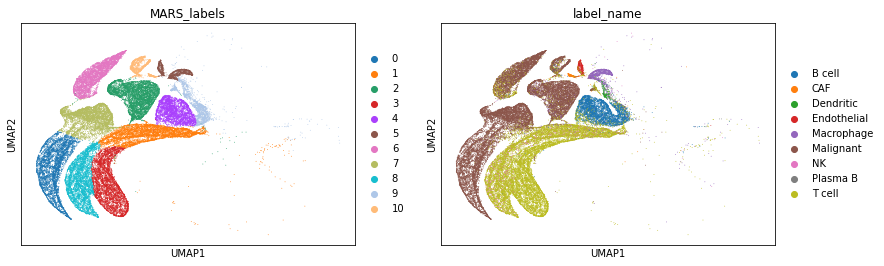

In [70]:
sc.pl.umap(vae_merge_adata[vae_merge_adata.obs.experiment=="Unannotated"], 
           color=['MARS_labels', 'label_name'], ncols=2, save=".png")

In [67]:
vae_merge_scores

{'recall': 0.4584015512695499,
 'precision': 0.40216966627185324,
 'accuracy': 0.34489034489034487,
 'adj_rand': 0.2606582058151187,
 'nmi': 0.47536228299569644,
 'f1_score': 0.3168069421701877,
 'adj_mi': 0.4750926244525107}

### Cell type labeling 

In [46]:
subset  = vae_merge_adata[(vae_merge_adata.obs['experiment']=='Annotated')|(vae_merge_adata.obs['MARS_labels']==1)|(vae_merge_adata.obs['MARS_labels']==7)|(vae_merge_adata.obs['MARS_labels']==9) ]
subset

View of AnnData object with n_obs × n_vars = 176795 × 1136
    obs: 'truth_labels', 'MARS_labels', 'experiment', 'label_name'
    obsm: 'MARS_embedding'

In [49]:
mars_vae_celltype_Tcell= vae_merge_mars.name_cell_types(subset , 
                                                        vae_merge_landmarks, 
                                                        list(multi_nametonum.keys()))


Cluster label: 1
NK Proliferating: 0.04526247204082158
CD4 CTL: 0.10817991523615837
ILC: 0.1101146246039738
HSPC: 0.13506283359856053
MAIT: 0.16125576569148595

Cluster label: 7
NK_CD56bright: 0.060299801304473453
CD8 Proliferating: 0.06919177867903388
NK: 0.08851768202422958
Plasmablast: 0.1115135512985712
NK Proliferating: 0.5410051263711328

Cluster label: 9
MAIT: 0.07465991536030471
CD4 TEM: 0.07523624335017186
Eryth: 0.09474575105819935
CD4 CTL: 0.10229912490275829
HSPC: 0.20503798254433941


In [50]:
mars_vae_celltype_Tcell= vae_merge_mars.name_cell_types(subset , 
                                                        vae_merge_landmarks, 
                                                        list(multi_nametonum.keys()),
                                                        umap_reduce_dim=False)


Cluster label: 1
NK Proliferating: 0.07659745590192751
gdT: 0.13117476650350515
CD8 TEM: 0.1346736583045785
NK_CD56bright: 0.18009453676891843
NK: 0.28932784995239186

Cluster label: 7
CD8 TEM: 0.07147276144908174
gdT: 0.0730549466318942
NK Proliferating: 0.08146339919680756
NK_CD56bright: 0.09509742925619652
NK: 0.09804657320098467

Cluster label: 9
MAIT: 0.07478094051771712
CD4 CTL: 0.07862982404641318
CD8 Proliferating: 0.08569706213744913
gdT: 0.13601839696355808
CD8 TEM: 0.16127344375996877


In [51]:
###0,3,4,5,6,10
subset  = vae_merge_adata[(vae_merge_adata.obs['experiment']=='Annotated')|(vae_merge_adata.obs['MARS_labels']==0)|(vae_merge_adata.obs['MARS_labels']==3)|(vae_merge_adata.obs['MARS_labels']==4)|(vae_merge_adata.obs['MARS_labels']==5)|(vae_merge_adata.obs['MARS_labels']==6)|(vae_merge_adata.obs['MARS_labels']==10)]
subset

View of AnnData object with n_obs × n_vars = 185104 × 1136
    obs: 'truth_labels', 'MARS_labels', 'experiment', 'label_name'
    obsm: 'MARS_embedding'

In [52]:
mars_vae_celltype_othercell= vae_merge_mars.name_cell_types(subset , 
                                                        vae_merge_landmarks, 
                                                        list(multi_nametonum.keys()))


Cluster label: 0
ASDC: 0.0061452615515432945
Plasmablast: 0.006462235506569191
HSPC: 0.02739309874741618
pDC: 0.3889200721241023
Platelet: 0.5701507995663966

Cluster label: 3
CD8 TEM: 0.06161508481136012
gdT: 0.06263916551021537
ILC: 0.13373647470471495
CD8 Proliferating: 0.1558435097169403
HSPC: 0.4600080250927603

Cluster label: 4
CD4 Proliferating: 0.029076556096164427
CD8 Proliferating: 0.03502790683045941
Platelet: 0.11139551798252582
Plasmablast: 0.261649892008315
HSPC: 0.4339208977506936

Cluster label: 5
CD4 Proliferating: 0.04899454708137784
Platelet: 0.128061285260483
NK Proliferating: 0.1319872576244975
HSPC: 0.2891858760820149
Plasmablast: 0.3752012032326028

Cluster label: 6
ILC: 0.010041897984111389
Platelet: 0.040767278465125296
ASDC: 0.14517649370916413
pDC: 0.3534140734182854
HSPC: 0.42841993049158217

Cluster label: 10
cDC1: 0.001084693919057357
pDC: 0.003267210325592302
ASDC: 0.003305603279145127
HSPC: 0.016751118953735634
Platelet: 0.9750691760327829


In [12]:
import argparse
import torch.utils.data as data
import numpy as np
import torch

def get_parser():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-pretrain_batch', '--pretrain_batch',
                        type=int,
                        help='Batch size for pretraining. Default: no batch',
                        default=None)
    
    parser.add_argument('-pretrain','--pretrain',
                        type = bool,
                        default = True,
                        help='Pretrain model with autoencoder; otherwise load existing')
    
    parser.add_argument('-nepoch', '--epochs',
                        type=int,
                        help='number of epochs to train for',
                        default=30)

    parser.add_argument('-nepoch_pretrain', '--epochs_pretrain',
                        type=int,
                        help='number of epochs to pretrain for',
                        default=25)

    parser.add_argument('-source_file','--model_file',
                        type = str,
                        default = 'trained_models/source.pt',
                        help='location for storing source model and data')

    parser.add_argument('-lr', '--learning_rate',
                        type=float,
                        help='learning rate for the model, default=0.001',
                        default=0.001)

    parser.add_argument('-lrS', '--lr_scheduler_step',
                        type=int,
                        help='StepLR learning rate scheduler step, default=20',
                        default=20) 

    parser.add_argument('-lrG', '--lr_scheduler_gamma',
                        type=float,
                        help='StepLR learning rate scheduler gamma, default=0.5',
                        default=0.5)
  
    parser.add_argument('-seed', '--manual_seed',
                        type=int,
                        help='input for the manual seeds initializations',
                        default=3)
    
    parser.add_argument('--cuda',
                        action='store_true',
                        help='enables cuda')
    
    return parser


'''
Class representing dataset for an single-cell experiment.
'''

IMG_CACHE = {}


class ExperimentDataset(data.Dataset):
    
    
    def __init__(self, x, cells, genes, metadata, y=[]):
        '''
        x: numpy array of gene expressions of cells (rows are cells)
        cells: cell IDs in the order of appearance
        genes: gene IDs in the order of appearance
        metadata: experiment identifier
        y: numeric labels of cells (empty list if unknown)
        '''
        super(ExperimentDataset, self).__init__()
        
        self.nitems = x.shape[0]
        if len(y)>0:
            print("== Dataset: Found %d items " % x.shape[0])
            print("== Dataset: Found %d classes" % len(np.unique(y)))
                
        if type(x)==torch.Tensor:
            self.x = x
        else:
            shape = x.shape[1]
            self.x = [torch.from_numpy(inst).view(shape).float() for inst in x]
        if len(y)==0:
            y = np.zeros(len(self.x), dtype=np.int64)
        self.y = tuple(y.tolist())
        self.xIDs = cells
        self.yIDs = genes
        self.metadata = metadata
            
    def __getitem__(self, idx):
        return self.x[idx].squeeze(), self.y[idx], self.xIDs[idx], self.metadata[idx].squeeze()
    #, self.yIDs[idx]

    def __len__(self):
        return self.nitems
    
    def get_dim(self):
        return self.x[0].shape[0]

class EpochSampler(object):
    '''
    EpochSampler: yield permuted indexes at each epoch.
   
    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, indices):
        '''
        Initialize the EpochSampler object
        Args:
        - labels: an iterable containing all the labels for the current dataset
        samples indexes will be infered from this iterable.
        - iterations: number of epochs
        '''
        super(EpochSampler, self).__init__()
        
        self.indices = indices
        

    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        
    
        while(True):
            shuffled_idx = self.indices[torch.randperm(len(self.indices))]
            
            yield shuffled_idx
            

    def __len__(self):
        '''
        returns the number of iterations (episodes) per epoch
        '''
        return self.iterations
    
import torch
from torch.utils.data import DataLoader ##prefetch by batch
#from model.epoch_sampler import EpochSampler


def init_labeled_loader(data, val_split = 0.8):
    """Initialize loaders for train and validation sets. 
    Class labels are used only
    for stratified sampling between train and validation set.
    
    Validation_split = % keeps in training set 
    
    """
    
    target = torch.tensor(list(data.y))
    uniq = torch.unique(target, sorted=True)
    
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    class_idxs = [idx[torch.randperm(len(idx))] for idx in class_idxs]
    
    train_idx = torch.cat([idx[:int(val_split*len(idx))] for idx in class_idxs])
    val_idx = torch.cat([idx[int(val_split*len(idx)):] for idx in class_idxs])
    
    train_loader = DataLoader(data, 
                              batch_sampler=EpochSampler(train_idx),
                              pin_memory=True)
    
    val_loader = DataLoader(data, 
                            batch_sampler=EpochSampler(val_idx),
                            pin_memory=True)
    
    return train_loader, val_loader


def init_loader(datasets, val_split = 0.8):
    
    train_loader_all = []
    val_loader_all = []
    
    for data in datasets:
        
        curr_load_tr, curr_load_val = init_labeled_loader(data, val_split)
        train_loader_all.append(curr_load_tr)
        val_loader_all.append(curr_load_val)
    
    if val_split==1:
        val_loader_all = None
        
    return train_loader_all, val_loader_all


def init_data_loaders(labeled_data, unlabeled_data, 
                      pretrain_data, pretrain_batch, val_split):
    
    """Initialize loaders for pretraing, 
    training (labeled and unlabeled datasets) and validation. """
    
    train_loader, val_loader = init_loader(labeled_data, val_split)
    
    if not pretrain_data:
        pretrain_data = unlabeled_data
    
    pretrain_loader = torch.utils.data.DataLoader(dataset=pretrain_data,
                                                  shuffle=True,
                                                  batch_size=pretrain_batch if pretrain_batch!=None else len(unlabeled_data.x))        
    test_loader = DataLoader(unlabeled_data, 
                            batch_sampler=EpochSampler(torch.randperm(len(unlabeled_data.x))),
                            pin_memory=True) 
    
    #test_loader,_ = init_loader([unlabeled_data], 1.0) # to reproduce results in the paper
    #test_loader = test_loader[0]
    return train_loader, test_loader, pretrain_loader, val_loader
           
           
def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

import numpy as np
import sklearn.metrics as metrics
from scipy.optimize import linear_sum_assignment 

def compute_scores(y_true, y_pred, scoring={'accuracy','precision','recall','nmi',
                                                'adj_rand','f1_score','adj_mi'}):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    
    scores = {}
    y_true, y_pred = hungarian_match(y_true, y_pred)
    set_scores(scores, y_true, y_pred, scoring)
        
    return scores


def set_scores(scores, y_true, y_pred, scoring):
    labels=list(set(y_true))
    
    for metric in scoring:
        if metric=='accuracy':
            scores[metric] = metrics.accuracy_score(y_true, y_pred)
        elif metric=='precision':
            scores[metric] = metrics.precision_score(y_true, y_pred, labels, average='macro')
        elif metric=='recall':
            scores[metric] = metrics.recall_score(y_true, y_pred, labels, average='macro')
        elif metric=='f1_score':
            scores[metric] = metrics.f1_score(y_true, y_pred, labels, average='macro')
        elif metric=='nmi':
            scores[metric] = metrics.normalized_mutual_info_score(y_true, y_pred)
        elif metric=='adj_mi':
            scores[metric] = metrics.adjusted_mutual_info_score(y_true, y_pred)
        elif metric=='adj_rand':
            scores[metric] = metrics.adjusted_rand_score(y_true, y_pred)
                
                
def hungarian_match(y_true, y_pred):
    """Matches predicted labels to original using hungarian algorithm."""
    
    y_true = adjust_range(y_true)
    y_pred = adjust_range(y_pred)
    
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    # Confusion matrix.
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(-w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    d = {i:j for i, j in ind}
    y_pred = np.array([d[v] for v in y_pred])
    
    return y_true, y_pred


def adjust_range(y):
    """Assures that the range of indices if from 0 to n-1."""
    y = np.array(y, dtype=np.int64)
    val_set = set(y)
    mapping = {val:i for  i,val in enumerate(val_set)}
    y = np.array([mapping[val] for val in y], dtype=np.int64)
    return y


import torch
from torch import nn
from torch.nn import functional as F

class CVAE(nn.Module):
    '''
    '''
    def __init__(self, latent_dim , n_feature , network_architecture , 
                 lambda_reconstruct, lambda_kl , batch_shape=2,
                 p_drop=0.2):
        
        super(CVAE, self).__init__()
        
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
        self.hidden_encode1=network_architecture['n_hidden_recog_1']
        self.hidden_encode2=network_architecture['n_hidden_recog_2']
        self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
        self.hidden_decode1=network_architecture['n_hidden_gener_1']
        self.hidden_decode2=network_architecture['n_hidden_gener_2']
        self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        self.batch_shape = batch_shape
        
        self.encoder = nn.Sequential(
            
            nn.Linear(self.n_feature + self.batch_shape , self.hidden_encode1, bias=True),
            
            nn.ELU(alpha=0.2),
            nn.Dropout(p=p_drop),
            nn.Linear(self.hidden_encode1, self.hidden_encode2, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_encode2, self.hidden_encode3, bias=True),
            nn.ELU(alpha=0.2)
        )
        
        self.mu = nn.Linear(self.hidden_encode3, self.latent_dim, bias=True)
        self.logvar = nn.Linear(self.hidden_encode3, self.latent_dim, bias=True)
        
        self.decoder = nn.Sequential(
            
            nn.Linear(self.latent_dim + self.batch_shape, self.hidden_decode1, bias=True),
            
            nn.ELU(alpha=0.2),
            nn.Dropout(p=p_drop),
            nn.Linear(self.hidden_decode1, self.hidden_decode2, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_decode2, self.hidden_decode3, bias=True),
            nn.ELU(alpha=0.2),
            nn.Linear(self.hidden_decode3, self.n_feature, bias=True)
        )
    
    
    def encode(self, x):
        '''
        Return latent parameters
        '''
        encoded = self.encoder(x)
        
        mu = self.mu(encoded)
        logvar = self.logvar(encoded)
        
        return [mu, logvar]
        
    
    def decode(self, z):
        '''
        Reconstruct
        '''
        decoded = self.decoder(z)
        return decoded
    
    
    def reparameterize(self, mu , logvar):
        ''' 
        Reparametraization sample N(mu, var) from N(0,1) noise
        '''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) #std represents the size of the tensor
        
        return eps*std + mu                
      
    def forward(self, x, batch_label):
        
        x = torch.cat((x, batch_label), dim=1)
        
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        
        z = torch.cat((z, batch_label), dim=1)
        
        decoded = self.decode(z)
        
        return decoded, mu, logvar
    
def loss_task(encoded, prototypes, target, criterion='dist'):
    """Calculate loss.
    criterion: NNLoss - assign to closest prototype and calculate NNLoss
    dist - loss is distance to prototype that example needs to be assigned to
                and -distance to prototypes from other class
    """
    
    uniq = torch.unique(target, sorted=True)
    
    ###index of samples for each class of labels
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    # prepare targets so they start from 0,1
    for idx,v in enumerate(uniq):
        target[target==v]=idx
    
    dists = euclidean_dist(encoded, prototypes)
    
    if criterion=='NNLoss':
       
        loss = torch.nn.NLLLoss()
        log_p_y = F.log_softmax(-dists, dim=1)
        
        loss_val = loss(log_p_y, target)
        _, y_hat = log_p_y.max(1)
        
    
    elif criterion=='dist':
        
        loss_val = torch.stack([dists[idx_example, idx_proto].mean(0) for idx_proto,idx_example in enumerate(class_idxs)]).mean()
        #loss_val1 = loss_val1/len(embeddings) 
        y_hat = torch.max(-dists,1)[1]
        
    acc_val = y_hat.eq(target.squeeze()).float().mean()    
        
    return loss_val, acc_val

def loss_test_nn(encoded, prototypes):
    
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    print(args_count)
    
    loss = torch.nn.NLLLoss()
    log_p_y = F.log_softmax(-dists, dim=1)
    print(log_p_y.shape)
        
    loss_val = loss(log_p_y, y_hat)
    _, y_hat = log_p_y.max(1)
    
    return loss_val, args_count

###Intra cluster distance
def loss_test_basic(encoded, prototypes):
    
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    #print(args_count)
    
    min_dist = min_dist[0] # get_distances
    
    #thr = torch.stack([torch.sort(min_dist[y_hat==idx_class])[0][int(len(min_dist[y_hat==idx_class])*0.9)] for idx_class in args_uniq])
    #loss_val = torch.stack([min_dist[y_hat==idx_class][min_dist[y_hat==idx_class]>=thr[idx_class]].mean(0) for idx_class in args_uniq]).mean()
    
    loss_val = torch.stack([min_dist[y_hat==idx_class].mean(0) for idx_class in args_uniq]).mean()
    
    #loss_val,_ = loss_task(encoded, prototypes, y_hat, criterion='dist') # same
    
    return loss_val, args_count

##For unannotated set 
def loss_test(encoded, prototypes, tau):
    
    #prototypes = torch.stack(prototypes).squeeze() 
    loss_val_test, args_count = loss_test_basic(encoded, prototypes)
    
    ###inter cluster distance 
    if tau>0:
        dists = euclidean_dist(prototypes, prototypes)
        nproto = prototypes.shape[0]
        loss_val2 = - torch.sum(dists)/(nproto*nproto-nproto)
        loss_val_test += tau*loss_val2
        
    return loss_val_test, args_count

def reconstruction_loss(decoded, x):
    
    loss_func = torch.nn.MSELoss()
    loss_rcn = loss_func(decoded, x)
    #print('Reconstruction {}'.format(loss_rcn))
    
    return loss_rcn


def vae_loss(model, decoded, x, mu, logvar):
    
#     loss_func = torch.nn.MSELoss()
#     loss_rcn = loss_func(decoded, x)
    #KL =  torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
    
    loss_rcn = torch.mean(torch.sum((x - decoded).pow(2),1))
    
    KL_loss = (-0.5)*(1 + logvar - mu.pow(2) - logvar.exp())
    KL = torch.mean(torch.sum(KL_loss, axis=1))
    
    #print(model.lambda_reconstruct, model.lambda_kl)
    total_loss = model.lambda_reconstruct*loss_rcn + model.lambda_kl * KL 
    
    
    #print(f"Reconstruction Loss: {loss_rcn} KL Loss: {KL}")
    
    return total_loss 

import numpy as np
import torch
#from sklearn.cluster import k_means_
from sklearn.cluster import KMeans

## Training set (annotated landmarks)
def compute_landmarks_tr(embeddings, target, prev_landmarks=None, tau=0.2):
    
    """Computing landmarks of each class in the labeled meta-dataset. 
    
    Landmark is a closed form solution of 
    minimizing distance to the mean and maximizing distance to other landmarks. 
    
    If tau=0, landmarks are just mean of data points.
    
    embeddings: embeddings of the labeled dataset
    target: labels in the labeled dataset
    prev_landmarks: landmarks from previous iteration
    tau: regularizer for inter- and intra-cluster distance
    """
    
    uniq = torch.unique(target, sorted=True)
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    landmarks_mean = torch.stack([embeddings[idx_class].mean(0) for idx_class in class_idxs]).squeeze()
    
    if prev_landmarks is None or tau==0:
        return landmarks_mean
    
    suma = prev_landmarks.sum(0)
    nlndmk = prev_landmarks.shape[0]
    lndmk_dist_part = (tau/(nlndmk-1))*torch.stack([suma-p for p in prev_landmarks])
    landmarks = 1/(1-tau)*(landmarks_mean-lndmk_dist_part)
    
    return landmarks

def init_landmarks(n_clusters, tr_load, test_load,
                   model, device, mode='kmeans', pretrain=True
                   ):
    """Initialization of landmarks of the labeled and unlabeled meta-dataset.
    nclusters: number of expected clusters in the unlabeled meta-dataset
    tr_load: data loader for labeled meta-dataset
    test_load: data loader for unlabeled meta-dataset
    """
    lndmk_tr = [torch.zeros(size=(len(np.unique(dl.dataset.y)), 
                                  model.latent_dim), 
                            requires_grad=True, device=device) for dl in tr_load]
    
    lndmk_test = [torch.zeros(size=(1, model.latent_dim), 
                              requires_grad=True, device=device) 
                       for _ in range(n_clusters)]
    
    kmeans_init_tr = [init_step(dl.dataset, model, device, pretrained=pretrain, mode=mode) 
                      for dl in tr_load]
    
    kmeans_init_test = init_step(test_load.dataset, model, device, 
                                 pretrained=pretrain, mode=mode, 
                                 n_clusters=n_clusters)
    
    ##No gradient calculation
    with torch.no_grad():
        [lndmk.copy_(kmeans_init_tr[idx])  for idx,lndmk in enumerate(lndmk_tr)]
        [lndmk_test[i].copy_(kmeans_init_test[i,:]) for i in range(kmeans_init_test.shape[0])]
        
    return lndmk_tr, lndmk_test


def init_step(dataset, model, device, pretrained, mode='kmeans',n_clusters=None):
    """Initialization of landmarks with k-means or k-means++ given dataset."""
    
    if n_clusters==None:
        n_clusters = len(np.unique(dataset.y))
    
    nexamples = len(dataset.x)
        
    X =  torch.stack([dataset.x[i] for i in range(nexamples)])
    batch_label = torch.stack([dataset.metadata[i] for i in range(nexamples)])
    
    
    if mode=='kmeans++':
        if not pretrained: # find centroids in original space
            landmarks = k_means_._init_centroids(X.cpu().numpy(), n_clusters, 'k-means++')
            landmarks = torch.tensor(landmarks, device=device)
            landmarks = landmarks.to(device)
            lndmk_encoded,_ = model(landmarks)
            
        else:
            X = X.to(device)
            encoded,_ = model(X)
            landmarks = k_means_._init_centroids(encoded.data.cpu().numpy(), n_clusters, 'k-means++')
            lndmk_encoded = torch.tensor(landmarks, device=device)
    
    elif mode=='kmeans': # run kmeans clustering
        if not pretrained: 
            kmeans = KMeans(n_clusters, random_state=0).fit(X.cpu().numpy())
            landmarks = torch.tensor(kmeans.cluster_centers_, device=device)
            landmarks = landmarks.to(device)
            ##Feed forward net on landmarks  (k means cluster)
            ##landmarks are k means cluster centers = coordinates of cluster center
            #lndmk_encoded,_ = model(landmarks)
            _ , lndmk_encoded, _ = model(landmarks)
        
        ##cluster on lower embedding space
        else:
            X = X.to(device)
            #encoded,_ = model(X)
            decode , encoded, logvar = model(X, batch_label)
            kmeans = KMeans(n_clusters, random_state=0).fit(encoded.data.cpu().numpy())
            lndmk_encoded = torch.tensor(kmeans.cluster_centers_, device=device)
    
    return lndmk_encoded

class CVAE_MARS:
    def __init__(self, n_clusters, params, 
                 labeled_data, unlabeled_data, 
                 pretrain_data=None, 
                 
                 val_split=1.0, hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=0.2,
                 
                 latent_dim = 50, 
                 n_feature = 10, 
                 
                 network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                 
                 lambda_reconstruct = 1e-4, lambda_kl = 1e-3, batch_shape = 2
                ):
        
        """Initialization of MARS.
        n_clusters: number of clusters in the unlabeled meta-dataset
        params: parameters of the MARS model
        labeled_data: list of labeled datasets. Each dataset needs to be instance of CellDataset.
        unlabeled_data: unlabeled dataset. Instance of CellDataset.
        pretrain_data: dataset for pretraining MARS. Instance of CellDataset. If not specified, unlabeled_data
                        will be used.
        val_split: percentage of data to use for train/val split (default: 1, meaning no validation set)
        hid_dim_1: dimension in the first layer of the network (default: 1000)
        hid_dim_2: dimension in the second layer of the network (default: 100)
        p_drop: dropout probability (default: 0)
        tau: regularizer for inter-cluster distance
        """
        train_load, test_load, pretrain_load, val_load = init_data_loaders(labeled_data, unlabeled_data, 
                                                                           pretrain_data, params.pretrain_batch, 
                                                                           val_split)
        self.train_loader = train_load
        self.test_loader = test_load
        self.pretrain_loader = pretrain_load
        self.val_loader = val_load
        
        ##data file type (string name)
#         self.labeled_metadata = [data.metadata for data in labeled_data]
#         self.unlabeled_metadata = unlabeled_data.metadata
        
        self.labeled_metadata = ["Annotated"]
        self.unlabeled_metadata = "Unannotated"
        
        self.genes = unlabeled_data.yIDs
        
        ##number of genes 
        x_dim = self.test_loader.dataset.get_dim()
        
        ##KNN clusters
        self.n_clusters = n_clusters
        
        ##General Parameters
        self.device = params.device
        self.epochs = params.epochs
        self.epochs_pretrain = params.epochs_pretrain
        self.pretrain_flag = params.pretrain
        self.model_file = params.model_file
        self.lr = params.learning_rate
        self.lr_gamma = params.lr_scheduler_gamma
        self.step_size = params.lr_scheduler_step
        
        self.tau = tau
        
        ##VAE parameter
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
#         self.hidden_encode1=network_architecture['n_hidden_recog_1']
#         self.hidden_encode2=network_architecture['n_hidden_recog_2']
#         self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
#         self.hidden_decode1=network_architecture['n_hidden_gener_1']
#         self.hidden_decode2=network_architecture['n_hidden_gener_2']
#         self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        self.batch_shape = batch_shape
        
        self.init_model(self.latent_dim, self.n_feature, network_architecture, 
                        self.lambda_reconstruct, self.lambda_kl, params.device, self.batch_shape)
        
        #print(self.lambda_reconstruct)
        
    ###################################################################
    ###################################################################    
    ###### With the fine tuned hyper parameter     
    ###### Change the implementation of AE to VAE     
    def init_model(self, 
                   latent_dim , 
                   n_feature, 
                   network_architecture, 
                   lambda_reconstruct, lambda_kl,
                   device, batch_shape
                  ):
        """
        Initialize the model.
        """
        #self.model = FullNet(x_dim, hid_dim, z_dim, p_drop).to(device)
        self.model = CVAE(latent_dim = latent_dim, 
                         n_feature = n_feature, 
                         network_architecture= network_architecture,
                         lambda_reconstruct = lambda_reconstruct, 
                         lambda_kl = lambda_kl,
                         batch_shape = batch_shape
                        ).to(device)
        
        
    ###################################################################
    ###################################################################
    
    def init_optim(self, param1, param2, learning_rate):
        """Initializing optimizers."""
        
        optim = torch.optim.Adam(params=param1, lr=learning_rate)
        optim_landmk_test = torch.optim.Adam(params=param2, lr=learning_rate)
        
        return optim, optim_landmk_test
    
    ###################################################################
    ###################################################################
    ########VAE (KL + reconstruction loss + regularized)
    def pretrain(self, optim):
        """
        Pretraining model with variational autoencoder.
        only on unannotated dataset 
        optim: optimizer
        """
        print('Pretraining..')
        
        pretrain_loss =[]
        
        for e in range(self.epochs_pretrain):
            
            start = time.time()
            
            
            for _, batch in enumerate(self.pretrain_loader):
                
                x, y, cell_name, batch_label = batch
                
                x = x.to(self.device)
                batch_label = batch_label.to(self.device)
                
#                 print(batch_label.shape)
#                 print(x.shape)
                
                #_, decoded = self.model(x)
                decoded, mu, logvar = self.model(x , batch_label )
                
                #loss = reconstruction_loss(decoded, x) 
                loss = vae_loss(self.model, decoded, x, mu, logvar)
                
                optim.zero_grad()              
                loss.backward()                    
                optim.step() 
                
                
            pretrain_loss.append(loss) 
            
            print(f"Pretraining Epoch {e}, Loss: {loss}")
            print("Time: ", time.time()-start)
        
        print("Pretraining done")
        return mu, pretrain_loss
    ###################################################################
    ###################################################################
    
    
    def train(self, evaluation_mode=True, save_all_embeddings=True):
        """Train model.
        evaluation_mode: if True, validates model on the unlabeled dataset. 
        In the evaluation mode, ground truth labels of the unlabeled dataset must be 
        provided to validate model
        
        save_all_embeddings: if True, MARS embeddings for annotated and unannotated 
        experiments will be saved in an anndata object,
        otherwise only unnanotated will be saved. 
        If naming is called after, all embeddings need to be saved
        
        return: adata: anndata object containing labeled and unlabeled meta-dataset 
        with MARS embeddings and estimated labels on the unlabeled dataset
                landmk_all: landmarks of the labeled and unlabeled meta-dataset in the 
                order given for training. Landmarks on the unlabeled
                            dataset are provided last
                metrics: clustering metrics if evaluation_mode is True
                
        """
        tr_iter = [iter(dl) for dl in self.train_loader]
        
        if self.val_loader is not None:
            val_iter = [iter(dl) for dl in self.val_loader]
        
        ##############################
        ####Pre train step 
        ##############################
        optim_pretrain = torch.optim.Adam(params=list(self.model.parameters()), lr=self.lr)
        
        if self.pretrain_flag:
            pretrain_latent , pretrain_loss = self.pretrain(optim_pretrain)
        else:
            self.model.load_state_dict(torch.load(self.MODEL_FILE))    
        ##############################
        
        
        test_iter = iter(self.test_loader)
        
        
        ##initialize training (annotated landmark) and testing (unannotated landmark)
        landmk_tr, landmk_test = init_landmarks(self.n_clusters, 
                                                self.train_loader, 
                                                self.test_loader, 
                                                self.model, self.device)
        
        optim, optim_landmk_test = self.init_optim(list(self.model.encoder.parameters()), 
                                                   landmk_test, self.lr)
        
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                                       gamma=self.lr_gamma,
                                                       step_size=self.step_size)
        
        latent_tracker = []
        training_history = {'Loss':[],'Accuracy':[],'Loss_tracker':[]}
        best_acc = 0
        
        for epoch in range(1, self.epochs+1):
            
            start = time.time()
            
            #########################
            #####   Model training 
            #########################
            self.model.train()
            
            ##Do_epoch train over each minibatch return
            ##training loss, accuracy, updated landmarks (annoated and unannotated)
            ##latent_history returns latents space for 1) training 2) testing 3) training landmark 4) testing landmark
            loss_tr, acc_tr, landmk_tr, landmk_test, latent_history, loss_tracker = self.do_epoch(tr_iter, test_iter,
                                                                                    optim, 
                                                                                    optim_landmk_test,
                                                                                    landmk_tr, 
                                                                                    landmk_test)
            
            ##Loss training includes 1 - VAE loss 2- embedding and landmark distance 
            print(f'Epoch {epoch} Loss training: {loss_tr}, Accuracy training: {acc_tr}')
            
            print("Time: ", time.time()-start)
        
            ###Track model training 
            training_history['Loss'].append(loss_tr)
            training_history['Accuracy'].append(acc_tr)
            training_history['Loss_tracker'].append(loss_tracker)
            latent_tracker.append(latent_history)
            
            ##only print out the last epoch result indicating end of training
            if epoch==self.epochs: 
                print('\n=== Epoch: {} ==='.format(epoch))
                print('Train acc: {}'.format(acc_tr))
            
            if self.val_loader is None:
                continue
            
            #########################
            #####   Model evaluation 
            #########################
            self.model.eval()
            
            with torch.no_grad():
                
                loss_val, acc_val = self.do_val_epoch(val_iter, landmk_tr)
                
                if acc_val > best_acc:
                    print('Saving model...')
                    best_acc = acc_val
                    best_state = self.model.state_dict()
                    #torch.save(model.state_dict(), self.model_file)
                postfix = ' (Best)' if acc_val >= best_acc else ' (Best: {})'.format(best_acc)
                print('Val loss: {}, acc: {}{}'.format(loss_val, acc_val, postfix))
            lr_scheduler.step()
            
           
            
            
        if self.val_loader is None:
            best_state = self.model.state_dict() # best is last
        
        landmk_all = landmk_tr + [torch.stack(landmk_test).squeeze()]
        
        ##Test time (assign labels to unlabaled data)
        adata_test, eval_results = self.assign_labels(landmk_all[-1], evaluation_mode)
        
        adata = self.save_result(tr_iter, adata_test, save_all_embeddings)
        
        if evaluation_mode:
            return adata, landmk_all, eval_results, training_history, latent_tracker, pretrain_latent , pretrain_loss
        
        return adata, landmk_all, training_history, latent_tracker, pretrain_latent , pretrain_loss
    
    def save_result(self, tr_iter, adata_test, save_all_embeddings):
        """Saving embeddings from labeled and unlabeled dataset, ground truth labels and 
        predictions to joint anndata object."""
        
        adata_all = []

        if save_all_embeddings:
            for task in range(len(tr_iter)): # saving embeddings from labeled dataset
                
                task = int(task)
                
                x, y, cells, batch_label = next(tr_iter[task])
                x, y = x.to(self.device), y.to(self.device)
                
                #encoded,_ = self.model(x)
                decoded, mu, logvar = self.model(x , batch_label)
                #adata_all.append(self.pack_anndata(x, cells, encoded, gtruth=y))
                adata_all.append(self.pack_anndata(x, cells, mu, gtruth=y))
            
        adata_all.append(adata_test)    
        
        if save_all_embeddings:
            adata = adata_all[0].concatenate(adata_all[1:], 
                                             batch_key='experiment',
                                             batch_categories=self.labeled_metadata+[self.unlabeled_metadata])
        else:
            adata = adata_all[0]

        adata.obsm['MARS_embedding'] = np.concatenate([a.uns['MARS_embedding'] for a in adata_all])
        #adata.write('result_adata.h5ad')
        
        return adata
    
    def assign_labels(self, landmk_test, evaluation_mode):
        """Assigning cluster labels to the unlabeled meta-dataset.
        test_iter: iterator over unlabeled dataset
        landmk_test: landmarks in the unlabeled dataset
        evaluation mode: computes clustering metrics if True
        """
          
        torch.no_grad()
        self.model.eval() # eval mode
        
        test_iter = iter(self.test_loader)
        
        x_test, y_true, cells, batch_label = next(test_iter) # cells are needed because dataset is in random order
        x_test = x_test.to(self.device)
        
        #encoded_test,_ = self.model(x_test)
        decoded, encoded_test, logvar = self.model(x_test, batch_label)
        
        ###Embedding space eucledian distance 
        dists = euclidean_dist(encoded_test, landmk_test)
        
        ###Prediction based on the minimal distance to learned landmark
        y_pred = torch.min(dists, 1)[1]
        
        adata = self.pack_anndata(x_test, cells, encoded_test, y_true, y_pred)
        
        eval_results = None
        if evaluation_mode:
            eval_results = compute_scores(y_true, y_pred)
            
        return adata, eval_results
    
    
    def pack_anndata(self, x_input, cells, embedding, gtruth=[], estimated=[]):
        """Pack results in anndata object.
        x_input: gene expressions in the input space
        cells: cell identifiers
        embedding: resulting embedding of x_test using MARS
        landmk: MARS estimated landmarks
        gtruth: ground truth labels if available (default: empty list)
        estimated: MARS estimated clusters if available (default: empty list)
        """
        adata = anndata.AnnData(x_input.data.cpu().numpy())
        adata.obs_names = cells
        adata.var_names = self.genes
        if len(estimated)!=0:
            adata.obs['MARS_labels'] = pd.Categorical(values=estimated.cpu().numpy())
        if len(gtruth)!=0:
            adata.obs['truth_labels'] = pd.Categorical(values=gtruth.cpu().numpy())
        adata.uns['MARS_embedding'] = embedding.data.cpu().numpy()
        
        return adata
    
    
    ####Originally, MARS does not care about reconstruction loss, it only minimizes embedding to landmark distances
    ####We can alter this by adding reconstruction and KL term to the total loss being regularized 
    
    def do_epoch(self, tr_iter, test_iter, optim, optim_landmk_test, landmk_tr, landmk_test):
        """
        One training epoch.
        tr_iter: iterator over labeled meta-data
        test_iter: iterator over unlabeled meta-data
        
        optim: optimizer for embedding
        optim_landmk_test: optimizer for test landmarks
        
        landmk_tr: landmarks of labeled meta-data from previous epoch
        landmk_test: landmarks of unlabeled meta-data from previous epoch
        """
        
        latent_history = {'Train_latent':[], 'Train_label':[],
                          'Test_latent':[], 'Test_label':[], 
                          'Train_landmark':[], 'Test_landmark':[]
                         }
        loss_tracker = {'Test_anno':0,
                        'Train_latent_loss':0, 'Train_reconstr_loss': 0, 
                        'Test_latent_loss':0, 'Test_reconstr_loss': 0}
        
        self.set_requires_grad(False)
        
        ##Partially freeze landmark_test
        for landmk in landmk_test:
            landmk.requires_grad=False
            
        ##Initialize gradient of landmakr_test
        optim_landmk_test.zero_grad()
        
        ##########################################################################
        ##########################################################################
        # Update centroids    
        ##########################################################################
        ##########################################################################
        
        task_idx = torch.randperm(len(tr_iter)) ##shuffle per epoch
        ###Annotated landmark (No gradient descent needed)
        for task in task_idx:
            
            ##Training set through the VAE to generate latent space
            task = int(task)
            x, y, cell, batch_label = next(tr_iter[task])
            x, y, batch_label = x.to(self.device), y.to(self.device), batch_label.to(self.device)
            #encoded,_ = self.model(x)
            decoded, encoded, logvar = self.model(x, batch_label)
            
            curr_landmk_tr = compute_landmarks_tr(encoded, y, landmk_tr[task], tau=self.tau)
            landmk_tr[task] = curr_landmk_tr.data # save landmarks
            
            latent_history['Train_landmark'].append(encoded)
            latent_history['Train_label'].append(y)
        
        ###Unannotated landmark (Use gradient descent to minimize)
        
        ##Unfreeze landmark_test --> autograd update centroids
        for landmk in landmk_test:
            landmk.requires_grad=True
            
        x, y_test, cell , batch_label = next(test_iter)
        x = x.to(self.device)
        #encoded,_ = self.model(x)
        decoded, encoded, logvar = self.model(x, batch_label)
        
        ###minimize intra cluster difference and maximize inter cluster difference 
        loss, args_count = loss_test(encoded, 
                                     torch.stack(landmk_test).squeeze(), 
                                     self.tau)
        loss.backward()
        optim_landmk_test.step()
        
        latent_history['Test_landmark'].append(encoded)
        latent_history['Test_label'].append(y_test)
        loss_tracker['Test_anno']=loss
        
        ##########################################################################
        ##########################################################################
        # Update embedding
        ##########################################################################
        ##########################################################################
        
        self.set_requires_grad(True)
        for landmk in landmk_test:
            landmk.requires_grad=False
            
        optim.zero_grad()
        total_accuracy = 0
        total_loss = 0
        ntasks = 0
        mean_accuracy = 0
        
        ###Annotated set
        task_idx = torch.randperm(len(tr_iter))
        
        for task in task_idx:
            task = int(task)
            x, y, cell, batch_label = next(tr_iter[task])
            x, y, batch_label = x.to(self.device), y.to(self.device), batch_label.to(self.device)
            #encoded,_ = self.model(x)
            decoded, encoded, logvar = self.model(x, batch_label)
            
            ###Eucledian distance between embedding and landmark
            loss, acc = loss_task(encoded, landmk_tr[task], y, criterion='dist')
            
            ##Add VAE reconstruction loss to the model 
            annotated_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
            
            ##Record latent space
            latent_history['Train_latent'].append(encoded)
            
            loss_tracker['Train_latent_loss']=loss
            loss_tracker['Train_reconstr_loss']=annotated_vae_loss
            
            total_loss += loss
            #total_loss += annotated_vae_loss
            
            total_accuracy += acc.item()
            
            ntasks += 1
        
        if ntasks>0:
            mean_accuracy = total_accuracy / ntasks
        
        ##Un-Annotated
        # test part
        x,y, cell, batch_label = next(test_iter)
        x = x.to(self.device)
        #encoded,_ = self.model(x)
        decoded, encoded, logvar = self.model(x, batch_label)
        
        loss,_ = loss_test(encoded, torch.stack(landmk_test).squeeze(), self.tau)
        
        ##Add VAE reconstruction loss to the model 
        unannotated_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
        latent_history['Test_latent'].append(encoded)
        
        loss_tracker['Test_latent_loss']=(loss)
        loss_tracker['Test_reconstr_loss']=(unannotated_vae_loss)
            
        total_loss += loss
        #total_loss += unannotated_vae_loss
        ntasks += 1
    
        mean_loss = total_loss / ntasks
        
        mean_loss.backward()
        optim.step()
        
        return mean_loss, mean_accuracy, landmk_tr, landmk_test, latent_history, loss_tracker
    
    def do_val_epoch(self, val_iter, prev_landmk):
        """One epoch of validation.
        val_iter: iterator over validation set
        prev_landmk: landmarks from previous epoch
        """
        ntasks = len(val_iter)
        task_idx = torch.randperm(ntasks)
        
        total_loss = 0
        total_accuracy = 0
        
        for task in task_idx:
            x, y, cell, batch_label = next(val_iter[task])
            x, y, batch_label = x.to(self.device), y.to(self.device), batch_label.to(self.device)
            #encoded = self.model(x)
            decoded, encoded, logvar = self.model(x, batch_label)
            
            ###Eucledian distance between embedding and landmark
            loss, acc = loss_task(encoded, prev_landmk[task], y, criterion='dist')
            val_vae_loss = vae_loss(self.model, decoded, x, encoded, logvar)
            
            #total_loss += val_vae_loss
            total_loss += loss
            total_accuracy += acc.item()
        
        mean_accuracy = total_accuracy / ntasks
        mean_loss = total_loss / ntasks
        
        return mean_loss, mean_accuracy
    
    
    def set_requires_grad(self, requires_grad):
        for param in self.model.parameters():
            param.requires_grad = requires_grad
    
    def name_cell_types(self, adata, landmk_all, cell_name_mappings, 
                        top_match=5, umap_reduce_dim=True, ndim=10):
        
        """For each test cluster, estimate sigma and mean. 
        Fit Gaussian distribution with that mean and sigma
        and calculate the probability of each of the train landmarks 
        to be the neighbor to the mean data point.
        Normalization is performed with regards to all other landmarks in train."""
        
        experiments = list(OrderedDict.fromkeys(list(adata.obs['experiment'])))
        
        ###only get labels from labeled data
        encoded_tr = []
        landmk_tr = []
        landmk_tr_labels = []
        for idx, exp in enumerate(experiments[:-1]):
            tiss = adata[adata.obs['experiment'] == exp,:]
            
            if exp==self.unlabeled_metadata: 
                raise ValueError("Error: Unlabeled dataset needs to be last one in the input anndata object.")
                
            encoded_tr.append(tiss.obsm['MARS_embedding'])
            landmk_tr.append(landmk_all[idx])
            landmk_tr_labels.append(np.unique(tiss.obs['truth_labels']))
            
        tiss = adata[adata.obs['experiment'] == self.unlabeled_metadata,:]
        ypred_test = tiss.obs['MARS_labels']
        uniq_ytest = np.unique(ypred_test)
        encoded_test = tiss.obsm['MARS_embedding']
        
        landmk_tr_labels = np.concatenate(landmk_tr_labels)
        encoded_tr = np.concatenate(encoded_tr)
        landmk_tr = np.concatenate([p.cpu() for p in landmk_tr])
        
        if  umap_reduce_dim:
            encoded_extend = np.concatenate((encoded_tr, encoded_test, landmk_tr))
            adata = anndata.AnnData(encoded_extend)
            sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
            sc.tl.umap(adata, n_components=ndim)
            encoded_extend = adata.obsm['X_umap']
            n1 = len(encoded_tr)
            n2 = n1 + len(encoded_test)
            
            ##UMAP embedding space
            encoded_tr = encoded_extend[:n1,:]
            encoded_test = encoded_extend[n1:n2,:]
            landmk_tr = encoded_extend[n2:,:]
        
        interp_names = defaultdict(list)
        for ytest in uniq_ytest:
            print('\nCluster label: {}'.format(str(ytest)))
            idx = np.where(ypred_test==ytest)
            subset_encoded = encoded_test[idx[0],:]
            
            mean = np.expand_dims(np.mean(subset_encoded, axis=0),0)
            
            sigma  = self.estimate_sigma(subset_encoded)
            
            prob = np.exp(-np.power(distance.cdist(mean, landmk_tr, metric='euclidean'),2)/(2*sigma*sigma))
            prob = np.squeeze(prob, 0)
            normalizat = np.sum(prob)
            
            if normalizat==0:
                print('Unassigned')
                interp_names[ytest].append("unassigned")
                continue
            
            prob = np.divide(prob, normalizat)
            
            uniq_tr = np.unique(landmk_tr_labels)
            prob_unique = []
            
            for cell_type in uniq_tr: # sum probabilities of same landmarks
                prob_unique.append(np.sum(prob[np.where(landmk_tr_labels==cell_type)]))
            
            sorted = np.argsort(prob_unique, axis=0)
            best = uniq_tr[sorted[-top_match:]]
            sortedv = np.sort(prob_unique, axis=0)
            sortedv = sortedv[-top_match:]
            for idx, b in enumerate(best):
                interp_names[ytest].append((cell_name_mappings[b], sortedv[idx]))
                print('{}: {}'.format(cell_name_mappings[b], sortedv[idx]))
                
        return interp_names
    
    
    def estimate_sigma(self, dataset):
        nex = dataset.shape[0]
        dst = []
        for i in range(nex):
            for j in range(i+1, nex):
                dst.append(distance.euclidean(dataset[i,:],dataset[j,:]))
        return np.std(dst)

### scRNA meta data on scRNA 

In [14]:
### RNA - RNA 

xy, x_ind, y_ind = np.intersect1d(mit_data.var_names,  multi_data.var_names, return_indices=True)
sub_multi_data = multi_data[ multi_data.obs['celltype.l1'] !="Mono"]

rna_y = sub_multi_data.obs[['numeric_celltype.l2','celltype.l2']]
rna_y.columns=['dbscan','annotated_celltype']
rna_y = rna_y.copy()
rna_y['omic'] = 'RNA'

atac_y = mit_data.obs[['new_dbscan','annotated_celltype']]
atac_y.columns=['dbscan','annotated_celltype']
atac_y = atac_y.copy()
atac_y['omic'] = 'ATAC'

# common_y = rna_y.append(atac_y)

# common_y = common_y.copy()
# common_y['annotation'] = common_y['annotated_celltype']+"_"+common_y['omic']

raw_rna = sub_multi_data.X[:,y_ind]
raw_atac = mit_data.X[:,x_ind]

dense_rna = raw_rna.todense()


In [15]:
import torch.nn.functional as F

label = torch.as_tensor (np.concatenate( (np.zeros(dense_rna.shape[0]),np.ones(raw_atac.shape[0]) ), axis=0))
one_hot_label = torch.nn.functional.one_hot(label.to(torch.int64), 2)

cvae_annotated = ExperimentDataset(dense_rna, 
                                   multi_data.obs.index, 
                                   xy, one_hot_label[:dense_rna.shape[0]], rna_y['dbscan'])

cvae_unannotated = ExperimentDataset(raw_atac, 
                                     mit_data.obs.index, 
                                     xy, one_hot_label[dense_rna.shape[0]:], atac_y['dbscan'])

cvae_pretrain = ExperimentDataset(raw_atac, 
                             mit_data.obs.index, 
                             xy,
                             one_hot_label[raw_rna.shape[0]:])

n_clusters= 11

== Dataset: Found 112754 items 
== Dataset: Found 29 classes
== Dataset: Found 46089 items 
== Dataset: Found 9 classes


In [16]:
params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device
params.epochs_pretrain = 10
params.pretrain_batch = 128
params.epochs = 10



In [19]:
cvae_mars = CVAE_MARS( n_clusters, params, [cvae_annotated], cvae_unannotated, cvae_pretrain, 
                        val_split=1.0, hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=0.01,
                        latent_dim = 50, n_feature = xy.shape[0], 
                        network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                        lambda_reconstruct = 1, lambda_kl = 4, batch_shape = 2)

#adata, landmarks, scores , training_history, latent_tracker, 
cvae_adata, cvae_landmarks, cvae_scores, cvae_training_history, cvae_latent_tracker, cvae_pretrain_latent , cave_pretrain_loss = cvae_mars.train(evaluation_mode=True,save_all_embeddings=True)

Pretraining..
Pretraining Epoch 0, Loss: 7674.9033203125
Time:  3.930851459503174
Pretraining Epoch 1, Loss: 3772.399658203125
Time:  3.7563414573669434
Pretraining Epoch 2, Loss: 5393.9677734375
Time:  3.683011054992676
Pretraining Epoch 3, Loss: 3025.0791015625
Time:  3.4650654792785645
Pretraining Epoch 4, Loss: 4552.5693359375
Time:  3.3386764526367188
Pretraining Epoch 5, Loss: 4105.3720703125
Time:  4.033672332763672
Pretraining Epoch 6, Loss: 4814.7724609375
Time:  4.2625555992126465
Pretraining Epoch 7, Loss: 3902.794677734375
Time:  5.544278860092163
Pretraining Epoch 8, Loss: 3758.453369140625
Time:  3.664459705352783
Pretraining Epoch 9, Loss: 3553.958740234375
Time:  3.2395827770233154
Pretraining done
Epoch 1 Loss training: 4.601001739501953, Accuracy training: 0.44183799624443054
Time:  12.46906304359436
Epoch 2 Loss training: 3.705216407775879, Accuracy training: 0.4390620291233063
Time:  13.02830719947815
Epoch 3 Loss training: 3.0373401641845703, Accuracy training: 0.4

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [21]:
cvae_adata.obs

truth_labels MARS_labels  \
E2L4_ACCAAACCATGCAGGA-Annotated                       9         NaN   
L2_AAGTTCGTCTTAGCCC-Annotated                         9         NaN   
E2L3_TTCTAACGTGGCTTGC-Annotated                      11         NaN   
L2_GAGGGATGTTAGGGTG-Annotated                        10         NaN   
L4_TGGGAGAGTTATGTCG-Annotated                         6         NaN   
...                                                 ...         ...   
PT509_post_CGGAACCAGATGGCGT-1-Unannotated             1           9   
PT1227_TCCTAATAGTAGGATT-1-Unannotated                 1           9   
PT1130_CGATGGCTCGCTTAAG-1-Unannotated                 3           1   
PT856A_GAGTGAGTCTATCGCC-1-Unannotated                 1           3   
PT1130_AGTGTTGTCCGTCCTA-2-Unannotated                 3           1   

                                            experiment  
E2L4_ACCAAACCATGCAGGA-Annotated              Annotated  
L2_AAGTTCGTCTTAGCCC-Annotated                Annotated  
E2L3_TTCTAACGTGGCTTGC-Annotated              Annotated  
L2_GAGGGATGTTAGGGTG-Annotated                Annotated  
L4_TGGGAGAGTTATGTCG-Annotated                Annotated  
...                                                ...  
PT509_post_CGGAACCAGATGGCGT-1-Unannotated  Unannotated  
PT1227_TCCTAATAGTAGGATT-1-Unannotated      Unannotated  
PT1130_CGATGGCTCGCTTAAG-1-Unannotated      Unannotated  
PT856A_GAGTGAGTCTATCGCC-1-Unannotated      Unannotated  
PT1130_AGTGTTGTCCGTCCTA-2-Unannotated      Unannotated  

[158843 rows x 3 columns]

... storing 'MARS_labels' as categorical


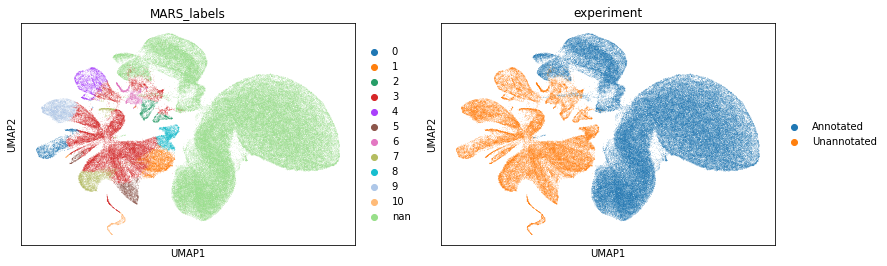

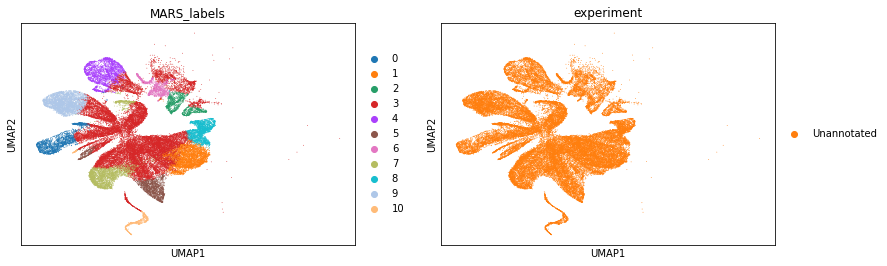

In [24]:
MARS_latent_umap(cvae_adata, plot_gene_list = ['MARS_labels','experiment'], save=".png")

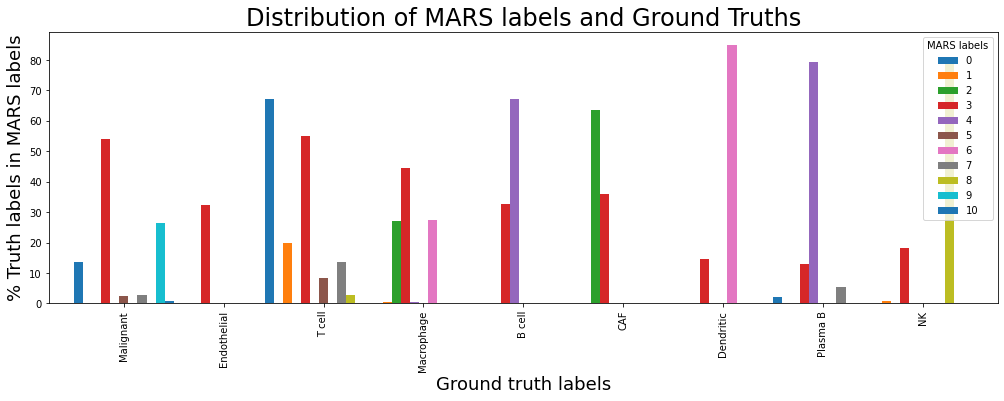

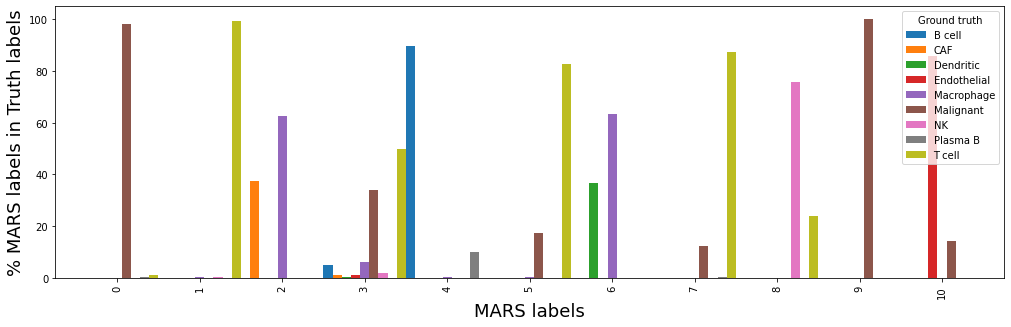

In [25]:
cell_type_assign(cvae_adata, save=True)

### scRNA meta data on scATAC

In [21]:
import torch.nn.functional as F

label = torch.as_tensor (np.concatenate( (np.zeros(dense_rna.shape[0]),np.ones(raw_atac.shape[0]) ), axis=0))
one_hot_label = torch.nn.functional.one_hot(label.to(torch.int64), 2)


In [22]:
cvae_annotated = ExperimentDataset(dense_rna, 
                                   multi_data.obs.index, 
                                   xy, one_hot_label[:dense_rna.shape[0]], rna_y['dbscan'])

cvae_unannotated = ExperimentDataset(raw_atac, 
                                     scatac.obs.index, 
                                     xy, one_hot_label[raw_rna.shape[0]:], atac_y['dbscan'])

cvae_pretrain = ExperimentDataset(raw_atac, 
                             scatac.obs.index, 
                             xy,
                             one_hot_label[raw_rna.shape[0]:])

n_clusters= 11

params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device
params.epochs_pretrain = 30
params.pretrain_batch = 128
params.epochs = 30

== Dataset: Found 161764 items 
== Dataset: Found 31 classes
== Dataset: Found 43956 items 
== Dataset: Found 9 classes


In [23]:
cvae_mars = CVAE_MARS( n_clusters, params, [cvae_annotated], cvae_unannotated, cvae_pretrain, 
                        val_split=1.0, hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=0.2,
                        latent_dim = 50, n_feature = xy.shape[0], 
                        network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                       "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                       "n_hidden_gener_2": 100, "n_hidden_gener_3": 100},
                        lambda_reconstruct = 1, lambda_kl = 1e-2, batch_shape = 2)

#adata, landmarks, scores , training_history, latent_tracker, 
cvae_adata, cvae_landmarks, cvae_scores, cvae_training_history, cvae_latent_tracker, cvae_pretrain_latent , cave_pretrain_loss = cvae_mars.train(evaluation_mode=True,save_all_embeddings=True)

Pretraining..
Pretraining Epoch 0, Loss: 991.5693969726562
Time:  3.010254144668579
Pretraining Epoch 1, Loss: 956.0457153320312
Time:  2.7692623138427734
Pretraining Epoch 2, Loss: 956.04541015625
Time:  2.7232351303100586
Pretraining Epoch 3, Loss: 1016.8088989257812
Time:  2.6862056255340576
Pretraining Epoch 4, Loss: 1050.438232421875
Time:  2.7628872394561768
Pretraining Epoch 5, Loss: 911.8004150390625
Time:  2.721456289291382
Pretraining Epoch 6, Loss: 986.0076293945312
Time:  2.7304446697235107
Pretraining Epoch 7, Loss: 952.461181640625
Time:  2.715456485748291
Pretraining Epoch 8, Loss: 1030.65673828125
Time:  2.855701446533203
Pretraining Epoch 9, Loss: 958.132080078125
Time:  2.8385322093963623
Pretraining Epoch 10, Loss: 985.9964599609375
Time:  2.903353691101074
Pretraining Epoch 11, Loss: 1074.7557373046875
Time:  2.9296882152557373
Pretraining Epoch 12, Loss: 1057.794921875
Time:  2.899029493331909
Pretraining Epoch 13, Loss: 953.3206787109375
Time:  2.9257564544677734


/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


... storing 'MARS_labels' as categorical


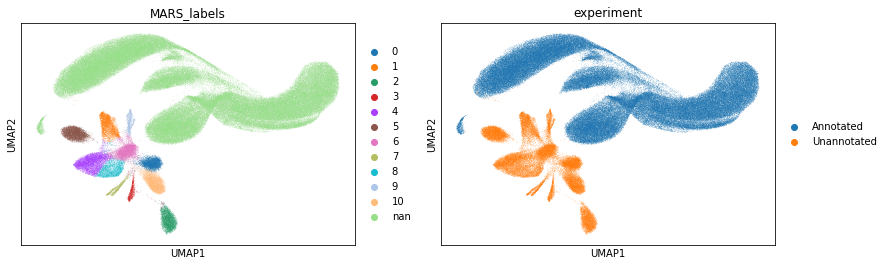

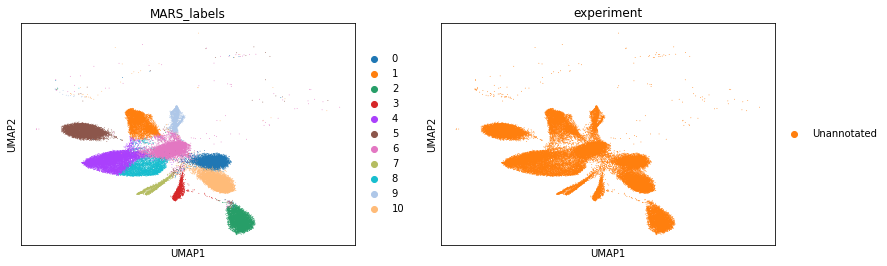

In [24]:
MARS_latent_umap(cvae_adata, plot_gene_list = ['MARS_labels','experiment'], save=".png")

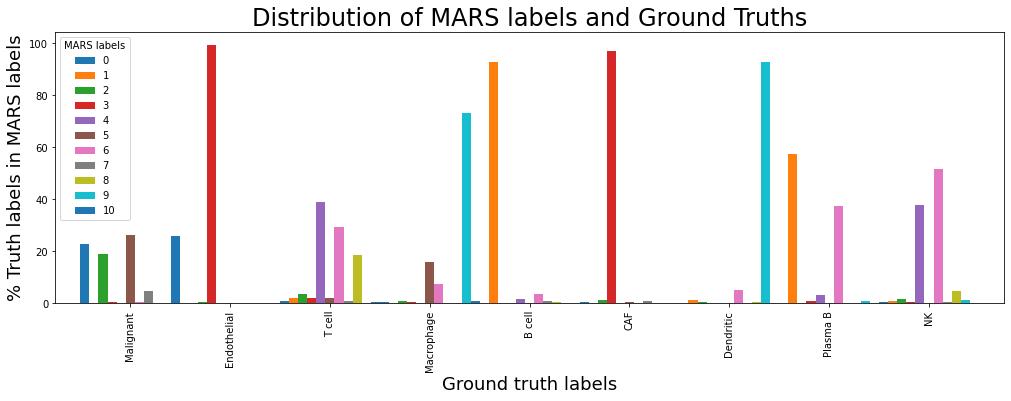

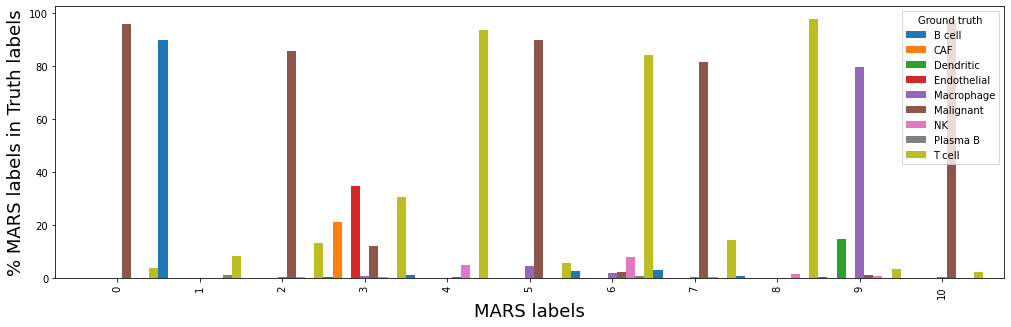

In [25]:
cell_type_assign(cvae_adata, save=True)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'label_name' as categorical


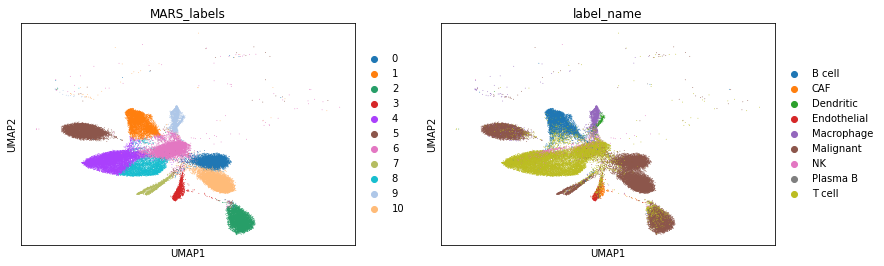

In [26]:
sc.pl.umap(cvae_adata[cvae_adata.obs.experiment=="Unannotated"], 
           color=['MARS_labels', 'label_name'], ncols=2, save=".png")

In [31]:
cvae_scores

{'f1_score': 0.3656906869320751,
 'recall': 0.42699302027459185,
 'nmi': 0.4978404711982556,
 'precision': 0.4397377700258307,
 'accuracy': 0.40171990171990174,
 'adj_rand': 0.2802982812748706,
 'adj_mi': 0.49757861739144693}

In [29]:
vae_merge_scores = {'recall': 0.4584015512695499,
 'precision': 0.40216966627185324,
 'accuracy': 0.34489034489034487,
 'adj_rand': 0.2606582058151187,
 'nmi': 0.47536228299569644,
 'f1_score': 0.3168069421701877,
 'adj_mi': 0.4750926244525107}

In [30]:
pd.DataFrame([vae_merge_scores,cvae_scores], index=['VAE','CVAE'])

recall  precision  accuracy  adj_rand       nmi  f1_score    adj_mi
VAE   0.458402   0.402170   0.34489  0.260658  0.475362  0.316807  0.475093
CVAE  0.426993   0.439738   0.40172  0.280298  0.497840  0.365691  0.497579

In [38]:
list(multi_nametonum.keys())

['CD14 Mono',
 'CD4 TCM',
 'CD8 Naive',
 'NK',
 'CD8 TEM',
 'CD16 Mono',
 'B intermediate',
 'CD4 Naive',
 'CD4 CTL',
 'B naive',
 'MAIT',
 'gdT',
 'CD8 TCM',
 'dnT',
 'B memory',
 'Doublet',
 'pDC',
 'CD8 Proliferating',
 'Treg',
 'Plasmablast',
 'CD4 TEM',
 'cDC2',
 'NK Proliferating',
 'ASDC',
 'HSPC',
 'Platelet',
 'NK_CD56bright',
 'CD4 Proliferating',
 'Eryth',
 'cDC1',
 'ILC']

In [ ]:
cvae_adata, cvae_landmarks

In [46]:
cvae_adata.obs['MARS_labels']

L3_ACTATGGCAGGCACAA-Annotated             nan
E2L8_TGATCAGTCTGAGGTT-Annotated           nan
E2L1_TCTCTGGTCTACCTTA-Annotated           nan
E2L3_GCCGTGAGTACGTACT-Annotated           nan
L2_CCGATCTAGTCATCGT-Annotated             nan
                                         ... 
pt1130_TAGCGGCAGATCACCT-1-Unannotated       6
pt856_A_GATGGCCCATCCGTAA-1-Unannotated      0
pt1009_CATAACGCATGCCCTT-1-Unannotated       4
pt856_B_GTTGGTAAGAGGCGGA-1-Unannotated      0
pt856_A_CCACAGGGTCACAGTT-1-Unannotated     10
Name: MARS_labels, Length: 205720, dtype: category
Categories (12, object): ['0', '1', '2', '3', ..., '8', '9', '10', 'nan']

In [53]:
#0,2,5

subset  = cvae_adata[(cvae_adata.obs['experiment']=='Annotated')|(cvae_adata.obs['MARS_labels']=='0')|(cvae_adata.obs['MARS_labels']=='1')|(cvae_adata.obs['MARS_labels']=='5') ]

In [54]:
subset.obsm['MARS_embedding'].shape

(176488, 50)

In [41]:
cvae_adata.obsm['MARS_embedding'].shape

(205720, 50)

In [35]:
cvae_landmarks[0].shape, cvae_landmarks[1].shape

(torch.Size([31, 50]), torch.Size([11, 50]))

In [55]:
mars_cvae_celltype= cvae_mars.name_cell_types(subset , cvae_landmarks, list(multi_nametonum.keys()))


Cluster label: 0
CD8 Naive: 2.537164327658871e-06
CD4 TCM: 2.6959493891619e-06
MAIT: 3.376577005069951e-06
HSPC: 0.0009148167044822086
Platelet: 0.9990669643724701

Cluster label: 1
CD8 TCM: 0.002001284240717294
CD4 Proliferating: 0.006651019408022666
MAIT: 0.008868235939407096
CD4 CTL: 0.0570409253847577
ILC: 0.922676329946852

Cluster label: 5
MAIT: 0.000748786491520994
ILC: 0.0009832036471717684
CD4 Proliferating: 0.0011629920501431126
HSPC: 0.012337584614788902
Platelet: 0.9810221292092028


In [56]:
subset  = cvae_adata[(cvae_adata.obs['experiment']=='Annotated')|(cvae_adata.obs['MARS_labels']=='4')|(cvae_adata.obs['MARS_labels']=='6')|(cvae_adata.obs['MARS_labels']=='8') ]
mars_cvae_celltype_Tcell= cvae_mars.name_cell_types(subset , cvae_landmarks, list(multi_nametonum.keys()))


Cluster label: 4
NK_CD56bright: 4.823167055492457e-08
NK: 2.250105044598413e-07
HSPC: 0.0016281825648682977
Plasmablast: 0.010791579632760152
Platelet: 0.9875799121074702

Cluster label: 6
NK Proliferating: 0.010173420034179446
NK_CD56bright: 0.06749993884591592
HSPC: 0.06864228306468126
NK: 0.06922142911394814
Platelet: 0.7741453704456718

Cluster label: 8
gdT: 1.697054999692131e-09
CD8 Proliferating: 2.5629380141372988e-08
Plasmablast: 0.00016366348249894697
HSPC: 0.0006528544077796125
Platelet: 0.9991834534369604


In [20]:
### AE MARS

import torch.nn as nn
import numpy as np
import torch
#from sklearn.cluster import k_means_
from sklearn.cluster import KMeans
import torch
from torch.nn import functional as F

#from model.utils import euclidean_dist

class EpochSampler(object):
    '''
    EpochSampler: yield permuted indexes at each epoch.
   
    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, indices):
        '''
        Initialize the EpochSampler object
        Args:
        - labels: an iterable containing all the labels for the current dataset
        samples indexes will be infered from this iterable.
        - iterations: number of epochs
        '''
        super(EpochSampler, self).__init__()
        self.indices = indices
        

    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        
        while(True):
            shuffled_idx = self.indices[torch.randperm(len(self.indices))]
            
            yield shuffled_idx
            

    def __len__(self):
        '''
        returns the number of iterations (episodes) per epoch
        '''
        return self.iterations

def init_labeled_loader(data, val_split = 0.8):
    """Initialize loaders for train and validation sets. 
    Class labels are used only
    for stratified sampling between train and validation set."""
    
    target = torch.tensor(list(data.y))
    uniq = torch.unique(target, sorted=True)
    
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    class_idxs = [idx[torch.randperm(len(idx))] for idx in class_idxs]
    
    train_idx = torch.cat([idx[:int(val_split*len(idx))] for idx in class_idxs])
    val_idx = torch.cat([idx[int(val_split*len(idx)):] for idx in class_idxs])
    
    train_loader = DataLoader(data, 
                              batch_sampler=EpochSampler(train_idx),
                              pin_memory=True)
    
    val_loader = DataLoader(data, 
                            batch_sampler=EpochSampler(val_idx),
                            pin_memory=True)
    
    return train_loader, val_loader


def init_loader(datasets, val_split = 0.8):
    
    train_loader_all = []
    val_loader_all = []
    
    for data in datasets:
        
        curr_load_tr, curr_load_val = init_labeled_loader(data, val_split)
        train_loader_all.append(curr_load_tr)
        val_loader_all.append(curr_load_val)
    
    if val_split==1:
        val_loader_all = None
        
    return train_loader_all, val_loader_all


def init_data_loaders(labeled_data, unlabeled_data, 
                      pretrain_data, pretrain_batch, val_split):
    
    """Initialize loaders for pretraing, 
    training (labeled and unlabeled datasets) and validation. """
    
    train_loader, val_loader = init_loader(labeled_data, val_split)
    
    if not pretrain_data:
        pretrain_data = unlabeled_data
    
    pretrain_loader = torch.utils.data.DataLoader(dataset=pretrain_data, shuffle=True,
                                                  batch_size=pretrain_batch if pretrain_batch!=None else len(unlabeled_data.x))        
    test_loader = DataLoader(unlabeled_data, 
                            batch_sampler=EpochSampler(torch.randperm(len(unlabeled_data.x))),
                            pin_memory=True) 
    
    #test_loader,_ = init_loader([unlabeled_data], 1.0) # to reproduce results in the paper
    #test_loader = test_loader[0]
    return train_loader, test_loader, pretrain_loader, val_loader
           
           
def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

def loss_task(encoded, prototypes, target, criterion='dist'):
    """Calculate loss.
    criterion: NNLoss - assign to closest prototype and calculate NNLoss
    dist - loss is distance to prototype that example needs to be assigned to
                and -distance to prototypes from other class
    """
    
    uniq = torch.unique(target, sorted=True)
    
    ###index of samples for each class of labels
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    # prepare targets so they start from 0,1
    for idx,v in enumerate(uniq):
        target[target==v]=idx
    
    dists = euclidean_dist(encoded, prototypes)
    
    if criterion=='NNLoss':
       
        loss = torch.nn.NLLLoss()
        log_p_y = F.log_softmax(-dists, dim=1)
        
        loss_val = loss(log_p_y, target)
        _, y_hat = log_p_y.max(1)
        
    
    elif criterion=='dist':
        
        loss_val = torch.stack([dists[idx_example, idx_proto].mean(0) for idx_proto,idx_example in enumerate(class_idxs)]).mean()
        #loss_val1 = loss_val1/len(embeddings) 
        y_hat = torch.max(-dists,1)[1]
        
    acc_val = y_hat.eq(target.squeeze()).float().mean()    
        
    return loss_val, acc_val

def loss_test_nn(encoded, prototypes):
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    print(args_count)
    
    loss = torch.nn.NLLLoss()
    log_p_y = F.log_softmax(-dists, dim=1)
    print(log_p_y.shape)
        
    loss_val = loss(log_p_y, y_hat)
    _, y_hat = log_p_y.max(1)
    
    return loss_val, args_count

###Intra cluster distance
def loss_test_basic(encoded, prototypes):
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    #print(args_count)
    
    min_dist = min_dist[0] # get_distances
    
    #thr = torch.stack([torch.sort(min_dist[y_hat==idx_class])[0][int(len(min_dist[y_hat==idx_class])*0.9)] for idx_class in args_uniq])
    #loss_val = torch.stack([min_dist[y_hat==idx_class][min_dist[y_hat==idx_class]>=thr[idx_class]].mean(0) for idx_class in args_uniq]).mean()
    
    loss_val = torch.stack([min_dist[y_hat==idx_class].mean(0) for idx_class in args_uniq]).mean()
    
    #loss_val,_ = loss_task(encoded, prototypes, y_hat, criterion='dist') # same
    
    return loss_val, args_count

def loss_test(encoded, prototypes, tau):
    #prototypes = torch.stack(prototypes).squeeze() 
    loss_val_test, args_count = loss_test_basic(encoded, prototypes)
    
    
    ###inter cluster distance 
    if tau>0:
        dists = euclidean_dist(prototypes, prototypes)
        nproto = prototypes.shape[0]
        loss_val2 = - torch.sum(dists)/(nproto*nproto-nproto)
        
        loss_val_test += tau*loss_val2
        
    return loss_val_test, args_count

def reconstruction_loss(decoded, x):
    loss_func = torch.nn.MSELoss()
    loss_rcn = loss_func(decoded, x)
    #print('Reconstruction {}'.format(loss_rcn))
    
    return loss_rcn

#############################################
#############################################
def compute_landmarks_tr(embeddings, target, prev_landmarks=None, tau=0.2):
    
    """Computing landmarks of each class in the labeled meta-dataset. 
    
    Landmark is a closed form solution of 
    minimizing distance to the mean and maximizing distance to other landmarks. 
    
    If tau=0, landmarks are just mean of data points.
    
    embeddings: embeddings of the labeled dataset
    target: labels in the labeled dataset
    prev_landmarks: landmarks from previous iteration
    tau: regularizer for inter- and intra-cluster distance
    """
    
    uniq = torch.unique(target, sorted=True)
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    landmarks_mean = torch.stack([embeddings[idx_class].mean(0) for idx_class in class_idxs]).squeeze()
    
    if prev_landmarks is None or tau==0:
        return landmarks_mean
    
    suma = prev_landmarks.sum(0)
    nlndmk = prev_landmarks.shape[0]
    lndmk_dist_part = (tau/(nlndmk-1))*torch.stack([suma-p for p in prev_landmarks])
    landmarks = 1/(1-tau)*(landmarks_mean-lndmk_dist_part)
    
    return landmarks

#############################################
#############################################


def init_landmarks(n_clusters, tr_load, test_load, model, device, mode='kmeans', pretrain=True):
    """Initialization of landmarks of the labeled and unlabeled meta-dataset.
    nclusters: number of expected clusters in the unlabeled meta-dataset
    tr_load: data loader for labeled meta-dataset
    test_load: data loader for unlabeled meta-dataset
    """
    lndmk_tr = [torch.zeros(size=(len(np.unique(dl.dataset.y)), model.z_dim), 
                            requires_grad=True, device=device) for dl in tr_load]
    
    lndmk_test = [torch.zeros(size=(1, model.z_dim), 
                              requires_grad=True, device=device) 
                       for _ in range(n_clusters)]
    
    kmeans_init_tr = [init_step(dl.dataset, model, device, pretrained=pretrain, mode=mode) 
                      for dl in tr_load]
    
    kmeans_init_test = init_step(test_load.dataset, model, device, 
                                 pretrained=pretrain, mode=mode, 
                                 n_clusters=n_clusters)
    
    ##No gradient calculation
    with torch.no_grad():
        [lndmk.copy_(kmeans_init_tr[idx])  for idx,lndmk in enumerate(lndmk_tr)]
        [lndmk_test[i].copy_(kmeans_init_test[i,:]) for i in range(kmeans_init_test.shape[0])]
        
    return lndmk_tr, lndmk_test


def init_step(dataset, model, device, pretrained, mode='kmeans',n_clusters=None):
    """Initialization of landmarks with k-means or k-means++ given dataset."""
    
    if n_clusters==None:
        n_clusters = len(np.unique(dataset.y))
    nexamples = len(dataset.x)
        
    X =  torch.stack([dataset.x[i] for i in range(nexamples)])
    
    if mode=='kmeans++':
        if not pretrained: # find centroids in original space
            landmarks = k_means_._init_centroids(X.cpu().numpy(), n_clusters, 'k-means++')
            landmarks = torch.tensor(landmarks, device=device)
            landmarks = landmarks.to(device)
            lndmk_encoded,_ = model(landmarks)
            
        else:
            X = X.to(device)
            encoded,_ = model(X)
            landmarks = k_means_._init_centroids(encoded.data.cpu().numpy(), n_clusters, 'k-means++')
            lndmk_encoded = torch.tensor(landmarks, device=device)
    
    elif mode=='kmeans': # run kmeans clustering
        if not pretrained: 
            kmeans = KMeans(n_clusters, random_state=0).fit(X.cpu().numpy())
            landmarks = torch.tensor(kmeans.cluster_centers_, device=device)
            landmarks = landmarks.to(device)
            ##Feed forward net on landmarks  (k means cluster)
            ##landmarks are k means cluster centers = coordinates of cluster center
            lndmk_encoded,_ = model(landmarks)
        
        ##cluster on lower embedding space
        else:
            X = X.to(device)
            encoded,_ = model(X)
            kmeans = KMeans(n_clusters, random_state=0).fit(encoded.data.cpu().numpy())
            lndmk_encoded = torch.tensor(kmeans.cluster_centers_, device=device)
    
    return lndmk_encoded


def full_block(in_features, out_features, p_drop):
        return nn.Sequential(
            nn.Linear(in_features, out_features, bias=True),
            nn.LayerNorm(out_features),
            nn.ELU(),
            nn.Dropout(p=p_drop),
        )

class FullNet(nn.Module):
    '''
    '''
    def __init__(self, x_dim, hid_dim=64, z_dim=64, p_drop=0.2):
        super(FullNet, self).__init__()
        
        self.z_dim = z_dim
        
        self.encoder = nn.Sequential(
            full_block(x_dim, hid_dim, p_drop),
            full_block(hid_dim, z_dim, p_drop),
        )
        
        self.decoder = nn.Sequential(
            full_block(z_dim, hid_dim, p_drop),
            full_block(hid_dim, x_dim, p_drop),
        )
      
    def forward(self, x):
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded


class AE_MARS:
    def __init__(self, n_clusters, params, 
                 labeled_data, unlabeled_data, 
                 pretrain_data=None, 
                 val_split=1.0, hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=0.2):
        """Initialization of MARS.
        n_clusters: number of clusters in the unlabeled meta-dataset
        params: parameters of the MARS model
        labeled_data: list of labeled datasets. Each dataset needs to be instance of CellDataset.
        unlabeled_data: unlabeled dataset. Instance of CellDataset.
        pretrain_data: dataset for pretraining MARS. Instance of CellDataset. If not specified, unlabeled_data
                        will be used.
        val_split: percentage of data to use for train/val split (default: 1, meaning no validation set)
        hid_dim_1: dimension in the first layer of the network (default: 1000)
        hid_dim_2: dimension in the second layer of the network (default: 100)
        p_drop: dropout probability (default: 0)
        tau: regularizer for inter-cluster distance
        """
        train_load, test_load, pretrain_load, val_load = init_data_loaders(labeled_data, unlabeled_data, 
                                                                           pretrain_data, params.pretrain_batch, 
                                                                           val_split)
        self.train_loader = train_load
        self.test_loader = test_load
        self.pretrain_loader = pretrain_load
        self.val_loader = val_load
        
        ##data file type (string name)
        self.labeled_metadata = [data.metadata for data in labeled_data]
        self.unlabeled_metadata = unlabeled_data.metadata
        
        self.genes = unlabeled_data.yIDs
        
        ##number of genes 
        x_dim = self.test_loader.dataset.get_dim()
        
        ##Feed forward neural net
        self.init_model(x_dim, hid_dim_1, hid_dim_2, p_drop, params.device)
        
        self.n_clusters = n_clusters
        
        self.device = params.device
        self.epochs = params.epochs
        self.epochs_pretrain = params.epochs_pretrain
        self.pretrain_flag = params.pretrain
        self.model_file = params.model_file
        self.lr = params.learning_rate
        self.lr_gamma = params.lr_scheduler_gamma
        self.step_size = params.lr_scheduler_step
        
        self.tau = tau
        
    ###################################################################
    ###################################################################    
    ###### With the fine tuned hyper parameter     
    ###### Change the implementation of AE to VAE     
    def init_model(self, x_dim, hid_dim, z_dim, p_drop, device):
        """
        Initialize the model.
        """
        self.model = FullNet(x_dim, hid_dim, z_dim, p_drop).to(device)
    
    ###################################################################
    ###################################################################
    
    def init_optim(self, param1, param2, learning_rate):
        """Initializing optimizers."""
        
        optim = torch.optim.Adam(params=param1, lr=learning_rate)
        optim_landmk_test = torch.optim.Adam(params=param2, lr=learning_rate)
        
        return optim, optim_landmk_test
    
    ###################################################################
    ###################################################################
    ########Will need to alter this part for VAE (KL + reconstruction loss + regularized)
    def pretrain(self, optim):
        """
        Pretraining model with autoencoder.
        optim: optimizer
        """
        print('Pretraining..')
        
        for e in range(self.epochs_pretrain):
            
            start = time.time()
            epoch_loss = 0
            for _, batch in enumerate(self.pretrain_loader):
                x,_,_ = batch
                x = x.to(self.device)
                _, decoded = self.model(x)
                loss = reconstruction_loss(decoded, x) 
                optim.zero_grad()              
                loss.backward()                    
                optim.step() 
                
                epoch_loss += loss 
                
            print(f"Pretraining Epoch {e}, Loss: {epoch_loss}")
            print("Time: ", time.time()-start)
        
        print("Pretraining done")
            
    ###################################################################
    ###################################################################
    
    
    def train(self, evaluation_mode=True, save_all_embeddings=True):
        """Train model.
        evaluation_mode: if True, validates model on the unlabeled dataset. 
        In the evaluation mode, ground truth labels of the unlabeled dataset must be 
        provided to validate model
        
        save_all_embeddings: if True, MARS embeddings for annotated and unannotated 
        experiments will be saved in an anndata object,
        otherwise only unnanotated will be saved. 
        If naming is called after, all embeddings need to be saved
        
        return: adata: anndata object containing labeled and unlabeled meta-dataset 
        with MARS embeddings and estimated labels on the unlabeled dataset
                landmk_all: landmarks of the labeled and unlabeled meta-dataset in the 
                order given for training. Landmarks on the unlabeled
                            dataset are provided last
                metrics: clustering metrics if evaluation_mode is True
                
        """
        tr_iter = [iter(dl) for dl in self.train_loader]
        
        if self.val_loader is not None:
            val_iter = [iter(dl) for dl in self.val_loader]
        
        ####Pre train step 
        optim_pretrain = torch.optim.Adam(params=list(self.model.parameters()), lr=self.lr)
        if self.pretrain_flag:
            self.pretrain(optim_pretrain)
        else:
            self.model.load_state_dict(torch.load(self.MODEL_FILE))    
        ####
        
        test_iter = iter(self.test_loader)
        
        
        ##initialize training (annotated landmark) and testing (unannotated landmark)
        landmk_tr, landmk_test = init_landmarks(self.n_clusters, 
                                                self.train_loader, 
                                                self.test_loader, 
                                                self.model, self.device)
        
        optim, optim_landmk_test = self.init_optim(list(self.model.encoder.parameters()), 
                                                   landmk_test, self.lr)
        
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                                       gamma=self.lr_gamma,
                                                       step_size=self.step_size)
        
        latent_tracker = []
        training_history = {'Loss':[],'Accuracy':[], 'Loss_tracker':[]}
        
        best_acc = 0
        for epoch in range(1, self.epochs+1):
            
            ##Set model for training
            self.model.train()
            start = time.time()
            ##This is equivalent to train step 
            loss_tr, acc_tr, landmk_tr, landmk_test, latent_history, loss_tracker = self.do_epoch(tr_iter, 
                                                                                    test_iter,
                                                                                    optim, 
                                                                                    optim_landmk_test,
                                                                                    landmk_tr, 
                                                                                    landmk_test)
            ##Loss training includes 2- embedding and landmark distance 
            print(f'Epoch {epoch} Loss training: {loss_tr}, Accuracy training: {acc_tr}')
            
            ###Track model training 
            training_history['Loss'].append(loss_tr)
            training_history['Accuracy'].append(acc_tr)
            training_history['Loss_tracker'].append(loss_tracker)
            
            latent_tracker.append(latent_history)
            
            print('Time: ', time.time()-start)
            
            if epoch==self.epochs: 
                print('\n=== Epoch: {} ==='.format(epoch))
                print('Train acc: {}'.format(acc_tr))
            if self.val_loader is None:
                continue
            self.model.eval()
            ##Stop training 
            
            with torch.no_grad():
                loss_val,acc_val = self.do_val_epoch(val_iter, landmk_tr)
                if acc_val > best_acc:
                    print('Saving model...')
                    best_acc = acc_val
                    best_state = self.model.state_dict()
                    #torch.save(model.state_dict(), self.model_file)
                postfix = ' (Best)' if acc_val >= best_acc else ' (Best: {})'.format(best_acc)
                print('Val loss: {}, acc: {}{}'.format(loss_val, acc_val, postfix))
            lr_scheduler.step()
            
        if self.val_loader is None:
            best_state = self.model.state_dict() # best is last
        
        landmk_all = landmk_tr+[torch.stack(landmk_test).squeeze()]
        
        ##Test time (assign labels to unlabaled data)
        adata_test, eval_results = self.assign_labels(landmk_all[-1], evaluation_mode)
        
        adata = self.save_result(tr_iter, adata_test, save_all_embeddings)
        
        if evaluation_mode:
            return adata, landmk_all, eval_results, training_history, latent_tracker
        
        return adata, landmk_all, training_history, latent_tracker
    
    def save_result(self, tr_iter, adata_test, save_all_embeddings):
        """Saving embeddings from labeled and unlabeled dataset, ground truth labels and 
        predictions to joint anndata object."""
        adata_all = []

        if save_all_embeddings:
            for task in range(len(tr_iter)): # saving embeddings from labeled dataset
                task = int(task)
                x, y, cells = next(tr_iter[task])
                x, y = x.to(self.device), y.to(self.device)
                encoded,_ = self.model(x)
                adata_all.append(self.pack_anndata(x, cells, encoded, gtruth=y))
            
        adata_all.append(adata_test)    
        
        if save_all_embeddings:
            adata = adata_all[0].concatenate(adata_all[1:], 
                                             batch_key='experiment',
                                             batch_categories=self.labeled_metadata+[self.unlabeled_metadata])
        else:
            adata = adata_all[0]

            
        adata.obsm['MARS_embedding'] = np.concatenate([a.uns['MARS_embedding'] for a in adata_all])
        #adata.write('result_adata.h5ad')
        
        return adata
    
    def assign_labels(self, landmk_test, evaluation_mode):
        """Assigning cluster labels to the unlabeled meta-dataset.
        test_iter: iterator over unlabeled dataset
        landmk_test: landmarks in the unlabeled dataset
        evaluation mode: computes clustering metrics if True
        """
        #test_iter = iter(self.test_loader)
            
        torch.no_grad()
        self.model.eval() # eval mode
        
        test_iter = iter(self.test_loader)
        
        x_test, y_true, cells = next(test_iter) # cells are needed because dataset is in random order
        x_test = x_test.to(self.device)
        
        encoded_test,_ = self.model(x_test)
        
        ###Embedding space eucledian distance 
        dists = euclidean_dist(encoded_test, landmk_test)
        
        ###Prediction based on the minimal distance to learned landmark
        y_pred = torch.min(dists, 1)[1]
        
        adata = self.pack_anndata(x_test, cells, encoded_test, y_true, y_pred)
        
        eval_results = None
        if evaluation_mode:
            eval_results = compute_scores(y_true, y_pred)
            
        return adata, eval_results
    
    
    def pack_anndata(self, x_input, cells, embedding, gtruth=[], estimated=[]):
        """Pack results in anndata object.
        x_input: gene expressions in the input space
        cells: cell identifiers
        embedding: resulting embedding of x_test using MARS
        landmk: MARS estimated landmarks
        gtruth: ground truth labels if available (default: empty list)
        estimated: MARS estimated clusters if available (default: empty list)
        """
        adata = anndata.AnnData(x_input.data.cpu().numpy())
        adata.obs_names = cells
        adata.var_names = self.genes
        if len(estimated)!=0:
            adata.obs['MARS_labels'] = pd.Categorical(values=estimated.cpu().numpy())
        if len(gtruth)!=0:
            adata.obs['truth_labels'] = pd.Categorical(values=gtruth.cpu().numpy())
        adata.uns['MARS_embedding'] = embedding.data.cpu().numpy()
        
        return adata
    
    
    def do_epoch(self, tr_iter, test_iter, optim, optim_landmk_test, landmk_tr, landmk_test):
        """
        One training epoch.
        tr_iter: iterator over labeled meta-data
        test_iter: iterator over unlabeled meta-data
        
        optim: optimizer for embedding
        optim_landmk_test: optimizer for test landmarks
        
        landmk_tr: landmarks of labeled meta-data from previous epoch
        landmk_test: landmarks of unlabeled meta-data from previous epoch
        """
        
        latent_history = {'Train_latent':[], 'Train_label':[],
                          'Test_latent':[], 'Test_label':[], 
                          'Train_landmark':[], 'Test_landmark':[]}
        
        loss_tracker = {'Test_anno':0,
                        'Train_latent_loss':0, 'Train_reconstr_loss': 0, 
                        'Test_latent_loss':0, 'Test_reconstr_loss': 0}
        
        
        self.set_requires_grad(False)
        
        for landmk in landmk_test:
            landmk.requires_grad=False
        
        optim_landmk_test.zero_grad()
        
        # update centroids    
        task_idx = torch.randperm(len(tr_iter)) ##shuffle per epoch
        
        ###Annotated landmark 
        for task in task_idx:
            
            task = int(task)
            x, y, _ = next(tr_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            encoded,_ = self.model(x)
            
            curr_landmk_tr = compute_landmarks_tr(encoded, y, landmk_tr[task], tau=self.tau)
            landmk_tr[task] = curr_landmk_tr.data # save landmarks
            
            latent_history['Train_landmark'].append(encoded)
            latent_history['Train_label'].append(y)
            
        ###Unannotated landmark
        for landmk in landmk_test:
            landmk.requires_grad=True
            
        x,y_test,_ = next(test_iter)
        x = x.to(self.device)
        encoded,_ = self.model(x)
        loss, args_count = loss_test(encoded, 
                                     torch.stack(landmk_test).squeeze(), 
                                     self.tau)
        loss.backward()
        optim_landmk_test.step()
        
        latent_history['Test_landmark'].append(encoded)
        latent_history['Test_label'].append(y_test)
        loss_tracker['Test_anno'] = loss
        
        # update embedding
        self.set_requires_grad(True)
        for landmk in landmk_test:
            landmk.requires_grad=False
            
        optim.zero_grad()
        total_accuracy = 0
        total_loss = 0
        ntasks = 0
        mean_accuracy = 0
        
        ###Annotated set
        task_idx = torch.randperm(len(tr_iter))
        for task in task_idx:
            task = int(task)
            x, y, _ = next(tr_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            encoded, decoded = self.model(x)
            ###Eucledian distance between embedding and landmark
            loss, acc = loss_task(encoded, landmk_tr[task], y, criterion='dist')
            total_loss += loss
            total_accuracy += acc.item()
            ntasks += 1
            latent_history['Train_latent'].append(encoded)
            
            loss_tracker['Train_latent_loss'] = loss
            loss_tracker['Train_reconstr_loss'] = reconstruction_loss(decoded, x)
            
        if ntasks>0:
            mean_accuracy = total_accuracy / ntasks
        
        ##Un-Annotated
        # test part
        x,y,_ = next(test_iter)
        x = x.to(self.device)
        encoded, decoded = self.model(x)
        loss,_ = loss_test(encoded, torch.stack(landmk_test).squeeze(), self.tau)
        latent_history['Test_latent'].append(encoded)
        
        loss_tracker['Test_latent_loss'] = loss
        loss_tracker['Test_reconstr_loss'] = reconstruction_loss(decoded, x)
        
        total_loss += loss
        ntasks += 1
    
        mean_loss = total_loss / ntasks
        
        mean_loss.backward()
        optim.step()
        
        return mean_loss, mean_accuracy, landmk_tr, landmk_test, latent_history, loss_tracker
    
    def do_val_epoch(self, val_iter, prev_landmk):
        """One epoch of validation.
        val_iter: iterator over validation set
        prev_landmk: landmarks from previous epoch
        """
        ntasks = len(val_iter)
        task_idx = torch.randperm(ntasks)
        
        total_loss = 0
        total_accuracy = 0
        
        for task in task_idx:
            x, y, _ = next(val_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            encoded = self.model(x)
            loss, acc = loss_task(encoded, prev_landmk[task], y, criterion='dist')
            total_loss += loss
            total_accuracy += acc.item()
        mean_accuracy = total_accuracy / ntasks
        mean_loss = total_loss / ntasks
        
        return mean_loss, mean_accuracy
    
    
    def set_requires_grad(self, requires_grad):
        for param in self.model.parameters():
            param.requires_grad = requires_grad
    
    def name_cell_types(self, adata, landmk_all, cell_name_mappings, 
                        top_match=5, umap_reduce_dim=True, ndim=10):
        """For each test cluster, estimate sigma and mean. 
        Fit Gaussian distribution with that mean and sigma
        and calculate the probability of each of the train landmarks 
        to be the neighbor to the mean data point.
        Normalization is performed with regards to all other landmarks in train."""
        
        experiments = list(OrderedDict.fromkeys(list(adata.obs['experiment'])))
        
        encoded_tr = []
        landmk_tr = []
        landmk_tr_labels = []
        for idx, exp in enumerate(experiments[:-1]):
            tiss = adata[adata.obs['experiment'] == exp,:]
            
            if exp==self.unlabeled_metadata: 
                raise ValueError("Error: Unlabeled dataset needs to be last one in the input anndata object.")
                
            encoded_tr.append(tiss.obsm['MARS_embedding'])
            landmk_tr.append(landmk_all[idx])
            landmk_tr_labels.append(np.unique(tiss.obs['truth_labels']))
            
        tiss = adata[adata.obs['experiment'] == self.unlabeled_metadata,:]
        ypred_test = tiss.obs['MARS_labels']
        uniq_ytest = np.unique(ypred_test)
        encoded_test = tiss.obsm['MARS_embedding']
        
        landmk_tr_labels = np.concatenate(landmk_tr_labels)
        encoded_tr = np.concatenate(encoded_tr)
        landmk_tr = np.concatenate([p.cpu() for p in landmk_tr])
        if  umap_reduce_dim:
            encoded_extend = np.concatenate((encoded_tr, encoded_test, landmk_tr))
            adata = anndata.AnnData(encoded_extend)
            sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
            sc.tl.umap(adata, n_components=ndim)
            encoded_extend = adata.obsm['X_umap']
            n1 = len(encoded_tr)
            n2 = n1 + len(encoded_test)
            encoded_tr = encoded_extend[:n1,:]
            encoded_test = encoded_extend[n1:n2,:]
            landmk_tr = encoded_extend[n2:,:]
        
        interp_names = defaultdict(list)
        for ytest in uniq_ytest:
            print('\nCluster label: {}'.format(str(ytest)))
            idx = np.where(ypred_test==ytest)
            subset_encoded = encoded_test[idx[0],:]
            mean = np.expand_dims(np.mean(subset_encoded, axis=0),0)
            
            sigma  = self.estimate_sigma(subset_encoded)
            
            prob = np.exp(-np.power(distance.cdist(mean, landmk_tr, metric='euclidean'),2)/(2*sigma*sigma))
            prob = np.squeeze(prob, 0)
            normalizat = np.sum(prob)
            if normalizat==0:
                print('Unassigned')
                interp_names[ytest].append("unassigned")
                continue
            
            prob = np.divide(prob, normalizat)
            
            uniq_tr = np.unique(landmk_tr_labels)
            prob_unique = []
            for cell_type in uniq_tr: # sum probabilities of same landmarks
                prob_unique.append(np.sum(prob[np.where(landmk_tr_labels==cell_type)]))
            
            sorted = np.argsort(prob_unique, axis=0)
            best = uniq_tr[sorted[-top_match:]]
            sortedv = np.sort(prob_unique, axis=0)
            sortedv = sortedv[-top_match:]
            for idx, b in enumerate(best):
                interp_names[ytest].append((cell_name_mappings[b], sortedv[idx]))
                print('{}: {}'.format(cell_name_mappings[b], sortedv[idx]))
                
        return interp_names
    
    
    def estimate_sigma(self, dataset):
        nex = dataset.shape[0]
        dst = []
        for i in range(nex):
            for j in range(i+1, nex):
                dst.append(distance.euclidean(dataset[i,:],dataset[j,:]))
        return np.std(dst)

### scRNA - scRNA MARS with scaled, normalized expression matrix and variable genes 

In [21]:
xy, x_ind, y_ind = np.intersect1d(mit_data.var_names,  multi_data.var_names, return_indices=True)

In [22]:
sub_multi_data = multi_data[ multi_data.obs['celltype.l1'] !="Mono"]

In [23]:
sub_multi_data

View of AnnData object with n_obs × n_vars = 112754 × 3000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'numeric_celltype.l2'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'neighbors', 'log1p', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    obsp: 'distances'

In [24]:
xy, x_ind, y_ind = np.intersect1d(mit_data.var_names,  multi_data.var_names, return_indices=True)
sub_multi_data = multi_data[ multi_data.obs['celltype.l1'] !="Mono"]

rna_y = sub_multi_data.obs[['numeric_celltype.l2','celltype.l2']]
rna_y.columns=['dbscan','annotated_celltype']
rna_y = rna_y.copy()
rna_y['omic'] = 'RNA'

atac_y = mit_data.obs[['new_dbscan','annotated_celltype']]
atac_y.columns=['dbscan','annotated_celltype']
atac_y = atac_y.copy()
atac_y['omic'] = 'ATAC'

# common_y = rna_y.append(atac_y)

# common_y = common_y.copy()
# common_y['annotation'] = common_y['annotated_celltype']+"_"+common_y['omic']

raw_rna = sub_multi_data.X[:,y_ind]
raw_atac = mit_data.X[:,x_ind]

#dense_rna = raw_rna.todense()

In [25]:
annotated = ExperimentDataset(raw_rna, 
                              multi_data.obs.index, 
                              xy, 
                              'Annotated', rna_y['dbscan'])

unannotated = ExperimentDataset(raw_atac, 
                                mit_data.obs.index, 
                                xy, 
                                'Unannotated', atac_y['dbscan'])

pretrain = ExperimentDataset(raw_atac, 
                             mit_data.obs.index, 
                             xy,
                             'Unannotated')

n_clusters= 11

params, unknown= get_parser().parse_known_args()
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'

params.device = device
params.epochs_pretrain = 10
params.pretrain_batch = 128
params.epochs = 10

== Dataset: Found 112754 items 
== Dataset: Found 29 classes
== Dataset: Found 46089 items 
== Dataset: Found 9 classes


In [26]:
ae_merge_mars = AE_MARS(n_clusters, params, [annotated] , unannotated, pretrain, 
                ##These are roll over parametesr form original model 
                hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=0.2)

ae_merge_adata, ae_merge_landmarks, ae_merge_scores , ae_merge_training_history, ae_merge_latent_tracker = ae_merge_mars.train(evaluation_mode=True,
                                                                                                                               save_all_embeddings=True)

Pretraining..
Pretraining Epoch 0, Loss: 959.7547607421875
Time:  6.310560464859009
Pretraining Epoch 1, Loss: 793.63037109375
Time:  6.196913480758667
Pretraining Epoch 2, Loss: 693.2476196289062
Time:  5.947729825973511
Pretraining Epoch 3, Loss: 618.554443359375
Time:  5.51132345199585
Pretraining Epoch 4, Loss: 562.3837890625
Time:  5.447034597396851
Pretraining Epoch 5, Loss: 517.9385986328125
Time:  5.569788932800293
Pretraining Epoch 6, Loss: 481.6717529296875
Time:  6.777471542358398
Pretraining Epoch 7, Loss: 452.1474609375
Time:  5.774767875671387
Pretraining Epoch 8, Loss: 428.49102783203125
Time:  5.3964056968688965
Pretraining Epoch 9, Loss: 407.7687072753906
Time:  5.43459153175354
Pretraining done
Epoch 1 Loss training: 5.924485683441162, Accuracy training: 0.7817904353141785
Time:  17.87188720703125
Epoch 2 Loss training: 4.631617546081543, Accuracy training: 0.7705801725387573
Time:  18.229521989822388
Epoch 3 Loss training: 3.6480512619018555, Accuracy training: 0.770

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [60]:
ae_merge_scores

{'adj_rand': 0.463566566443253,
 'recall': 0.6310264427134368,
 'precision': 0.696741340572285,
 'adj_mi': 0.7166238001263938,
 'f1_score': 0.633897709677551,
 'accuracy': 0.5682483889865261,
 'nmi': 0.7167578139988865}

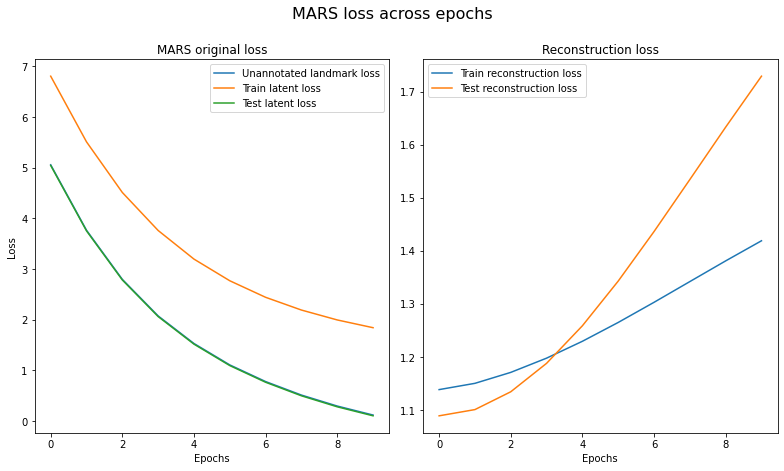

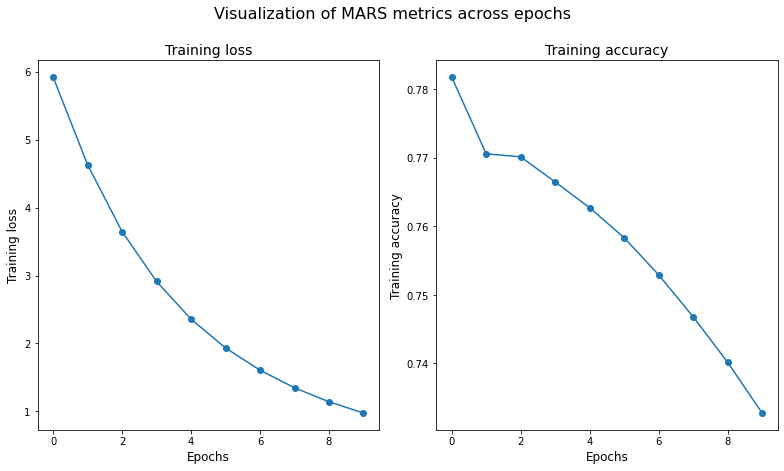

In [36]:
MARS_loss_tracker (ae_merge_training_history, save = True)
MARS_history (ae_merge_training_history, save = True)

... storing 'MARS_labels' as categorical


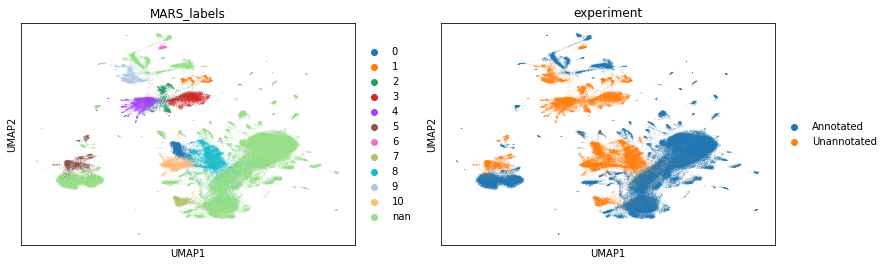

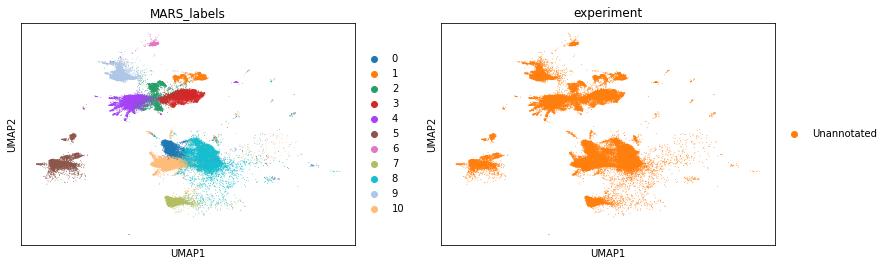

In [27]:
MARS_latent_umap(ae_merge_adata, plot_gene_list = ['MARS_labels','experiment'], save=".png")

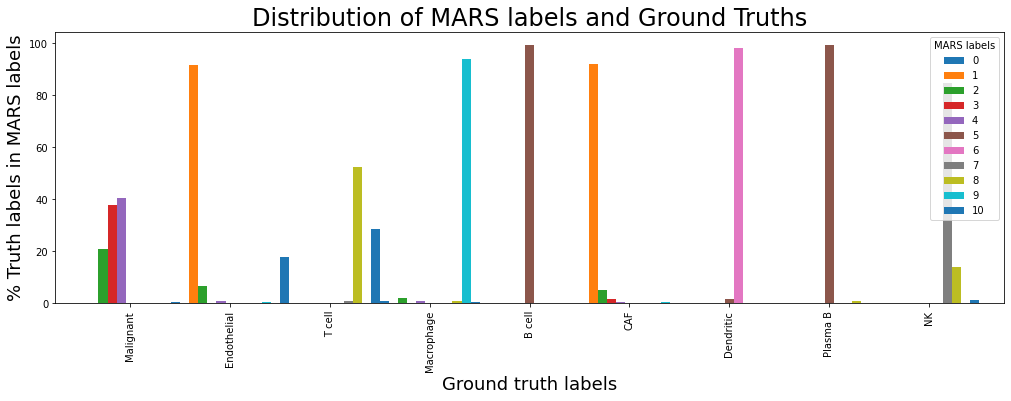

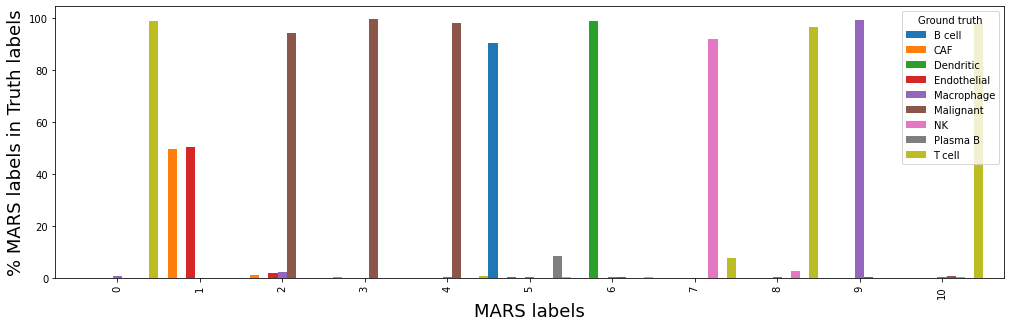

In [28]:
cell_type_assign(ae_merge_adata, save=True)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'label_name' as categorical


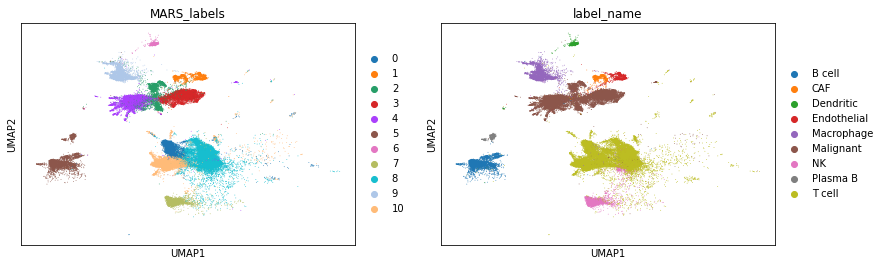

In [35]:
sc.pl.umap(ae_merge_adata[ae_merge_adata.obs.experiment=="Unannotated"], 
           color=['MARS_labels', 'label_name'], ncols=2, save=True)

... storing 'label_name' as categorical


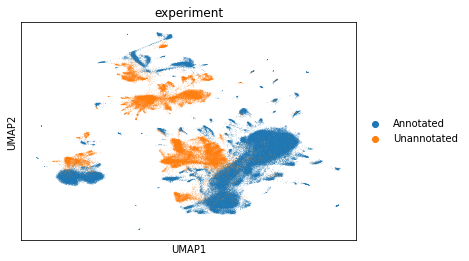

In [37]:
sc.pl.umap(ae_merge_adata, 
           color=['experiment'], ncols=2, save=True)

In [30]:
subset  = ae_merge_adata[(ae_merge_adata.obs['experiment']=='Annotated')|
                         (ae_merge_adata.obs['MARS_labels']=='0')|(ae_merge_adata.obs['MARS_labels']=='8')|
                         (ae_merge_adata.obs['MARS_labels']=='10')|(ae_merge_adata.obs['MARS_labels']=='2')|
                         (ae_merge_adata.obs['MARS_labels']=='3')|(ae_merge_adata.obs['MARS_labels']=='4') ]
subset

View of AnnData object with n_obs × n_vars = 147759 × 1016
    obs: 'truth_labels', 'MARS_labels', 'experiment', 'label_name'
    uns: 'neighbors', 'umap', 'MARS_labels_colors', 'experiment_colors'
    obsm: 'MARS_embedding', 'X_umap'
    obsp: 'distances', 'connectivities'

In [31]:
mars_ae_celltype = ae_merge_mars.name_cell_types(subset , 
                                                 ae_merge_landmarks, 
                                                 list(multi_nametonum.keys()))


Cluster label: 0
MAIT: 0.07045855736356822
ILC: 0.07157208244421996
dnT: 0.14302670539165813
CD4 TEM: 0.29841022678408274
Treg: 0.389035925148671

Cluster label: 10
CD8 TCM: 0.05698390450239999
CD4 TCM: 0.06932557322244653
dnT: 0.15345470727542893
Treg: 0.2103733119880296
CD4 TEM: 0.4201226670437648

Cluster label: 2
Eryth: 4.671119305096223e-06
cDC2: 1.3572307730474318e-05
Platelet: 0.0003193549102760345
Doublet: 0.0043714401881898915
HSPC: 0.9952906512413576

Cluster label: 3
Eryth: 6.993231948219671e-16
cDC2: 2.0162224404079863e-13
Platelet: 4.0183989429381524e-12
Doublet: 8.556168021604435e-07
HSPC: 0.9999991443789772

Cluster label: 4
cDC2: 0.00029907146609286237
Platelet: 0.004390822439631542
Eryth: 0.015698325570019815
Doublet: 0.033943008082625174
HSPC: 0.9455431492890033

Cluster label: 8
CD8 Proliferating: 0.11488213082318072
ILC: 0.13250688496738197
MAIT: 0.1634085949617476
CD4 CTL: 0.18691808670578416
CD8 TEM: 0.23784514544915442


In [34]:
subset  = ae_merge_adata[(ae_merge_adata.obs['experiment']=='Annotated')|
                         (ae_merge_adata.obs['MARS_labels']=='1')|(ae_merge_adata.obs['MARS_labels']=='5')|
                         (ae_merge_adata.obs['MARS_labels']=='6')|(ae_merge_adata.obs['MARS_labels']=='7')|
                         (ae_merge_adata.obs['MARS_labels']=='9') ]

mars_ae_celltype = ae_merge_mars.name_cell_types(subset , 
                                                 ae_merge_landmarks, 
                                                 list(multi_nametonum.keys()))


Cluster label: 1
cDC2: 5.772646710780387e-17
Plasmablast: 3.561245268660444e-16
Doublet: 0.0004049817302621416
Platelet: 0.3802339296081309
HSPC: 0.6193610886616066

Cluster label: 5
HSPC: 1.404463084776159e-07
Plasmablast: 0.17153659139320865
B naive: 0.22176891925769507
B memory: 0.2654092390914383
B intermediate: 0.3412850999933315

Cluster label: 6
Doublet: 1.5471068445529334e-07
cDC1: 2.395839504015267e-05
cDC2: 2.892018370909746e-05
pDC: 0.3984632536435539
ASDC: 0.6014836053903075

Cluster label: 7
CD8 Proliferating: 7.016159084877126e-06
NK Proliferating: 4.540411747440908e-05
ILC: 0.04000599264125618
NK: 0.04507434634479404
NK_CD56bright: 0.9148665796997043

Cluster label: 9
HSPC: 1.6651618032462847e-11
Platelet: 2.592796093416326e-06
cDC1: 5.092392324841122e-05
cDC2: 0.043780042515990526
Doublet: 0.956166440747862


### scRNA - scRNA MARS with meta data un-scaled but normalized expression matrix and not all variable genes

In [19]:
ae_merge_mars = AE_MARS(n_clusters, params, [annotated] , unannotated, pretrain, 
                ##These are roll over parametesr form original model 
                hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=0.2)

ae_merge_adata, ae_merge_landmarks, ae_merge_scores , ae_merge_training_history, ae_merge_latent_tracker = ae_merge_mars.train(evaluation_mode=True,
                                                                                                                               save_all_embeddings=True)

Pretraining..
Pretraining Epoch 0, Loss: 786.3588256835938
Time:  8.540621757507324
Pretraining Epoch 1, Loss: 670.514892578125
Time:  7.456088304519653
Pretraining Epoch 2, Loss: 617.8135986328125
Time:  7.450217247009277
Pretraining Epoch 3, Loss: 574.1871337890625
Time:  7.711915016174316
Pretraining Epoch 4, Loss: 541.0571899414062
Time:  7.498805046081543
Pretraining Epoch 5, Loss: 514.7222290039062
Time:  7.434223651885986
Pretraining Epoch 6, Loss: 493.4142150878906
Time:  7.584548711776733
Pretraining Epoch 7, Loss: 475.7746887207031
Time:  7.8034584522247314
Pretraining Epoch 8, Loss: 461.5533142089844
Time:  7.6726837158203125
Pretraining Epoch 9, Loss: 449.38153076171875
Time:  7.6896586418151855
Pretraining done
Epoch 1 Loss training: 5.313570976257324, Accuracy training: 0.8272610902786255
Time:  16.56225037574768
Epoch 2 Loss training: 3.9970455169677734, Accuracy training: 0.8086276054382324
Time:  16.16219401359558
Epoch 3 Loss training: 3.083378791809082, Accuracy trai

/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/estelle860530/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [20]:
ae_merge_adata

AnnData object with n_obs × n_vars = 158843 × 2240
    obs: 'truth_labels', 'MARS_labels', 'experiment'
    obsm: 'MARS_embedding'

... storing 'MARS_labels' as categorical


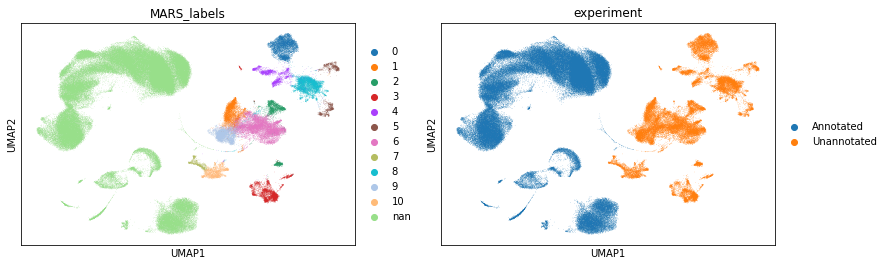

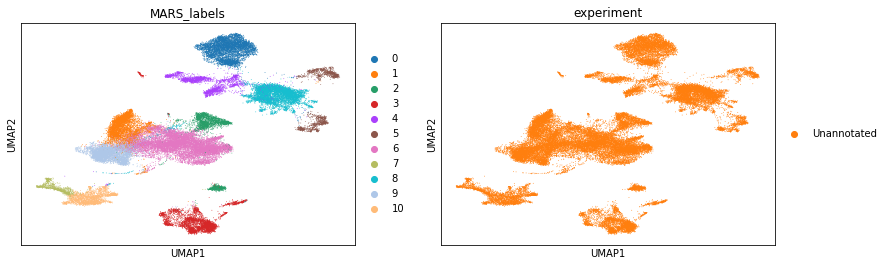

In [21]:
MARS_latent_umap(ae_merge_adata, plot_gene_list = ['MARS_labels','experiment'], save=".png")

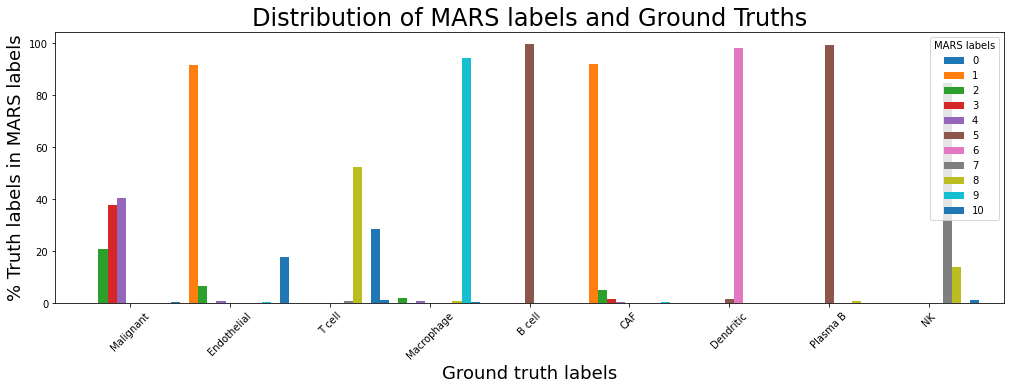

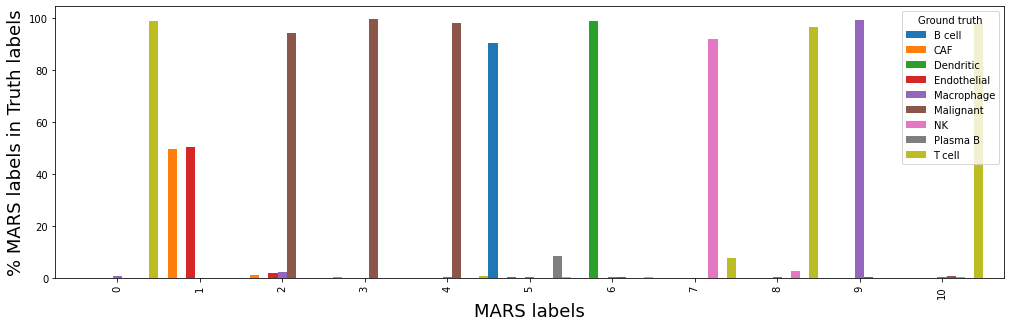

In [33]:
cell_type_assign(ae_merge_adata, save=True)

/home/estelle860530/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'label_name' as categorical


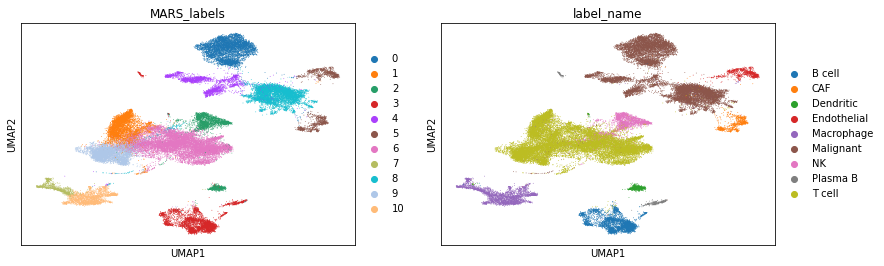

In [24]:
sc.pl.umap(ae_merge_adata[ae_merge_adata.obs.experiment=="Unannotated"], 
           color=['MARS_labels', 'label_name'], ncols=2, save=".png")

In [25]:
subset  = ae_merge_adata[(ae_merge_adata.obs['experiment']=='Annotated')|(ae_merge_adata.obs['MARS_labels']=='0')|(ae_merge_adata.obs['MARS_labels']=='4')|(ae_merge_adata.obs['MARS_labels']=='8') ]
subset

View of AnnData object with n_obs × n_vars = 127121 × 2240
    obs: 'truth_labels', 'MARS_labels', 'experiment', 'label_name'
    uns: 'neighbors', 'umap', 'MARS_labels_colors', 'experiment_colors'
    obsm: 'MARS_embedding', 'X_umap'
    obsp: 'distances', 'connectivities'

In [26]:
mars_ae_celltype = ae_merge_mars.name_cell_types(subset , ae_merge_landmarks, list(multi_nametonum.keys()))


Cluster label: 0
CD8 Proliferating: 5.262121750754425e-24
CD4 Proliferating: 1.8469932166810822e-23
ILC: 1.991743263905753e-21
NK Proliferating: 2.0862615360646e-21
Eryth: 1.0

Cluster label: 4
CD8 Proliferating: 9.826936622494914e-19
CD4 Proliferating: 4.993201278188542e-18
ILC: 2.1830373956717924e-17
NK Proliferating: 1.5611951791018866e-16
Eryth: 0.9999999999999999

Cluster label: 8
CD8 Proliferating: 4.798626076216131e-60
CD4 Proliferating: 4.936661715219282e-57
NK Proliferating: 1.1818029233625932e-56
ILC: 7.920686940872712e-52
Eryth: 1.0


In [27]:
subset  = ae_merge_adata[(ae_merge_adata.obs['experiment']=='Annotated')|(ae_merge_adata.obs['MARS_labels']=='1')|(ae_merge_adata.obs['MARS_labels']=='6')|(ae_merge_adata.obs['MARS_labels']=='9') ]
subset

View of AnnData object with n_obs × n_vars = 133282 × 2240
    obs: 'truth_labels', 'MARS_labels', 'experiment', 'label_name'
    uns: 'neighbors', 'umap', 'MARS_labels_colors', 'experiment_colors'
    obsm: 'MARS_embedding', 'X_umap'
    obsp: 'distances', 'connectivities'

In [28]:
mars_ae_celltype = ae_merge_mars.name_cell_types(subset , ae_merge_landmarks, list(multi_nametonum.keys()))


Cluster label: 1
CD8 Proliferating: 7.096853411668823e-19
CD4 Proliferating: 2.0826305497244356e-18
NK Proliferating: 8.928034656453294e-16
ILC: 8.80689758696603e-14
Eryth: 0.9999999999999111

Cluster label: 6
CD8 Proliferating: 3.950438655740201e-08
CD4 Proliferating: 1.5983950736794817e-07
NK Proliferating: 8.793334729884233e-07
ILC: 1.8234747971567087e-05
Eryth: 0.9999806864598461

Cluster label: 9
CD8 Proliferating: 1.9710258970545316e-51
CD4 Proliferating: 8.169075979088457e-47
NK Proliferating: 1.4553896539940917e-42
ILC: 1.6690372013738443e-39
Eryth: 1.0
